<a href="https://colab.research.google.com/github/plaban1981/Abhishek_Thakur_Live_coding/blob/main/Content_Based_Image_Search_InstructBLIP_%2B_Sentence_Transformers_%2B_FAISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git accelerate bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.6 MB/s eta 0:00:00


In [2]:
!pip install -qU datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.5 MB/s eta 0:00:00


In [3]:
import torch
from datasets import load_dataset
from transformers import InstructBlipProcessor,InstructBlipForConditionalGeneration

In [4]:
model = InstructBlipForConditionalGeneration.from_pretrained("Salesforce/instructblip-vicuna-7b",
                                                             load_in_4bit=True,
                                                             torch_dtype = torch.bfloat16,)
#
processor = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-vicuna-7b")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

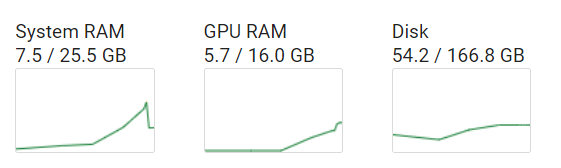

## Datasets

In [ ]:
datasets = [
    ("detection-datasets/fashionpedia",None,"val"),
    ("keremberke/nfl-object-detection","mini","test"),
    ("keremberke/nplane-detection","mini","train"),
    ("Matthijs/snacks",None,"validation"),
    ("rokmr/mini_pets",None,"test"),
    ("keremberke/pokemon-classification","mini","train"),
]

## Reducing sample images for running the logic faster

In [5]:
datasets = [
    ("detection-datasets/fashionpedia",None,"val"),
    ("Matthijs/snacks",None,"validation"),
]

In [6]:
prompt_1 = """Describe this image in full detail.describe each and every aspect of the image"""
prompt_2 = """Create an extensive description of the image"""

In [10]:
import os
os.mkdir("images")

In [11]:
counter = 0
content = []
seq = []
from tqdm import tqdm
for name,config,split in datasets:
  d = load_dataset(name,config,split=split)
  for idx in tqdm(range(len(d))):
    image  = d[idx]["image"]
    desc = ""
    for _prompt in [prompt_1,prompt_2]:
      inputs = processor(images=image,
                         text=_prompt,
                         return_tensors="pt"
                         ).to(model.device,torch.bfloat16)
      outputs = model.generate(**inputs,
                               do_sample=False,
                               num_beams=10,
                               max_length=512,
                               min_length=16,
                               top_p=0.9,
                               repetition_penalty=1.5,
                               temperature=1,
                               )
      generated_text = processor.batch_decode(outputs,skip_special_tokens=True)[0].strip()
      desc += generated_text + " "
      desc = desc.strip()
      image.save(f"images/{counter}.jpg")
      print(counter,desc)
      seq.append(counter)
      content.append(desc)
      #
      '''
      with open("description.csv","a") as f:
        f.write(f"{counter},{desc}\n")
      counter += 1
      '''
      counter += 1
      torch.cuda.empty_cache()


  0%|          | 0/1158 [00:00<?, ?it/s]

0 The image features a well-dressed man with a beard wearing a suit, bow tie, and sunglasses. He is standing in front of a yellow door, posing confidently for the camera.  In addition to the man, there are two potted plants visible in the scene, one on the left side of the image and another on the right side. There are also several potted plants scattered throughout the image, adding to the vibrant and lively atmosphere.



  0%|          | 1/1158 [00:12<3:55:43, 12.22s/it]

1 The image features a well-dressed man with a beard wearing a suit, bow tie, and sunglasses. He is standing in front of a yellow door, posing confidently for the camera.  In addition to the man, there are two potted plants visible in the scene, one on the left side of the image and another on the right side. There are also several potted plants scattered throughout the image, adding to the vibrant and lively atmosphere.a bearded man wearing a suit and bow tie is standing in front of a yellow door
2 The image features a beautiful blonde woman wearing a black dress on a runway. She is confidently strutting down the runway, showcasing her sophisticated fashion sense.  In the background, a group of people can be seen observing the fashion show, captivated by the stunning display of clothing and accessories. Numerous balloons are scattered throughout the scene, adding a playful and festive touch to the event. A pink purse can be seen in the hands of one of the attendees, further emphasizin


  0%|          | 2/1158 [00:28<4:41:46, 14.62s/it]

3 The image features a beautiful blonde woman wearing a black dress on a runway. She is confidently strutting down the runway, showcasing her sophisticated fashion sense.  In the background, a group of people can be seen observing the fashion show, captivated by the stunning display of clothing and accessories. Numerous balloons are scattered throughout the scene, adding a playful and festive touch to the event. A pink purse can be seen in the hands of one of the attendees, further emphasizing the vibrant and lively atmosphere of the fashion show.a woman walking down the runway wearing a black dress and carrying a pink purse
4 A fashion show is taking place on the runway, featuring a young man dressed in a brown suit. He is walking confidently down the runway, capturing the attention of the audience. The runway appears to be quite long, stretching across the entire scene.  In addition to the runway, there are several chairs scattered throughout the venue, providing seating for those at


  0%|          | 3/1158 [00:40<4:21:34, 13.59s/it]

5 A fashion show is taking place on the runway, featuring a young man dressed in a brown suit. He is walking confidently down the runway, capturing the attention of the audience. The runway appears to be quite long, stretching across the entire scene.  In addition to the runway, there are several chairs scattered throughout the venue, providing seating for those attending the fashion show. There are at least six chairs visible in the image, with some located closer to the runway and others positioned further away.a male model walking down a runway wearing a brown jacket
6 The image depicts a male fashion model strutting down a runway during a fashion show. He is wearing a sleek black tank top and leather pants, exuding confidence and style as he walks the runway.  Numerous people can be seen in the audience, captivated by the sophisticated fashion display. In total, there are thirteen people visible in the image, with some positioned closer to the runway and others further away.



  0%|          | 4/1158 [00:54<4:21:05, 13.58s/it]

7 The image depicts a male fashion model strutting down a runway during a fashion show. He is wearing a sleek black tank top and leather pants, exuding confidence and style as he walks the runway.  Numerous people can be seen in the audience, captivated by the sophisticated fashion display. In total, there are thirteen people visible in the image, with some positioned closer to the runway and others further away.a man walking down a runway wearing a leather tank top
8 The image depicts a young woman wearing a plaid shirt sitting on the edge of a bridge. She appears to be lost in thought or daydreaming as she gazes into the distance.  In addition to the woman, there are several other objects present in the scene. There are three bottles scattered throughout the image, two on the left side and one on the right side. A car can also be seen in the background, parked on the side of the road near the bridge.



  0%|          | 5/1158 [01:08<4:27:21, 13.91s/it]

9 The image depicts a young woman wearing a plaid shirt sitting on the edge of a bridge. She appears to be lost in thought or daydreaming as she gazes into the distance.  In addition to the woman, there are several other objects present in the scene. There are three bottles scattered throughout the image, two on the left side and one on the right side. A car can also be seen in the background, parked on the side of the road near the bridge.a woman wearing a plaid shirt is sitting on a cement wall
10 The image depicts a young Asian woman wearing a black top and shorts. She is posing for the camera, holding a cigarette in one hand and pointing with the other.  In addition to the woman, there are several other objects present in the image. A necklace can be seen hanging around the woman's neck, while a bracelet is visible on her left arm. There are also two earrings visible, one on the left side of the woman's head and the other on the right side. A cell phone can be seen in the lower rig


  1%|          | 6/1158 [01:24<4:37:57, 14.48s/it]

11 The image depicts a young Asian woman wearing a black top and shorts. She is posing for the camera, holding a cigarette in one hand and pointing with the other.  In addition to the woman, there are several other objects present in the image. A necklace can be seen hanging around the woman's neck, while a bracelet is visible on her left arm. There are also two earrings visible, one on the left side of the woman's head and the other on the right side. A cell phone can be seen in the lower right corner of the image, likely belonging to the woman or someone else in the scene.a woman wearing shorts and a shirt poses for the camera
12 The image features a beautiful blonde woman wearing a black leather jacket and carrying a wicker basket. She is standing in front of a gate or fence, looking towards the left side of the image.  In addition to the woman, there are several other objects visible in the scene. There are two potted plants on the left side of the image, one closer to the woman an


  1%|          | 7/1158 [01:40<4:48:10, 15.02s/it]

13 The image features a beautiful blonde woman wearing a black leather jacket and carrying a wicker basket. She is standing in front of a gate or fence, looking towards the left side of the image.  In addition to the woman, there are several other objects visible in the scene. There are two potted plants on the left side of the image, one closer to the woman and the other slightly further away. Another plant can be seen on the right side of the image, closer to the gate or fence. There are also two chairs positioned near the woman, one on the left side and the other on the right side of the image.a woman in a black leather jacket holding a wicker basket
14 The image depicts a young woman wearing a red beanie and shorts, standing in a field surrounded by vibrant wildflowers. She appears to be enjoying the natural beauty of her surroundings, possibly taking a leisurely stroll through the field.  In addition to the woman, there are several flowers scattered throughout the scene, creating 


  1%|          | 8/1158 [01:54<4:40:25, 14.63s/it]

15 The image depicts a young woman wearing a red beanie and shorts, standing in a field surrounded by vibrant wildflowers. She appears to be enjoying the natural beauty of her surroundings, possibly taking a leisurely stroll through the field.  In addition to the woman, there are several flowers scattered throughout the scene, creating a colorful and lively atmosphere. Numerous flowers can be seen on the left side of the image, while some are positioned on the right side as well.a woman wearing a red beanie standing in a field of flowers
16 The image depicts a beautiful young woman walking down a runway wearing a stunning white dress. She is adorned with a necklace, adding a touch of sophistication to her appearance. The runway appears to be quite long, stretching from the left side of the image all the way to the right.  In addition to the runway, there are several chairs visible in the background, likely providing seating for those attending the fashion show. Overall, the image captu


  1%|          | 9/1158 [02:09<4:41:27, 14.70s/it]

17 The image depicts a beautiful young woman walking down a runway wearing a stunning white dress. She is adorned with a necklace, adding a touch of sophistication to her appearance. The runway appears to be quite long, stretching from the left side of the image all the way to the right.  In addition to the runway, there are several chairs visible in the background, likely providing seating for those attending the fashion show. Overall, the image captures the essence of a glamorous fashion event, showcasing the designer's creativity and the model's confidence as she struts her stuff on the runway.a woman walking down a runway wearing a white lace dress
18 The image features a beautiful woman wearing a stunning red dress, leaning against a stone wall. She is posing seductively for the camera, captivating the viewer's attention.  In addition to the woman, there are several other objects present in the scene. A vase can be seen on the left side of the image, while another vase is position


  1%|          | 10/1158 [02:23<4:39:32, 14.61s/it]

19 The image features a beautiful woman wearing a stunning red dress, leaning against a stone wall. She is posing seductively for the camera, captivating the viewer's attention.  In addition to the woman, there are several other objects present in the scene. A vase can be seen on the left side of the image, while another vase is positioned on the right side. There are also two potted plants visible, one on the left side and another on the right side of the image.a woman in a red dress leaning against a stone wall posing
20 The image depicts a fashion show taking place on a runway. A beautiful woman is standing confidently on the runway, showcasing a stunning black and white outfit. She is surrounded by a group of people who appear to be enjoying the fashion show. In total, thirteen people can be seen in the image, with some positioned closer to the runway and others further away. There are also several chairs scattered throughout the scene, providing seating for the attendees.



  1%|          | 11/1158 [02:35<4:22:53, 13.75s/it]

21 The image depicts a fashion show taking place on a runway. A beautiful woman is standing confidently on the runway, showcasing a stunning black and white outfit. She is surrounded by a group of people who appear to be enjoying the fashion show. In total, thirteen people can be seen in the image, with some positioned closer to the runway and others further away. There are also several chairs scattered throughout the scene, providing seating for the attendees.a model walks down the runway wearing a black and white outfit
22 The image features a woman wearing a stunning yellow gown on the runway. She is elegantly walking down the runway, showcasing the intricate details of the dress.  In total, there are ten people visible in the image, including the woman in the yellow gown. They are positioned throughout the scene, ranging from the left side of the image to the right side, with some individuals closer to the woman on the runway.



  1%|          | 12/1158 [02:50<4:28:50, 14.08s/it]

23 The image features a woman wearing a stunning yellow gown on the runway. She is elegantly walking down the runway, showcasing the intricate details of the dress.  In total, there are ten people visible in the image, including the woman in the yellow gown. They are positioned throughout the scene, ranging from the left side of the image to the right side, with some individuals closer to the woman on the runway.a model walks down the runway wearing a yellow gown
24 The image features a man wearing a black hooded sweatshirt and pants, sitting on the sidewalk in front of a building. He appears to be contemplative, with his arms resting on his knees.  In addition to the man, there are several other objects visible in the scene. There are two chairs placed near the man, one on the left side of the image and another on the right side. A third chair can be seen further away from the man, closer to the center of the image.  There are also two bottles present in the scene, one on the left sid


  1%|          | 13/1158 [03:16<5:37:15, 17.67s/it]

25 The image features a man wearing a black hooded sweatshirt and pants, sitting on the sidewalk in front of a building. He appears to be contemplative, with his arms resting on his knees.  In addition to the man, there are several other objects visible in the scene. There are two chairs placed near the man, one on the left side of the image and another on the right side. A third chair can be seen further away from the man, closer to the center of the image.  There are also two bottles present in the scene, one on the left side of the image and another on the right side, close to the man's position. Another bottle can be seen further away from the man, closer to the center of the image.  Additionally, there are two cups visible in the image, one on the left side and another on the right side, close to the man's position. A third cup is situated further away from the man, closer to the center of the image. Overall, the image depicts a man sitting on the sidewalk, surrounded by various o


  1%|          | 14/1158 [03:29<5:11:17, 16.33s/it]

27 The image depicts a young woman wearing a colorful t-shirt, standing in front of a chain-link fence. She is holding a purse in one hand and a cell phone in the other. There are several cars parked near the fence, including a red car, a blue car, a green car, and a white car. Additionally, there are two benches visible in the scene, one on the left side and another on the right side of the image.a woman standing in front of a fence wearing a colorful shirt
28 The image depicts a woman walking down a runway, wearing a stylish outfit consisting of a dress and a jacket. She appears to be confidently strutting down the runway, showcasing her fashionable attire.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen throughout the image, with some positioned closer to the woman on the runway and others further away. They appear to be enjoying the fashion show or participating in the event.



  1%|▏         | 15/1158 [03:42<4:51:29, 15.30s/it]

29 The image depicts a woman walking down a runway, wearing a stylish outfit consisting of a dress and a jacket. She appears to be confidently strutting down the runway, showcasing her fashionable attire.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen throughout the image, with some positioned closer to the woman on the runway and others further away. They appear to be enjoying the fashion show or participating in the event.a woman walking down a runway wearing a skirt and jacket
30 The image features a woman walking down a runway wearing a yellow top and black leather pants. She appears confident and poised as she struts her stuff on the runway, showcasing the latest fashion trends.  In addition to the woman's attire, there are several chairs visible in the background of the image, suggesting that this might be a fashion show or presentation venue. The overall atmosphere is vibrant and energetic, capturing the esse


  1%|▏         | 16/1158 [03:54<4:32:20, 14.31s/it]

31 The image features a woman walking down a runway wearing a yellow top and black leather pants. She appears confident and poised as she struts her stuff on the runway, showcasing the latest fashion trends.  In addition to the woman's attire, there are several chairs visible in the background of the image, suggesting that this might be a fashion show or presentation venue. The overall atmosphere is vibrant and energetic, capturing the essence of the latest fashion trends.a woman walking down a runway wearing an orange top and black leather pants
32 The image depicts a fashion show taking place on a runway. A young woman is walking confidently down the runway, wearing a black cape and brown pants. She is surrounded by a group of women who appear to be attending the fashion show. Nine women can be seen in various positions around the runway, ranging from the left side to the right side of the image. Some of the women are closer to the center of the runway, while others are positioned fu


  1%|▏         | 17/1158 [04:10<4:43:54, 14.93s/it]

33 The image depicts a fashion show taking place on a runway. A young woman is walking confidently down the runway, wearing a black cape and brown pants. She is surrounded by a group of women who appear to be attending the fashion show. Nine women can be seen in various positions around the runway, ranging from the left side to the right side of the image. Some of the women are closer to the center of the runway, while others are positioned further away. Additionally, there are two handbags visible in the scene, one on the left side and another on the right side of the runway.a woman walking down a runway wearing brown pants and a black cape
34 A fashion show is taking place on the runway, featuring a beautiful young woman wearing a white dress. She is standing confidently on the runway, captivating the audience with her stunning appearance.  In addition to the runway, there are several chairs placed throughout the venue, providing seating for those attending the event. Numerous people


  2%|▏         | 18/1158 [04:22<4:25:32, 13.98s/it]

35 A fashion show is taking place on the runway, featuring a beautiful young woman wearing a white dress. She is standing confidently on the runway, captivating the audience with her stunning appearance.  In addition to the runway, there are several chairs placed throughout the venue, providing seating for those attending the event. Numerous people can be seen in the crowd, enjoying the fashion show and taking in the sights and sounds of the event.an african american woman in a white dress on a runway
36 The image depicts a fashion show taking place on a runway. A woman can be seen walking down the runway, wearing a gray outfit and sunglasses. She appears to be confidently strutting her stuff, showcasing the latest fashion trends.  In addition to the main model, there are several other people visible on the runway, including three women and one man. They appear to be observing the fashion show or participating in it as part of the audience. Overall, the image captures the excitement an


  2%|▏         | 19/1158 [04:36<4:23:28, 13.88s/it]

37 The image depicts a fashion show taking place on a runway. A woman can be seen walking down the runway, wearing a gray outfit and sunglasses. She appears to be confidently strutting her stuff, showcasing the latest fashion trends.  In addition to the main model, there are several other people visible on the runway, including three women and one man. They appear to be observing the fashion show or participating in it as part of the audience. Overall, the image captures the excitement and energy of a vibrant fashion event.a woman walking down a runway wearing sunglasses on her face
38 A fashion show is taking place on the runway, featuring a beautiful blonde woman wearing a pink dress. She is confidently strutting down the runway, captivating the audience with her stunning appearance.  In addition to the runway, there are several chairs placed throughout the venue, providing comfortable seating for the attendees. Some of the chairs are positioned near the runway, while others are situ


  2%|▏         | 20/1158 [04:49<4:20:11, 13.72s/it]

39 A fashion show is taking place on the runway, featuring a beautiful blonde woman wearing a pink dress. She is confidently strutting down the runway, captivating the audience with her stunning appearance.  In addition to the runway, there are several chairs placed throughout the venue, providing comfortable seating for the attendees. Some of the chairs are positioned near the runway, while others are situated closer to the audience.a woman in a pink dress walking down a runway at a fashion show
40 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking confidently down the runway, wearing a pink bomber jacket and a skirt. She is surrounded by a group of people who appear to be enjoying the fashion show.  In total, there are 15 people visible in the image, some of whom are seated and watching the fashion show, while others are standing around the runway. Additionally, several chairs can be seen scattered throughout the scene, providing seating fo


  2%|▏         | 21/1158 [05:02<4:15:15, 13.47s/it]

41 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking confidently down the runway, wearing a pink bomber jacket and a skirt. She is surrounded by a group of people who appear to be enjoying the fashion show.  In total, there are 15 people visible in the image, some of whom are seated and watching the fashion show, while others are standing around the runway. Additionally, several chairs can be seen scattered throughout the scene, providing seating for those attending the event.a woman walking down a runway wearing a pink jacket
42 The image depicts a woman walking down a runway wearing a black dress. She is carrying an ornate umbrella, reminiscent of the traditional Chinese parasol known as a bamboo umbrella. The woman appears to be confidently strutting down the runway, showcasing her fashionable attire. In addition to the woman and her umbrella, there are several other objects visible on the runway, including a handbag, a purse, and a pair 


  2%|▏         | 22/1158 [05:16<4:15:59, 13.52s/it]

43 The image depicts a woman walking down a runway wearing a black dress. She is carrying an ornate umbrella, reminiscent of the traditional Chinese parasol known as a bamboo umbrella. The woman appears to be confidently strutting down the runway, showcasing her fashionable attire. In addition to the woman and her umbrella, there are several other objects visible on the runway, including a handbag, a purse, and a pair of shoes. These accessories add to the vibrant and fashionable atmosphere of the scene.of a woman walking down a runway with an umbrella in her hand
44 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a maroon leather jacket, black dress, and high heels. She exudes confidence and poise as she struts her stuff on the runway. Numerous chairs can be seen in the background, likely providing seating for the audience attending the fashion show. In total, there are nine chairs visible in the scene.



  2%|▏         | 23/1158 [05:28<4:11:18, 13.29s/it]

45 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a maroon leather jacket, black dress, and high heels. She exudes confidence and poise as she struts her stuff on the runway. Numerous chairs can be seen in the background, likely providing seating for the audience attending the fashion show. In total, there are nine chairs visible in the scene.a woman walking down a runway wearing a leather jacket
46 The image features a beautiful woman wearing a white top and pants, leaning against a wooden wall. She is posing seductively for the camera, showcasing her curves and allure.  In addition to the woman, there are several other objects in the scene. There are two chairs placed near the woman, one on the left side and the other on the right side of the image. Another chair can be seen in the background, positioned closer to the woman than the first two chairs.  Nine people can be seen in the image, including the woman and


  2%|▏         | 24/1158 [05:44<4:25:56, 14.07s/it]

47 The image features a beautiful woman wearing a white top and pants, leaning against a wooden wall. She is posing seductively for the camera, showcasing her curves and allure.  In addition to the woman, there are several other objects in the scene. There are two chairs placed near the woman, one on the left side and the other on the right side of the image. Another chair can be seen in the background, positioned closer to the woman than the first two chairs.  Nine people can be seen in the image, including the woman and the two chairs. They are arranged in a semi-circle around the woman, creating a sense of intimacy and admiration for her beauty.a woman leaning against a wall wearing a white shirt and pants
48 The image depicts a young woman wearing a red shirt and black pants. She is leaning against a railing with her left arm, while her right arm is stretched out in front of her.  In the background, there are two staircases visible, one on the left side and the other on the right s


  2%|▏         | 25/1158 [05:59<4:27:18, 14.16s/it]

49 The image depicts a young woman wearing a red shirt and black pants. She is leaning against a railing with her left arm, while her right arm is stretched out in front of her.  In the background, there are two staircases visible, one on the left side and the other on the right side of the image. Additionally, there are several bottles scattered throughout the scene, including one on the left side and another on the right side of the image.a woman in a red shirt leaning against a metal railing
50 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a red dress that catches the attention of the audience. Numerous people can be seen in the background, watching the fashion show and enjoying the event. In total, there are 15 people visible in the image, with some standing closer to the runway while others are positioned further away. Additionally, there are several handbags scattered throughout the scene, likely belonging to the 


  2%|▏         | 26/1158 [06:11<4:18:25, 13.70s/it]

51 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a red dress that catches the attention of the audience. Numerous people can be seen in the background, watching the fashion show and enjoying the event. In total, there are 15 people visible in the image, with some standing closer to the runway while others are positioned further away. Additionally, there are several handbags scattered throughout the scene, likely belonging to the fashion show's attendees.a woman walking down a runway wearing an eco-friendly dress
52 in full detail. The image features a beautiful blonde woman wearing a striped dress, standing on a bridge overlooking a body of water. She is posing for the camera, smiling and enjoying her surroundings.  In the background, there are several trees visible, adding to the serene atmosphere of the scene. The woman's hair is styled in loose curls, giving her a youthful and carefree appearance. She appears to be h


  2%|▏         | 27/1158 [06:24<4:11:46, 13.36s/it]

53 in full detail. The image features a beautiful blonde woman wearing a striped dress, standing on a bridge overlooking a body of water. She is posing for the camera, smiling and enjoying her surroundings.  In the background, there are several trees visible, adding to the serene atmosphere of the scene. The woman's hair is styled in loose curls, giving her a youthful and carefree appearance. She appears to be having a great time, capturing the essence of summertime relaxation.a woman wearing a striped dress is posing for the camera
54 The image features a young woman wearing a white shirt and black leather shorts. She is standing against a white wall, posing confidently for the camera.  In addition to the woman, there are several other objects visible in the image. There are three pairs of shoes scattered throughout the scene, two on the left side of the image and one on the right side. A necklace can also be seen hanging around the woman's neck, adding a touch of elegance to her outf


  2%|▏         | 28/1158 [06:36<4:07:21, 13.13s/it]

55 The image features a young woman wearing a white shirt and black leather shorts. She is standing against a white wall, posing confidently for the camera.  In addition to the woman, there are several other objects visible in the image. There are three pairs of shoes scattered throughout the scene, two on the left side of the image and one on the right side. A necklace can also be seen hanging around the woman's neck, adding a touch of elegance to her outfit.a woman wearing black leather shorts and a white shirt
56 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a stunning black and gold gown. She appears to be confidently strutting her stuff, captivating the audience with her presence.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen throughout the image, ranging from the left side to the right side of the runway. They appear to be enjoying the fashion show and 


  3%|▎         | 29/1158 [06:50<4:10:12, 13.30s/it]

57 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a stunning black and gold gown. She appears to be confidently strutting her stuff, captivating the audience with her presence.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen throughout the image, ranging from the left side to the right side of the runway. They appear to be enjoying the fashion show and possibly providing support for the model on the runway.a woman on the runway wearing a black and gold gown
58 The image features a woman walking down a runway wearing a black dress. She is the center of attention on the runway, capturing the audience's attention as she struts her stuff.  In addition to the woman on the runway, there are several other people visible in the scene, including a man and two women who appear to be enjoying the fashion show. They can be seen in various positions around the runway, adding


  3%|▎         | 30/1158 [07:05<4:16:47, 13.66s/it]

59 The image features a woman walking down a runway wearing a black dress. She is the center of attention on the runway, capturing the audience's attention as she struts her stuff.  In addition to the woman on the runway, there are several other people visible in the scene, including a man and two women who appear to be enjoying the fashion show. They can be seen in various positions around the runway, adding to the vibrant atmosphere of the event. Overall, the image captures the energy and excitement of a fashion show, with the focus on the stunning black dress worn by the woman on the runway.a woman walking down the runway wearing a black dress and high heels
60 The image features a young woman posing for the camera, wearing a stylish dress. She is standing against a white background, showcasing her beauty and elegance. The dress she is wearing appears to be a one-shoulder style, with a unique twist that makes it stand out.  In addition to the dress, the woman is adorned with a pair 


  3%|▎         | 31/1158 [07:21<4:34:07, 14.59s/it]

61 The image features a young woman posing for the camera, wearing a stylish dress. She is standing against a white background, showcasing her beauty and elegance. The dress she is wearing appears to be a one-shoulder style, with a unique twist that makes it stand out.  In addition to the dress, the woman is adorned with a pair of earrings, adding a touch of sophistication to her appearance. There are multiple earrings visible in the image, with some placed on the left side of the woman's neck, while others are positioned on the right side. A total of thirteen earrings can be seen throughout the image, showcasing the intricate details of the woman's jewelry.a woman wearing a dress poses for the camera with her hands on her hips
62 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a black and leopard-print dress. She appears to be confidently strutting her stuff, captivating the attention of the audience. Numerous people can be seen i


  3%|▎         | 32/1158 [07:35<4:28:21, 14.30s/it]

63 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a black and leopard-print dress. She appears to be confidently strutting her stuff, captivating the attention of the audience. Numerous people can be seen in the background, watching the fashion show intently. There are at least 15 people visible in the scene, with some positioned closer to the runway than others. Additionally, there are several handbags scattered throughout the image, likely belonging to the fashion show's attendees.a woman walking down a runway wearing a leopard print dress
64 The image depicts a young woman dressed in a yellow dress sitting on a stone wall. She is surrounded by graffiti on the wall, creating an interesting contrast between the vibrant color of her dress and the dullness of the graffiti.  In addition to the woman, there are several other objects present in the scene. A cell phone can be seen on the left side of the image, close to the woman's lef


  3%|▎         | 33/1158 [07:50<4:33:20, 14.58s/it]

65 The image depicts a young woman dressed in a yellow dress sitting on a stone wall. She is surrounded by graffiti on the wall, creating an interesting contrast between the vibrant color of her dress and the dullness of the graffiti.  In addition to the woman, there are several other objects present in the scene. A cell phone can be seen on the left side of the image, close to the woman's left foot. Another cell phone is located on the right side of the image, closer to the woman's right foot. There are also two bottles visible in the scene, one on the left side and another on the right side, near the cell phones.a woman in a yellow dress sitting in front of some graffiti
66 The image features a young woman wearing a black hat and a floral dress. She is standing in front of a brick wall, smiling and posing for the camera.  In addition to the hat and dress, the woman is also wearing a belt around her waist, adding a touch of sophistication to her outfit. Her hair is styled in a loose b


  3%|▎         | 34/1158 [08:08<4:51:16, 15.55s/it]

67 The image features a young woman wearing a black hat and a floral dress. She is standing in front of a brick wall, smiling and posing for the camera.  In addition to the hat and dress, the woman is also wearing a belt around her waist, adding a touch of sophistication to her outfit. Her hair is styled in a loose bun at the back of her head, contributing to her charming appearance.  There are several other objects visible in the image, including a handbag placed on the ground near the woman's feet, a cell phone on the left side of the image, and a pair of shoes on the right side of the image. These accessories add to the vibrant atmosphere of the photograph.a woman wearing a black hat and dress poses for the camera
68 The image depicts a fashion show taking place in a spacious venue. A beautiful woman is walking down the runway, wearing a short black dress and high heels. She commands attention as she struts her stuff on the catwalk.  In addition to the runway, there are several chai


  3%|▎         | 35/1158 [08:24<4:54:26, 15.73s/it]

69 The image depicts a fashion show taking place in a spacious venue. A beautiful woman is walking down the runway, wearing a short black dress and high heels. She commands attention as she struts her stuff on the catwalk.  In addition to the runway, there are several chairs scattered throughout the venue, providing seating for the attendees. A cell phone can be seen in one of the hands of the woman on the runway, suggesting that she may be capturing the moment for herself or sharing it with others through social media or other means. Overall, the scene exudes an air of sophistication and elegance, showcasing the latest fashion trends.a woman walking down a runway in front of a group of people
70 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a stunning white sari adorned with intricate gold embroidery. The sari is flowing behind her as she confidently strides towards the end of the runway.  In addition to the main model


  3%|▎         | 36/1158 [08:41<4:58:22, 15.96s/it]

71 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a stunning white sari adorned with intricate gold embroidery. The sari is flowing behind her as she confidently strides towards the end of the runway.  In addition to the main model, there are several other women present on the runway, adding to the vibrancy and diversity of the fashion show. They can be seen in various positions along the runway, creating a lively atmosphere for the event.a model walks down the runway wearing a white gown
72 The image depicts a young woman wearing a hat while standing on the side of a road. She is elegantly dressed in a purple dress and black heels, adding a touch of sophistication to her appearance.  In the background, there are several trees lining the road, providing a serene and natural setting for the woman's photoshoot. Numerous cars can be seen parked on the side of the road, adding to the vibrant atmosphere of the scene.



  3%|▎         | 37/1158 [08:55<4:47:11, 15.37s/it]

73 The image depicts a young woman wearing a hat while standing on the side of a road. She is elegantly dressed in a purple dress and black heels, adding a touch of sophistication to her appearance.  In the background, there are several trees lining the road, providing a serene and natural setting for the woman's photoshoot. Numerous cars can be seen parked on the side of the road, adding to the vibrant atmosphere of the scene.a woman wearing a hat is standing on the side of the road
74 The image depicts a young woman standing in a grassy field surrounded by bicycles. She is wearing a red shirt and appears to be laughing or smiling. There are multiple bicycles scattered throughout the field, with some closer to the woman and others positioned further away. In total, there are nine bicycles visible in the scene.



  3%|▎         | 38/1158 [09:06<4:23:57, 14.14s/it]

75 The image depicts a young woman standing in a grassy field surrounded by bicycles. She is wearing a red shirt and appears to be laughing or smiling. There are multiple bicycles scattered throughout the field, with some closer to the woman and others positioned further away. In total, there are nine bicycles visible in the scene.a woman standing in a field with a skateboard under her arm
76 The image depicts a fashion show taking place on a runway. A beautiful blonde woman can be seen walking down the runway, wearing a black jumpsuit and high heels. She is confidently strutting her stuff, captivating the audience with her stunning presence.  In addition to the main model, there are several other people visible in the scene, some of whom appear to be part of the audience while others might be involved in the production of the fashion show. Overall, the image captures the excitement and energy of a vibrant fashion event.



  3%|▎         | 39/1158 [09:20<4:25:19, 14.23s/it]

77 The image depicts a fashion show taking place on a runway. A beautiful blonde woman can be seen walking down the runway, wearing a black jumpsuit and high heels. She is confidently strutting her stuff, captivating the audience with her stunning presence.  In addition to the main model, there are several other people visible in the scene, some of whom appear to be part of the audience while others might be involved in the production of the fashion show. Overall, the image captures the excitement and energy of a vibrant fashion event.a woman walking down a runway wearing a black jumpsuit
78 A fashion show is taking place on the runway, featuring a woman dressed in a stunning silver gown. She is confidently strutting down the runway, captivating the audience with her beauty and poise. The runway appears to be quite long, stretching across the entire length of the image. Numerous people can be seen observing the fashion show, either seated or standing along the sides of the runway. Addi


  3%|▎         | 40/1158 [09:33<4:16:06, 13.74s/it]

79 A fashion show is taking place on the runway, featuring a woman dressed in a stunning silver gown. She is confidently strutting down the runway, captivating the audience with her beauty and poise. The runway appears to be quite long, stretching across the entire length of the image. Numerous people can be seen observing the fashion show, either seated or standing along the sides of the runway. Additionally, there are several cameras positioned around the runway, capturing the event from various angles.a model walks down the runway wearing a grey gown
80 A fashion show is taking place on the runway, featuring a beautiful woman wearing a stunning red dress. She is elegantly walking down the runway, captivating the audience with her presence. The runway appears to be quite long, stretching across the entire background of the image. Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show.



  4%|▎         | 41/1158 [09:46<4:10:24, 13.45s/it]

81 A fashion show is taking place on the runway, featuring a beautiful woman wearing a stunning red dress. She is elegantly walking down the runway, captivating the audience with her presence. The runway appears to be quite long, stretching across the entire background of the image. Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show.a woman is walking down the runway in a red dress at a fashion show
82 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a white dress and high heels. She appears to be confidently strutting her stuff, capturing the audience's attention.  In addition to the woman on the runway, there are several other people present at the fashion show. They can be seen seated in various locations around the runway, enjoying the event. There are also a few chairs scattered throughout the scene, providing additional seating for the attendees. Overall, t


  4%|▎         | 42/1158 [10:01<4:22:58, 14.14s/it]

83 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a white dress and high heels. She appears to be confidently strutting her stuff, capturing the audience's attention.  In addition to the woman on the runway, there are several other people present at the fashion show. They can be seen seated in various locations around the runway, enjoying the event. There are also a few chairs scattered throughout the scene, providing additional seating for the attendees. Overall, the fashion show appears to be a vibrant and lively event, showcasing the latest designs and trends in the fashion industry.a woman on the runway wearing a white skirt and high heel shoes
84 The image depicts a woman wearing a white trench coat walking down a sidewalk. She is carrying a pink purse on her shoulder, adding a pop of color to her outfit. In total, there are six people in the image, including the woman with the trench coat and pink purse. Additionally, there 


  4%|▎         | 43/1158 [10:14<4:12:30, 13.59s/it]

85 The image depicts a woman wearing a white trench coat walking down a sidewalk. She is carrying a pink purse on her shoulder, adding a pop of color to her outfit. In total, there are six people in the image, including the woman with the trench coat and pink purse. Additionally, there are two cars parked on the sidewalk, one on the left side and one on the right side of the image.a woman walking down the sidewalk with a pink purse in her hand
86 The image features a young woman wearing a black jumpsuit, standing against a pink background. She is posing with her back turned towards the camera, showcasing her open-back jumpsuit.  In addition to the jumpsuit, the woman is also wearing a pair of high heels. There are four high heels visible in the image, two on the left side and two on the right side of the woman's feet. These shoes add a stylish touch to the overall appearance of the photograph.



  4%|▍         | 44/1158 [10:29<4:19:59, 14.00s/it]

87 The image features a young woman wearing a black jumpsuit, standing against a pink background. She is posing with her back turned towards the camera, showcasing her open-back jumpsuit.  In addition to the jumpsuit, the woman is also wearing a pair of high heels. There are four high heels visible in the image, two on the left side and two on the right side of the woman's feet. These shoes add a stylish touch to the overall appearance of the photograph.a woman wearing a black jumpsuit poses for the camera
88 The image depicts a young man wearing a yellow tank top and green pants. He is standing in front of a doorway, posing for the camera.  In addition to the man, there are two other people visible in the image. One person is located on the left side of the image, while the other person is positioned on the right side. There are also several chairs scattered throughout the scene, with one chair placed near the man's left foot and another chair situated on the right side of the image. 


  4%|▍         | 45/1158 [10:43<4:21:33, 14.10s/it]

89 The image depicts a young man wearing a yellow tank top and green pants. He is standing in front of a doorway, posing for the camera.  In addition to the man, there are two other people visible in the image. One person is located on the left side of the image, while the other person is positioned on the right side. There are also several chairs scattered throughout the scene, with one chair placed near the man's left foot and another chair situated on the right side of the image. A bowl can be seen on the left side of the image, close to the man's torso.a man standing in a doorway wearing a yellow tank top and green pants
90 The image depicts a woman walking down a runway during a fashion show. She is wearing a black dress and high heels, adding a touch of sophistication to her appearance. The fashion show appears to be taking place in a spacious venue, as there are multiple chairs scattered throughout the scene.  In addition to the woman on the runway, several other people can be s


  4%|▍         | 46/1158 [10:58<4:25:10, 14.31s/it]

91 The image depicts a woman walking down a runway during a fashion show. She is wearing a black dress and high heels, adding a touch of sophistication to her appearance. The fashion show appears to be taking place in a spacious venue, as there are multiple chairs scattered throughout the scene.  In addition to the woman on the runway, several other people can be seen in the background, likely attending the event or participating in the fashion show. Overall, the image captures the energy and excitement of a vibrant fashion event.a model walks down the runway at the western canada fashion week
92 The image depicts a man walking down a runway during a fashion show. He is wearing a black t-shirt and white pants, making him stand out among the other models on the runway. Numerous people can be seen in the background, either watching the fashion show or participating in it. A total of thirteen people can be seen in the image, with some positioned closer to the man on the runway and others 


  4%|▍         | 47/1158 [11:09<4:07:25, 13.36s/it]

93 The image depicts a man walking down a runway during a fashion show. He is wearing a black t-shirt and white pants, making him stand out among the other models on the runway. Numerous people can be seen in the background, either watching the fashion show or participating in it. A total of thirteen people can be seen in the image, with some positioned closer to the man on the runway and others farther away.a man walking down a runway wearing a black shirt and white pants
94 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a white dress adorned with a palm tree print. She is confidently strutting her stuff, capturing the attention of the audience. Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. Additionally, there are several people in the audience, observing and enjoying the event.



  4%|▍         | 48/1158 [11:21<4:00:19, 12.99s/it]

95 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a white dress adorned with a palm tree print. She is confidently strutting her stuff, capturing the attention of the audience. Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. Additionally, there are several people in the audience, observing and enjoying the event.a woman walking down a runway wearing a white and black dress
96 The image features a woman wearing a white blazer jacket, a red top, and a blue skirt. She is posing for the camera, holding a yellow purse in one hand and a cell phone in the other.  In addition to the woman's clothing and accessories, there are several other objects visible in the scene. There are two sunglasses placed near the woman, one on the left side of the image and the other on the right side. Two purses can also be seen, one on the left side of the image and the other on the 


  4%|▍         | 49/1158 [11:38<4:23:29, 14.26s/it]

97 The image features a woman wearing a white blazer jacket, a red top, and a blue skirt. She is posing for the camera, holding a yellow purse in one hand and a cell phone in the other.  In addition to the woman's clothing and accessories, there are several other objects visible in the scene. There are two sunglasses placed near the woman, one on the left side of the image and the other on the right side. Two purses can also be seen, one on the left side of the image and the other on the right side. A cell phone is held in the woman's left hand, while she holds the yellow purse in her right hand.a woman wearing sunglasses, a blazer and a blue skirt
98 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a white top and gray shorts. She appears to be confidently strutting her stuff, capturing the attention of the audience. Numerous chairs can be seen in the background, providing seating for those attending the event. Additionally, 


  4%|▍         | 50/1158 [11:50<4:09:55, 13.53s/it]

99 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a white top and gray shorts. She appears to be confidently strutting her stuff, capturing the attention of the audience. Numerous chairs can be seen in the background, providing seating for those attending the event. Additionally, there are several people scattered throughout the scene, likely enjoying the fashion show and taking in the various outfits on display.a woman walking down a runway wearing high heeled shoes
100 The image depicts a young woman wearing a blue dress and carrying a handbag. She is standing on a sidewalk surrounded by other pedestrians, some of whom are also carrying handbags. There are a total of nine people in the scene, including the woman in the blue dress.  In addition to the handbags, there are several backpacks scattered throughout the image, likely belonging to the pedestrians. A car can also be seen parked on the sidewalk, adding to the bustlin


  4%|▍         | 51/1158 [12:03<4:06:05, 13.34s/it]

101 The image depicts a young woman wearing a blue dress and carrying a handbag. She is standing on a sidewalk surrounded by other pedestrians, some of whom are also carrying handbags. There are a total of nine people in the scene, including the woman in the blue dress.  In addition to the handbags, there are several backpacks scattered throughout the image, likely belonging to the pedestrians. A car can also be seen parked on the sidewalk, adding to the bustling atmosphere of the scene.a woman wearing a blue dress is walking down a city sidewalk
102 The image depicts a young woman sitting on the side of the road, leaning against a pole. She is wearing a white top and jeans, and appears to be lost in thought or daydreaming.  Numerous cars can be seen in the background, suggesting that she might be waiting for a ride or simply enjoying the scenery. In total, there are six cars visible in the image. Additionally, a purse can be spotted in the scene, likely belonging to the young woman.



  4%|▍         | 52/1158 [12:17<4:07:09, 13.41s/it]

103 The image depicts a young woman sitting on the side of the road, leaning against a pole. She is wearing a white top and jeans, and appears to be lost in thought or daydreaming.  Numerous cars can be seen in the background, suggesting that she might be waiting for a ride or simply enjoying the scenery. In total, there are six cars visible in the image. Additionally, a purse can be spotted in the scene, likely belonging to the young woman.a young woman sitting on the side of the road leaning against a pole
104 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a gray suit with a fur stole draped around her shoulders. She exudes confidence and poise as she struts her stuff on the runway.  In addition to the main model, several other models can be seen on the runway, adding to the vibrant atmosphere of the fashion show. They are positioned at various intervals along the runway, showcasing their unique styles and perso


  5%|▍         | 53/1158 [12:30<4:05:32, 13.33s/it]

105 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a gray suit with a fur stole draped around her shoulders. She exudes confidence and poise as she struts her stuff on the runway.  In addition to the main model, several other models can be seen on the runway, adding to the vibrant atmosphere of the fashion show. They are positioned at various intervals along the runway, showcasing their unique styles and personalities.a woman walking down a runway wearing a gray suit and purple shirt
106 The image features a man walking down a runway during a fashion show. He is wearing a white shirt and blue denim shorts, adding a casual yet sophisticated touch to his outfit. The runway appears to be quite long, stretching from the left side of the image to the right.  In addition to the man on the runway, there are several other people visible in the background, some of whom appear to be attending the fashion show. Numerous chai


  5%|▍         | 54/1158 [12:46<4:18:32, 14.05s/it]

107 The image features a man walking down a runway during a fashion show. He is wearing a white shirt and blue denim shorts, adding a casual yet sophisticated touch to his outfit. The runway appears to be quite long, stretching from the left side of the image to the right.  In addition to the man on the runway, there are several other people visible in the background, some of whom appear to be attending the fashion show. Numerous chairs can be seen scattered throughout the scene, likely providing seating for the attendees. Overall, the image captures the energy and excitement of a vibrant fashion event.a man walking down a runway wearing a white shirt and blue shorts
108 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a blue dress and high heels. She is surrounded by a group of people who are attending the fashion show.  In total, there are thirteen people visible in the image, with some positioned closer to the woman on 


  5%|▍         | 55/1158 [13:00<4:18:12, 14.05s/it]

109 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a blue dress and high heels. She is surrounded by a group of people who are attending the fashion show.  In total, there are thirteen people visible in the image, with some positioned closer to the woman on the runway while others are further away. Additionally, there are several chairs scattered throughout the scene, likely providing seating for the attendees. Overall, the fashion show appears to be well-organized and attended by an enthusiastic audience.a woman walking down a runway in front of a large group of people
110 The image depicts a young woman sitting on a park bench, holding a bouquet of sunflowers. She is wearing a red cardigan and appears to be enjoying her surroundings.  In the scene, there are several chairs placed around the area, with one chair positioned close to the bench where the woman is sitting. Other chairs can be seen further away from the benc


  5%|▍         | 56/1158 [13:16<4:31:10, 14.76s/it]

111 The image depicts a young woman sitting on a park bench, holding a bouquet of sunflowers. She is wearing a red cardigan and appears to be enjoying her surroundings.  In the scene, there are several chairs placed around the area, with one chair positioned close to the bench where the woman is sitting. Other chairs can be seen further away from the bench, creating a cozy atmosphere for people to relax and enjoy their time in the park. Additionally, there are a few backpacks scattered around the area, likely belonging to visitors or park-goers. Overall, the image captures a charming moment of a young woman enjoying the outdoors while holding a beautiful bouquet of sunflowers.of a woman sitting on a bench with sunflowers in her hand
112 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a black dress with a ruffled skirt. She is surrounded by a group of people who appear to be attending the fashion show. Numerous chairs can be seen sc


  5%|▍         | 57/1158 [13:30<4:24:41, 14.42s/it]

113 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a black dress with a ruffled skirt. She is surrounded by a group of people who appear to be attending the fashion show. Numerous chairs can be seen scattered throughout the scene, providing seating for the attendees. In total, there are thirteen chairs visible in the image.a model walks down the runway wearing a black skirt
114 in full detail. The image features a woman dressed in a black suit and high heels, standing on a sidewalk surrounded by other people. She is holding a cell phone in her hand, possibly taking a selfie or making a call.  In total, there are thirteen people visible in the image, including the woman in the black suit. Some of them are standing close to the woman, while others are positioned further away from her. Additionally, there are several chairs scattered throughout the scene, likely providing seating for the attendees of the event.



  5%|▌         | 58/1158 [13:43<4:17:30, 14.05s/it]

115 in full detail. The image features a woman dressed in a black suit and high heels, standing on a sidewalk surrounded by other people. She is holding a cell phone in her hand, possibly taking a selfie or making a call.  In total, there are thirteen people visible in the image, including the woman in the black suit. Some of them are standing close to the woman, while others are positioned further away from her. Additionally, there are several chairs scattered throughout the scene, likely providing seating for the attendees of the event.london fashion week autumn/winter 2013-2014
116 The image depicts a woman wearing a black dress walking down a runway during a fashion show. She is surrounded by a crowd of people, some of whom are seated on chairs and others standing around the runway. There are a total of thirteen people visible in the image, with some positioned closer to the runway and others further away from it.  In addition to the people, there are also several handbags scattere


  5%|▌         | 59/1158 [13:58<4:24:09, 14.42s/it]

117 The image depicts a woman wearing a black dress walking down a runway during a fashion show. She is surrounded by a crowd of people, some of whom are seated on chairs and others standing around the runway. There are a total of thirteen people visible in the image, with some positioned closer to the runway and others further away from it.  In addition to the people, there are also several handbags scattered throughout the scene, likely belonging to the fashion show's attendees. Overall, the image captures the excitement and energy of a fashion show, with the focus on the stunning black dress worn by the woman on the runway.a woman is walking down the runway in front of a large crowd
118 The image depicts a young woman standing on the side of a road, holding a camera in one hand and a cell phone in the other. She appears to be taking a selfie while standing on the road.  In addition to the woman, there are several cars visible in the scene. There are four cars in total, two on the le


  5%|▌         | 60/1158 [14:12<4:18:43, 14.14s/it]

119 The image depicts a young woman standing on the side of a road, holding a camera in one hand and a cell phone in the other. She appears to be taking a selfie while standing on the road.  In addition to the woman, there are several cars visible in the scene. There are four cars in total, two on the left side of the image and two on the right side. One of the cars is closer to the woman, while the others are positioned further away from her.a girl taking a picture of herself on the side of the road with a camera
120 The image depicts a woman walking down a red carpet wearing a stunning red dress. She appears to be confidently strutting her stuff, capturing the attention of those around her.  In addition to the woman in the red dress, there are several other people visible in the scene. Nine people can be seen in total, ranging from one person on the left side of the image to another person on the right side of the image. Some of the people are positioned closer to the woman in the re


  5%|▌         | 61/1158 [14:25<4:13:48, 13.88s/it]

121 The image depicts a woman walking down a red carpet wearing a stunning red dress. She appears to be confidently strutting her stuff, capturing the attention of those around her.  In addition to the woman in the red dress, there are several other people visible in the scene. Nine people can be seen in total, ranging from one person on the left side of the image to another person on the right side of the image. Some of the people are positioned closer to the woman in the red dress, while others are further away.a woman wearing a red dress is walking down a red carpet
122 A fashion show is taking place on the runway, featuring a beautiful woman wearing a sheer black dress. She is walking confidently down the runway, captivating the audience with her presence. The runway is long, stretching from the left side of the image all the way to the right. Numerous people can be seen in the audience, observing the fashion show and admiring the stunning outfit worn by the woman on the runway.



  5%|▌         | 62/1158 [14:38<4:11:30, 13.77s/it]

123 A fashion show is taking place on the runway, featuring a beautiful woman wearing a sheer black dress. She is walking confidently down the runway, captivating the audience with her presence. The runway is long, stretching from the left side of the image all the way to the right. Numerous people can be seen in the audience, observing the fashion show and admiring the stunning outfit worn by the woman on the runway.a model walks down the runway wearing a black sheer dress
124 The image depicts a woman wearing a white wedding dress walking down a runway. She is elegantly dressed in a stunning off-the-shoulder wedding gown, showcasing her beauty and style. The runway appears to be quite long, stretching from the left side of the image all the way to the right. In addition to the bride, there are several other women present on the runway, adding to the vibrant atmosphere of the fashion show. A total of nine women can be seen on the runway, ranging from the left side to the right side of


  5%|▌         | 63/1158 [14:52<4:11:40, 13.79s/it]

125 The image depicts a woman wearing a white wedding dress walking down a runway. She is elegantly dressed in a stunning off-the-shoulder wedding gown, showcasing her beauty and style. The runway appears to be quite long, stretching from the left side of the image all the way to the right. In addition to the bride, there are several other women present on the runway, adding to the vibrant atmosphere of the fashion show. A total of nine women can be seen on the runway, ranging from the left side to the right side of the image.a woman walking down a runway wearing a wedding gown
126 The image depicts a woman dressed in a stunning white lace dress walking down the runway at a fashion show. She is carrying a small dog in her arms, adding a playful touch to the sophisticated outfit. The fashion show appears to be taking place in a spacious venue, as there are multiple chairs visible in the background. 15 people can be seen attending the event, with some seated on the left side of the image


  6%|▌         | 64/1158 [15:10<4:32:56, 14.97s/it]

127 The image depicts a woman dressed in a stunning white lace dress walking down the runway at a fashion show. She is carrying a small dog in her arms, adding a playful touch to the sophisticated outfit. The fashion show appears to be taking place in a spacious venue, as there are multiple chairs visible in the background. 15 people can be seen attending the event, with some seated on the left side of the image and others on the right side. Additionally, there are several handbags scattered throughout the scene, likely belonging to the fashion show's attendees. Overall, the image captures the glamorous atmosphere of a high-end fashion event while incorporating a heartwarming touch through the presence of the adorable dog.a woman walking down the runway wearing a white lace dress
128 The image depicts a well-dressed man walking down a runway. He is wearing a brown suit with a bow tie, giving him a sophisticated and stylish appearance. The man is confidently strutting down the runway, s


  6%|▌         | 65/1158 [15:23<4:25:00, 14.55s/it]

129 The image depicts a well-dressed man walking down a runway. He is wearing a brown suit with a bow tie, giving him a sophisticated and stylish appearance. The man is confidently strutting down the runway, showcasing his fashionable attire.  In addition to the man on the runway, there are several other people visible in the background of the scene. They appear to be enjoying the fashion show or taking part in it. Overall, the image captures a vibrant and lively atmosphere at the Western Canadian Fashion Week event.a man walking down a runway wearing a suit and bow tie
130 The image depicts a young woman wearing a green skirt and a hat. She is standing on a paved surface, possibly a sidewalk or a parking lot, and appears to be posing for the camera.  In total, there are ten people visible in the image, including the woman in the green skirt and hat. Nine other people can be seen scattered throughout the scene, with some positioned closer to the woman and others further away. Additiona


  6%|▌         | 66/1158 [15:37<4:18:49, 14.22s/it]

131 The image depicts a young woman wearing a green skirt and a hat. She is standing on a paved surface, possibly a sidewalk or a parking lot, and appears to be posing for the camera.  In total, there are ten people visible in the image, including the woman in the green skirt and hat. Nine other people can be seen scattered throughout the scene, with some positioned closer to the woman and others further away. Additionally, there are two cars parked in the scene, one on the left side and the other on the right side of the image.a woman wearing a hat and skirt is standing in a parking lot
132 The image depicts a beautiful blonde woman sitting on the floor, wearing a gray shirt and jeans. She appears to be posing for a photography session, as there are several cameras scattered around the scene. In total, there are six cameras visible in the image.  The woman is positioned in the center of the image, while the cameras are placed at various distances from her. Some of the cameras are clos


  6%|▌         | 67/1158 [15:53<4:27:40, 14.72s/it]

133 The image depicts a beautiful blonde woman sitting on the floor, wearing a gray shirt and jeans. She appears to be posing for a photography session, as there are several cameras scattered around the scene. In total, there are six cameras visible in the image.  The woman is positioned in the center of the image, while the cameras are placed at various distances from her. Some of the cameras are closer to the woman, while others are positioned further away, capturing different perspectives of the scene. Additionally, there are two shoes visible in the image, one on the left side and the other on the right side, near the woman's feet.a woman sitting on the floor wearing jeans and a shirt
134 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a stunning red dress that catches the attention of the audience. Several chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. Addition


  6%|▌         | 68/1158 [16:06<4:16:43, 14.13s/it]

135 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a stunning red dress that catches the attention of the audience. Several chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. Additionally, there are several people present in the audience, watching the fashion show and enjoying the various outfits being showcased.a woman walking down a runway in front of a crowd of people
136 The image depicts a woman wearing a black dress and high heels walking down a hallway. She is surrounded by a group of people who appear to be attending an event or gathering. Numerous shoes can be seen scattered throughout the scene, likely belonging to the attendees. In total, there are 15 people visible in the image, including the woman in the black dress and high heels. Additionally, there are two chandeliers hanging from the ceiling, one on the left side of the image and the other on the right


  6%|▌         | 69/1158 [16:20<4:15:39, 14.09s/it]

137 The image depicts a woman wearing a black dress and high heels walking down a hallway. She is surrounded by a group of people who appear to be attending an event or gathering. Numerous shoes can be seen scattered throughout the scene, likely belonging to the attendees. In total, there are 15 people visible in the image, including the woman in the black dress and high heels. Additionally, there are two chandeliers hanging from the ceiling, one on the left side of the image and the other on the right side, adding a touch of elegance to the scene.a woman wearing high heeled shoes and a belt
138 The image features a young woman wearing a black t-shirt sitting on top of a dried tree trunk. She is positioned in the center of the image, surrounded by several other trees that appear to have been stripped of their foliage.  In total, there are nine trees visible in the image, with some located closer to the woman and others positioned further away from her. Additionally, there is a single c


  6%|▌         | 70/1158 [16:34<4:19:06, 14.29s/it]

139 The image features a young woman wearing a black t-shirt sitting on top of a dried tree trunk. She is positioned in the center of the image, surrounded by several other trees that appear to have been stripped of their foliage.  In total, there are nine trees visible in the image, with some located closer to the woman and others positioned further away from her. Additionally, there is a single cloud visible in the sky, adding a touch of serenity to the scene. Overall, the image captures a peaceful moment as the woman relaxes on the dried tree trunk, surrounded by the natural beauty of the outdoors.a woman sitting on top of a log in the middle of nowhere
140 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a white dress and high heels. She appears to be confidently strutting her stuff, captivating the attention of the audience. Numerous chairs can be seen scattered throughout the scene, likely providing seating for those att


  6%|▌         | 71/1158 [16:48<4:18:08, 14.25s/it]

141 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a white dress and high heels. She appears to be confidently strutting her stuff, captivating the attention of the audience. Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. Additionally, there are several handbags visible in the scene, suggesting that attendees may have brought their belongings to the event. Overall, the image captures the vibrancy and excitement of a fashion show happening on the runway.a woman walking down a runway in a white dress and high heels
142 in full detail. The image features a young woman wearing a white off-the-shoulder top and a turquoise velvet skirt. She is standing in front of a blue wall, posing confidently for the camera. The skirt adds a trendy touch to her outfit, making her stand out from the crowd.  In addition to the skirt, the woman is also wearing a pair of hi


  6%|▌         | 72/1158 [17:02<4:13:38, 14.01s/it]

143 in full detail. The image features a young woman wearing a white off-the-shoulder top and a turquoise velvet skirt. She is standing in front of a blue wall, posing confidently for the camera. The skirt adds a trendy touch to her outfit, making her stand out from the crowd.  In addition to the skirt, the woman is also wearing a pair of high heels, showcasing her fashionable footwear. Her hair is styled in loose waves, adding a touch of femininity to her overall appearance.of a blonde woman wearing a white top and blue skirt
144 The image features a young woman wearing a green dress, standing in the middle of a city street. She is posing for the camera, captivating the viewer's attention with her beauty and fashionable attire.  In addition to the woman, there are several other people visible in the scene, including a man on the left side of the image, a woman on the right side of the image, and another man on the far right side of the image. Together, they create a vibrant and lively


  6%|▋         | 73/1158 [17:16<4:11:26, 13.90s/it]

145 The image features a young woman wearing a green dress, standing in the middle of a city street. She is posing for the camera, captivating the viewer's attention with her beauty and fashionable attire.  In addition to the woman, there are several other people visible in the scene, including a man on the left side of the image, a woman on the right side of the image, and another man on the far right side of the image. Together, they create a vibrant and lively atmosphere, showcasing the diversity and liveliness of city life.a woman wearing a green dress is posing for a photo on the street
146 The image depicts a woman walking down a runway wearing a unique dress. The dress appears to be made from various newspapers, creating a one-of-a-kind outfit. The woman is confidently strutting down the runway, showcasing her creative fashion sense.  In addition to the woman, there are several other people visible in the scene, including a man sitting on the left side of the image and another m


  6%|▋         | 74/1158 [17:30<4:13:42, 14.04s/it]

147 The image depicts a woman walking down a runway wearing a unique dress. The dress appears to be made from various newspapers, creating a one-of-a-kind outfit. The woman is confidently strutting down the runway, showcasing her creative fashion sense.  In addition to the woman, there are several other people visible in the scene, including a man sitting on the left side of the image and another man standing on the right side of the image. There are also several chairs scattered throughout the scene, providing seating for those attending the fashion show.a woman on a runway wearing a dress made of newspapers
148 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a black blazer and a brown shirt. She is accompanied by several other women who are also walking down the runway, showcasing various outfits. In total, there are at least 12 women participating in the fashion show, each wearing different clothing items. The runway appears to 


  6%|▋         | 75/1158 [17:43<4:08:09, 13.75s/it]

149 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a black blazer and a brown shirt. She is accompanied by several other women who are also walking down the runway, showcasing various outfits. In total, there are at least 12 women participating in the fashion show, each wearing different clothing items. The runway appears to be quite long, stretching from the left side of the image to the right side.a model walks down the runway wearing a black blazer
150 The image depicts a young woman wearing a black backpack, standing in the middle of a dining room filled with tables and chairs. She appears to be looking around the room, possibly searching for something or checking out the surroundings.  In total, there are nine people visible in the image, including the woman with the backpack. Some of them are seated at the tables, while others are standing around the perimeter of the room. Additionally, there are several chairs scattered thr


  7%|▋         | 76/1158 [17:56<4:02:55, 13.47s/it]

151 The image depicts a young woman wearing a black backpack, standing in the middle of a dining room filled with tables and chairs. She appears to be looking around the room, possibly searching for something or checking out the surroundings.  In total, there are nine people visible in the image, including the woman with the backpack. Some of them are seated at the tables, while others are standing around the perimeter of the room. Additionally, there are several chairs scattered throughout the dining area, providing ample seating for the patrons.a woman wearing a black backpack walks through a dining area
152 The image depicts a young woman kneeling in the middle of a sidewalk, wearing a denim dress. She is holding a cell phone up to her ear and appears to be engrossed in a conversation.  Numerous potted plants can be seen scattered throughout the scene, adding a natural touch to the urban environment. In total, there are six potted plants visible in the image. Additionally, there are


  7%|▋         | 77/1158 [18:09<4:01:53, 13.43s/it]

153 The image depicts a young woman kneeling in the middle of a sidewalk, wearing a denim dress. She is holding a cell phone up to her ear and appears to be engrossed in a conversation.  Numerous potted plants can be seen scattered throughout the scene, adding a natural touch to the urban environment. In total, there are six potted plants visible in the image. Additionally, there are two benches placed along the sidewalk, one on the left side and another on the right side of the image.of a woman kneeling in the middle of a sidewalk talking on a cell phone
154 The image features a beautiful young woman wearing a stunning pink dress. She is posing confidently on the runway, showcasing her elegance and style. The dress is adorned with intricate floral designs, adding a touch of sophistication to the overall look.  In addition to the pink dress, the woman is also wearing a pair of high heels, further accentuating her presence on the runway. Her hair is styled in a sleek ponytail, complemen


  7%|▋         | 78/1158 [18:23<4:03:40, 13.54s/it]

155 The image features a beautiful young woman wearing a stunning pink dress. She is posing confidently on the runway, showcasing her elegance and style. The dress is adorned with intricate floral designs, adding a touch of sophistication to the overall look.  In addition to the pink dress, the woman is also wearing a pair of high heels, further accentuating her presence on the runway. Her hair is styled in a sleek ponytail, complementing the overall appearance of the model.a model wears a pink dress on the runway at the london fashion week
156 The image features a woman dressed in a green dress, walking down a runway during a fashion show. She is the center of attention on the runway, capturing the audience's attention as she struts her stuff.  In addition to the woman, there are several other people visible in the image, including a man and a woman sitting in the front row, watching the fashion show. Other people can be seen scattered throughout the crowd, adding to the lively atmosp


  7%|▋         | 79/1158 [18:38<4:11:45, 14.00s/it]

157 The image features a woman dressed in a green dress, walking down a runway during a fashion show. She is the center of attention on the runway, capturing the audience's attention as she struts her stuff.  In addition to the woman, there are several other people visible in the image, including a man and a woman sitting in the front row, watching the fashion show. Other people can be seen scattered throughout the crowd, adding to the lively atmosphere of the event. Overall, the image captures the vibrancy and excitement of a fashion show, showcasing the talents of the models and designers involved.a model walks down the runway at the chicago fashion week
158 The image depicts a woman walking down a runway during a fashion show. She is wearing a black dress and appears to be confidently strutting her stuff on the runway. Numerous chairs can be seen in the background, likely providing seating for those attending the event. In total, there are 15 chairs visible in the scene.



  7%|▋         | 80/1158 [18:51<4:04:25, 13.60s/it]

159 The image depicts a woman walking down a runway during a fashion show. She is wearing a black dress and appears to be confidently strutting her stuff on the runway. Numerous chairs can be seen in the background, likely providing seating for those attending the event. In total, there are 15 chairs visible in the scene.a model walks down the runway wearing a black outfit
160 The image depicts a young woman standing on a stage, wearing a colorful dress. She is elegantly posing for the camera, captivating the attention of those around her. In addition to the woman, there are several other people visible in the background, likely enjoying the performance or attending the event. Numerous chairs can be seen scattered throughout the scene, providing seating for the attendees. Overall, the image captures a vibrant and lively atmosphere, showcasing the talents of the performer and the engagement of the audience.



  7%|▋         | 81/1158 [19:04<4:04:47, 13.64s/it]

161 The image depicts a young woman standing on a stage, wearing a colorful dress. She is elegantly posing for the camera, captivating the attention of those around her. In addition to the woman, there are several other people visible in the background, likely enjoying the performance or attending the event. Numerous chairs can be seen scattered throughout the scene, providing seating for the attendees. Overall, the image captures a vibrant and lively atmosphere, showcasing the talents of the performer and the engagement of the audience.a woman standing on a stage wearing a skirt with a high slit
162 The image depicts a woman wearing a red coat standing in front of a white wall. She is holding a cell phone up to her ear and appears to be talking on the phone.  In addition to the woman, there are several other people visible in the scene. One person is located on the left side of the image, while another person can be seen on the right side of the image. A third person is positioned nea


  7%|▋         | 82/1158 [19:18<4:05:35, 13.69s/it]

163 The image depicts a woman wearing a red coat standing in front of a white wall. She is holding a cell phone up to her ear and appears to be talking on the phone.  In addition to the woman, there are several other people visible in the scene. One person is located on the left side of the image, while another person can be seen on the right side of the image. A third person is positioned near the center of the image, closer to the woman with the red coat.a person wearing a red coat standing in front of a white wall
164 The image depicts a beautiful young woman walking down a runway. She is wearing a top and pants, likely part of a fashion show or presentation. The runway appears to be quite long, stretching from the left side of the image all the way to the right.  In total, there are nine people visible in the image, including the woman walking down the runway. Eight of them are located on the left side of the runway, while one person is positioned on the right side. Additionally, t


  7%|▋         | 83/1158 [19:33<4:09:43, 13.94s/it]

165 The image depicts a beautiful young woman walking down a runway. She is wearing a top and pants, likely part of a fashion show or presentation. The runway appears to be quite long, stretching from the left side of the image all the way to the right.  In total, there are nine people visible in the image, including the woman walking down the runway. Eight of them are located on the left side of the runway, while one person is positioned on the right side. Additionally, there are two pairs of shoes visible in the image, one on the left side and one on the right side of the runway.a woman walking down a runway wearing high heeled shoes
166 The image depicts a young man wearing a black leather jacket and a white t-shirt. He is standing in front of a building with his hands on his ears, as if he's trying to block out some kind of noise or discomfort.  In addition to the man, there are several other objects visible in the scene. There are four bottles scattered throughout the image, two o


  7%|▋         | 84/1158 [19:46<4:06:05, 13.75s/it]

167 The image depicts a young man wearing a black leather jacket and a white t-shirt. He is standing in front of a building with his hands on his ears, as if he's trying to block out some kind of noise or discomfort.  In addition to the man, there are several other objects visible in the scene. There are four bottles scattered throughout the image, two on the left side, one in the middle, and one on the right side. A clock can also be seen in the background, positioned near the top of the image.a man wearing a leather jacket with his hands on his head
168 The image depicts a young woman walking down a city sidewalk. She is wearing a black leather jacket, blue jeans, and a red scarf around her neck. Her hair is styled in a ponytail, and she carries a purse on her shoulder.  In addition to the woman, there are several other people visible in the scene. Nine people can be seen walking or standing on the sidewalk, some closer to the woman and others further away. There are also two cars pa


  7%|▋         | 85/1158 [20:00<4:06:10, 13.77s/it]

169 The image depicts a young woman walking down a city sidewalk. She is wearing a black leather jacket, blue jeans, and a red scarf around her neck. Her hair is styled in a ponytail, and she carries a purse on her shoulder.  In addition to the woman, there are several other people visible in the scene. Nine people can be seen walking or standing on the sidewalk, some closer to the woman and others further away. There are also two cars parked on the side of the street, one on the left side and the other on the right side of the image.a woman walking down the sidewalk wearing jeans and a jacket
170 The image features a stunning black woman walking down a runway, wearing an eye-catching outfit. She is adorned in a vibrant orange crop top and matching skirt, showcasing her confidence and style on the runway. Her hair is styled in an intriguing way, adding to her overall appearance.  In addition to the runway, there are several accessories visible in the image, such as a bracelet, a neckla


  7%|▋         | 86/1158 [20:15<4:11:10, 14.06s/it]

171 The image features a stunning black woman walking down a runway, wearing an eye-catching outfit. She is adorned in a vibrant orange crop top and matching skirt, showcasing her confidence and style on the runway. Her hair is styled in an intriguing way, adding to her overall appearance.  In addition to the runway, there are several accessories visible in the image, such as a bracelet, a necklace, and a pair of sneakers. The runway seems to be part of a fashion show or event, emphasizing the importance of diversity and inclusivity in the fashion industry.an african woman walking down the runway wearing a colorful outfit
172 The image features a young woman wearing a black beanie and a black t-shirt. She is posing in front of a brick wall, which serves as the backdrop for the photograph.  In addition to the beanie and t-shirt, the woman is also wearing a bracelet on her left wrist. Her hair is styled in a ponytail, and she is holding a cell phone in her right hand. There are several o


  8%|▊         | 87/1158 [20:29<4:13:08, 14.18s/it]

173 The image features a young woman wearing a black beanie and a black t-shirt. She is posing in front of a brick wall, which serves as the backdrop for the photograph.  In addition to the beanie and t-shirt, the woman is also wearing a bracelet on her left wrist. Her hair is styled in a ponytail, and she is holding a cell phone in her right hand. There are several other items visible in the scene, including a watch, a necklace, and a bracelet on the woman's right wrist.a woman wearing a beanie is posing in front of a building
174 The image depicts a young woman sitting on the sidewalk of a city street. She is wearing a gray dress and appears to be lost in thought or daydreaming.  In addition to the woman, there are several cars parked on the side of the road, including a red car, a blue car, and a white car. There are also two traffic lights visible in the scene, one on the left side of the image and another on the right side. A potted plant can be seen near the woman, adding a touch


  8%|▊         | 88/1158 [20:45<4:20:39, 14.62s/it]

175 The image depicts a young woman sitting on the sidewalk of a city street. She is wearing a gray dress and appears to be lost in thought or daydreaming.  In addition to the woman, there are several cars parked on the side of the road, including a red car, a blue car, and a white car. There are also two traffic lights visible in the scene, one on the left side of the image and another on the right side. A potted plant can be seen near the woman, adding a touch of greenery to the urban environment. Overall, the image captures a moment of relaxation for the young woman amidst the hustle and bustle of the city.a woman sits on the side of the road in the middle of the day
176 The image depicts a young woman standing in front of a wrought-iron gate. She is wearing ripped jeans and a t-shirt with the word "peace" prominently displayed on the left side of her chest. Her hair is styled in a ponytail, and she is posing confidently for the camera.  In addition to the woman, there are several o


  8%|▊         | 89/1158 [21:03<4:40:01, 15.72s/it]

177 The image depicts a young woman standing in front of a wrought-iron gate. She is wearing ripped jeans and a t-shirt with the word "peace" prominently displayed on the left side of her chest. Her hair is styled in a ponytail, and she is posing confidently for the camera.  In addition to the woman, there are several other objects visible in the image. A handbag can be seen near the woman's right foot, while another handbag is positioned closer to the center of the image, near the woman's left foot. Two cups are also present, one on the left side of the image and the other on the right side. Finally, a bottle can be seen on the left side of the image, close to the woman's hip.a woman standing in front of a gate wearing ripped jeans
178 The image features a woman walking down a runway, wearing a blue shirt and a colorful skirt. She appears to be confidently strutting her stuff on the runway, showcasing her fashionable outfit.  In addition to the woman, there are several other people vi


  8%|▊         | 90/1158 [21:16<4:22:53, 14.77s/it]

179 The image features a woman walking down a runway, wearing a blue shirt and a colorful skirt. She appears to be confidently strutting her stuff on the runway, showcasing her fashionable outfit.  In addition to the woman, there are several other people visible in the background of the image. They appear to be attending the fashion show or taking part in the event. Overall, the scene radiates an upbeat and lively atmosphere, capturing the essence of a vibrant fashion event.a woman walking down a runway wearing a colorful skirt
180 The image features a woman wearing a blue trench coat, walking down a city sidewalk. She is carrying a red purse on her shoulder, adding a pop of color to her outfit.  In addition to the trench coat, the woman is wearing a pair of jeans and sunglasses. There are several other people visible in the scene, including a man who appears to be crossing the street. A car can also be seen parked on the sidewalk, likely belonging to one of the pedestrians. Other obje


  8%|▊         | 91/1158 [21:31<4:28:17, 15.09s/it]

181 The image features a woman wearing a blue trench coat, walking down a city sidewalk. She is carrying a red purse on her shoulder, adding a pop of color to her outfit.  In addition to the trench coat, the woman is wearing a pair of jeans and sunglasses. There are several other people visible in the scene, including a man who appears to be crossing the street. A car can also be seen parked on the sidewalk, likely belonging to one of the pedestrians. Other objects in the scene include a cell phone, a backpack, and a handbag.a woman walking down the street wearing sunglasses and a blue trench
182 The image depicts a young woman wearing a denim jacket and jeans, standing in front of a gray wall. She is holding a cup of coffee in one hand and appears to be taking a sip from it.  In addition to the woman, there are several other objects visible in the image. There is a purse placed on the floor near the woman's left foot, and another purse can be seen on the right side of the image, close


  8%|▊         | 92/1158 [21:50<4:46:13, 16.11s/it]

183 The image depicts a young woman wearing a denim jacket and jeans, standing in front of a gray wall. She is holding a cup of coffee in one hand and appears to be taking a sip from it.  In addition to the woman, there are several other objects visible in the image. There is a purse placed on the floor near the woman's left foot, and another purse can be seen on the right side of the image, close to the woman's hip. A backpack is also present on the left side of the image, near the woman's waist. Furthermore, a cell phone can be seen in the lower right corner of the image, likely belonging to the woman. Overall, the image captures a casual and relaxed atmosphere, with the woman enjoying her coffee and surrounded by various personal belongings.a woman wearing a denim jacket is drinking from a cup
184 The image depicts a fashion show taking place on a runway. A young woman is walking confidently down the runway, wearing a floral dress that catches the attention of the audience.  Numerou


  8%|▊         | 93/1158 [22:01<4:20:42, 14.69s/it]

185 The image depicts a fashion show taking place on a runway. A young woman is walking confidently down the runway, wearing a floral dress that catches the attention of the audience.  Numerous people can be seen gathered around the runway, captivated by the beauty of the dress and the confidence of the model. In total, there are thirteen people visible in the image, with some standing closer to the runway while others are positioned further away.a woman walking down a runway in front of a group of people
186 The image depicts a beautiful woman wearing a stunning red evening gown. She is posing for the camera, captivating the viewer's attention with her radiant smile and elegant attire.  In addition to the woman, there are several other objects visible in the scene. There are two televisions placed side by side, one on the left side of the image and the other on the right side. A bowl can be seen on the left side of the image, close to the television on the left. Another bowl is situat


  8%|▊         | 94/1158 [22:17<4:27:17, 15.07s/it]

187 The image depicts a beautiful woman wearing a stunning red evening gown. She is posing for the camera, captivating the viewer's attention with her radiant smile and elegant attire.  In addition to the woman, there are several other objects visible in the scene. There are two televisions placed side by side, one on the left side of the image and the other on the right side. A bowl can be seen on the left side of the image, close to the television on the left. Another bowl is situated on the right side of the image, near the television on that side.a woman wearing a red gown is posing for the camera
188 The image depicts a fashion show taking place on a runway. A woman is standing on the runway, wearing a faux fur coat and posing for the audience. She is surrounded by a group of people who appear to be enjoying the fashion show. Numerous chairs can be seen in the background, likely providing seating for those attending the event. Additionally, there are multiple handbags scattered th


  8%|▊         | 95/1158 [22:31<4:20:02, 14.68s/it]

189 The image depicts a fashion show taking place on a runway. A woman is standing on the runway, wearing a faux fur coat and posing for the audience. She is surrounded by a group of people who appear to be enjoying the fashion show. Numerous chairs can be seen in the background, likely providing seating for those attending the event. Additionally, there are multiple handbags scattered throughout the scene, suggesting that attendees may have brought their belongings to the fashion show. Overall, the image captures the energy and excitement of a vibrant fashion event.a woman walking down a runway wearing a faux fur coat
190 The image depicts a male fashion model strutting down a runway during a fashion show. He is wearing a gray sweater and pants, adding a touch of sophistication to his appearance. The runway appears to be quite long, with the model walking down its entire length.  In addition to the model, there are several chairs visible on the runway, suggesting that the fashion show


  8%|▊         | 96/1158 [22:45<4:13:54, 14.35s/it]

191 The image depicts a male fashion model strutting down a runway during a fashion show. He is wearing a gray sweater and pants, adding a touch of sophistication to his appearance. The runway appears to be quite long, with the model walking down its entire length.  In addition to the model, there are several chairs visible on the runway, suggesting that the fashion show is taking place in a spacious venue. Overall, the image captures the essence of a high-end fashion event, showcasing the latest trends in men's fashion.a man walks down a runway wearing a grey sweater
192 The image depicts a young woman standing on a sidewalk, looking down at her smartphone. She is wearing a black dress and appears to be engrossed in what she is doing on her phone.  Numerous handbags can be seen scattered throughout the scene, likely belonging to various people in the area. There are four handbags visible in total, two of which are located close to the woman's left side, while the other two are positio


  8%|▊         | 97/1158 [22:59<4:13:37, 14.34s/it]

193 The image depicts a young woman standing on a sidewalk, looking down at her smartphone. She is wearing a black dress and appears to be engrossed in what she is doing on her phone.  Numerous handbags can be seen scattered throughout the scene, likely belonging to various people in the area. There are four handbags visible in total, two of which are located close to the woman's left side, while the other two are positioned closer to the right side of the image. In addition to the handbags, a potted plant can be seen on the sidewalk, adding a touch of nature to the urban setting.of a woman standing on the side of the road looking at her cell phone
194 The image depicts a young man walking down a runway wearing a green blazer, tan pants, and carrying a leather briefcase. He appears to be confidently strutting down the runway, showcasing his fashionable attire.  In addition to the man, there are several other people visible in the scene, some of whom appear to be watching the fashion sh


  8%|▊         | 98/1158 [23:12<4:09:04, 14.10s/it]

195 The image depicts a young man walking down a runway wearing a green blazer, tan pants, and carrying a leather briefcase. He appears to be confidently strutting down the runway, showcasing his fashionable attire.  In addition to the man, there are several other people visible in the scene, some of whom appear to be watching the fashion show. Nine people can be seen throughout the image, ranging from one person on the left side of the runway to seven people on the right side of the runway.a man walking down a runway with a briefcase in his hand
196 The image features a woman wearing a black dress, standing confidently in front of a wall. She is posing for the camera with her hands on her hips, showcasing her sophisticated style.  In total, there are ten people visible in the image, including the woman in the black dress. Numerous shoes can also be seen scattered throughout the scene, likely belonging to the attendees of the event.



  9%|▊         | 99/1158 [23:26<4:06:23, 13.96s/it]

197 The image features a woman wearing a black dress, standing confidently in front of a wall. She is posing for the camera with her hands on her hips, showcasing her sophisticated style.  In total, there are ten people visible in the image, including the woman in the black dress. Numerous shoes can also be seen scattered throughout the scene, likely belonging to the attendees of the event.a woman wearing a black dress poses in front of a wall
198 The image depicts a woman walking down a runway wearing a black dress. She appears to be confidently strutting down the runway, showcasing her fashionable attire.  In addition to the woman on the runway, there are several other people visible in the background of the image. They appear to be enjoying the fashion show, possibly taking photos or simply observing the scene. The runway itself is quite long, stretching from the left side of the image to the right.



  9%|▊         | 100/1158 [23:39<3:59:24, 13.58s/it]

199 The image depicts a woman walking down a runway wearing a black dress. She appears to be confidently strutting down the runway, showcasing her fashionable attire.  In addition to the woman on the runway, there are several other people visible in the background of the image. They appear to be enjoying the fashion show, possibly taking photos or simply observing the scene. The runway itself is quite long, stretching from the left side of the image to the right.a woman walking down a runway wearing a black leather dress
200 The image depicts a young woman wearing a red dress, standing on a dirt field. She is posing for the camera with her hair flowing in the wind.  In total, there are nine people visible in the image, including the woman in the red dress. They are spread out across the scene, with some positioned closer to the center of the image and others more towards the edges. Additionally, there are two bottles present in the scene, one on the left side and another on the right s


  9%|▊         | 101/1158 [23:52<3:55:06, 13.35s/it]

201 The image depicts a young woman wearing a red dress, standing on a dirt field. She is posing for the camera with her hair flowing in the wind.  In total, there are nine people visible in the image, including the woman in the red dress. They are spread out across the scene, with some positioned closer to the center of the image and others more towards the edges. Additionally, there are two bottles present in the scene, one on the left side and another on the right side of the image.a girl wearing a red dress is standing in the middle of nowhere
202 The image depicts a young woman dressed in a plaid dress and wearing a straw hat, leaning against a tree in a park. She appears to be enjoying the outdoors, possibly taking a break from her daily activities.  In addition to the woman, there are several other objects present in the scene. A car can be seen parked on the left side of the image, likely belonging to one of the woman's friends or family members. There are also several benches 


  9%|▉         | 102/1158 [24:06<4:01:39, 13.73s/it]

203 The image depicts a young woman dressed in a plaid dress and wearing a straw hat, leaning against a tree in a park. She appears to be enjoying the outdoors, possibly taking a break from her daily activities.  In addition to the woman, there are several other objects present in the scene. A car can be seen parked on the left side of the image, likely belonging to one of the woman's friends or family members. There are also several benches scattered throughout the park, providing additional seating options for visitors.a woman wearing a straw hat is leaning against a tree
204 The image features a woman walking down a runway during a fashion show. She is wearing a white shirt and a silver skirt, adding a touch of elegance to her outfit. In total, there are ten people visible in the image, including the woman on the runway. Some of them are seated in the audience, while others can be seen standing or walking around the venue. Additionally, there are several chairs scattered throughout 


  9%|▉         | 103/1158 [24:19<3:58:00, 13.54s/it]

205 The image features a woman walking down a runway during a fashion show. She is wearing a white shirt and a silver skirt, adding a touch of elegance to her outfit. In total, there are ten people visible in the image, including the woman on the runway. Some of them are seated in the audience, while others can be seen standing or walking around the venue. Additionally, there are several chairs scattered throughout the scene, providing additional seating for the attendees.a woman walking down a runway wearing a white shirt and silver skirt
206 The image features a young black woman wearing a purple dress. She is standing in front of a white wall, posing confidently for the camera. In total, there are nine people visible in the image, including the woman in the purple dress. Some of the other people can be seen on the left side of the image, while others are positioned on the right side. Additionally, there are two chairs present in the scene, one on the left side and another on the rig


  9%|▉         | 104/1158 [24:32<3:54:44, 13.36s/it]

207 The image features a young black woman wearing a purple dress. She is standing in front of a white wall, posing confidently for the camera. In total, there are nine people visible in the image, including the woman in the purple dress. Some of the other people can be seen on the left side of the image, while others are positioned on the right side. Additionally, there are two chairs present in the scene, one on the left side and another on the right side of the image.an african american woman wearing a light purple dress
208 The image features a woman wearing a green dress walking down a runway. She is smiling and appears to be enjoying herself as she struts her stuff on the runway.  In addition to the woman, there are several other objects visible in the image, including a microphone, a camera, and a pair of shoes. The runway seems to be part of a fashion show or event, possibly hosted by the Z104 radio station mentioned in some of the captions. The woman's green dress stands out a


  9%|▉         | 105/1158 [24:50<4:17:52, 14.69s/it]

209 The image features a woman wearing a green dress walking down a runway. She is smiling and appears to be enjoying herself as she struts her stuff on the runway.  In addition to the woman, there are several other objects visible in the image, including a microphone, a camera, and a pair of shoes. The runway seems to be part of a fashion show or event, possibly hosted by the Z104 radio station mentioned in some of the captions. The woman's green dress stands out among the other objects on the runway, emphasizing her presence and adding a pop of color to the scene. Overall, the image captures a vibrant and lively atmosphere, with the woman exuding confidence and enthusiasm as she struts her stuff on the runway.a woman walks down the runway wearing a teal dress
210 A fashion show is taking place on the runway, featuring a beautiful woman dressed in a light purple dress. She is confidently strutting down the runway, captivating the audience with her stunning appearance. 12 people can be


  9%|▉         | 106/1158 [25:04<4:12:18, 14.39s/it]

211 A fashion show is taking place on the runway, featuring a beautiful woman dressed in a light purple dress. She is confidently strutting down the runway, captivating the audience with her stunning appearance. 12 people can be seen watching the fashion show, some of them seated and others standing around the perimeter of the runway. Additionally, there are several chairs scattered throughout the scene, providing comfortable seating for those attending the event.a model walks down the runway wearing a purple dress
212 The image depicts a fashion show taking place on a runway. A beautiful red-haired woman is walking confidently down the runway, wearing a stylish outfit that includes a jacket and a skirt. She is surrounded by a group of people who appear to be enjoying the fashion show. 15 people can be seen in the image, with some positioned closer to the runway and others further away. Additionally, there are several handbags scattered throughout the scene, likely belonging to the fas


  9%|▉         | 107/1158 [25:17<4:05:35, 14.02s/it]

213 The image depicts a fashion show taking place on a runway. A beautiful red-haired woman is walking confidently down the runway, wearing a stylish outfit that includes a jacket and a skirt. She is surrounded by a group of people who appear to be enjoying the fashion show. 15 people can be seen in the image, with some positioned closer to the runway and others further away. Additionally, there are several handbags scattered throughout the scene, likely belonging to the fashion show's attendees.a woman walking down a runway wearing red high heeled shoes
214 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a stunning white one-shoulder jumpsuit. She confidently struts her stuff, captivating the audience with her presence and style.  In addition to the runway, there are several chairs scattered throughout the scene, providing seating for those attending the event. Numerous people can be seen in the crowd, enjoying the fashi


  9%|▉         | 108/1158 [25:30<4:00:59, 13.77s/it]

215 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a stunning white one-shoulder jumpsuit. She confidently struts her stuff, captivating the audience with her presence and style.  In addition to the runway, there are several chairs scattered throughout the scene, providing seating for those attending the event. Numerous people can be seen in the crowd, enjoying the fashion show and admiring the stunning outfit worn by the woman on the runway.a model walks down the runway wearing a white outfit
216 A fashion show is taking place on the runway, featuring a stunning woman wearing a bright orange dress. She is walking confidently down the runway, captivating the audience with her beauty and style.  In addition to the main model, there are several other people visible in the scene, some of whom appear to be part of the fashion show's production team. Numerous handbags can be seen scattered throughout the image, likely belongi


  9%|▉         | 109/1158 [25:43<3:57:11, 13.57s/it]

217 A fashion show is taking place on the runway, featuring a stunning woman wearing a bright orange dress. She is walking confidently down the runway, captivating the audience with her beauty and style.  In addition to the main model, there are several other people visible in the scene, some of whom appear to be part of the fashion show's production team. Numerous handbags can be seen scattered throughout the image, likely belonging to the attendees or members of the fashion show's staff.a model walks the ramp at the wills lifestyle fashion week in mumbai
218 The image features a woman wearing a black t-shirt with the words "You Don't Even Know" printed on it. She is standing in front of a building, holding a purse and wearing sunglasses. In addition to the t-shirt, the woman is also wearing a pair of sunglasses, adding a fashionable touch to her outfit.  Numerous other objects can be seen in the image, including a car parked on the sidewalk, a potted plant, a bottle of water, a cell 


  9%|▉         | 110/1158 [26:00<4:13:55, 14.54s/it]

219 The image features a woman wearing a black t-shirt with the words "You Don't Even Know" printed on it. She is standing in front of a building, holding a purse and wearing sunglasses. In addition to the t-shirt, the woman is also wearing a pair of sunglasses, adding a fashionable touch to her outfit.  Numerous other objects can be seen in the image, including a car parked on the sidewalk, a potted plant, a bottle of water, a cell phone, a backpack, and a handbag. The scene captures the vibrant personality of the woman, who is confidently expressing herself through her clothing and accessories.a woman wearing sunglasses and a shirt that says you don't ever know
220 in full detail. The image features a beautiful blonde woman wearing a black shirt and short denim shorts. She is standing on a dirt road, posing confidently for the camera.  In addition to the woman, there are several other objects visible in the scene. A car can be seen parked on the side of the dirt road, likely belongin


 10%|▉         | 111/1158 [26:15<4:17:14, 14.74s/it]

221 in full detail. The image features a beautiful blonde woman wearing a black shirt and short denim shorts. She is standing on a dirt road, posing confidently for the camera.  In addition to the woman, there are several other objects visible in the scene. A car can be seen parked on the side of the dirt road, likely belonging to the woman or someone else in the area. There are also three bottles scattered around the scene, one of which appears to be partially obscured by the woman's leg. Another bottle can be seen on the left side of the image, close to the woman's hip.a beautiful blonde woman in black shirt and denim shorts
222 The image depicts a fashion show taking place on a runway. A woman can be seen walking down the runway, wearing a gray outfit that includes a jacket and pants. She is confidently strutting her stuff, captivating the audience's attention.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen scatt


 10%|▉         | 112/1158 [26:29<4:10:34, 14.37s/it]

223 The image depicts a fashion show taking place on a runway. A woman can be seen walking down the runway, wearing a gray outfit that includes a jacket and pants. She is confidently strutting her stuff, captivating the audience's attention.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen scattered throughout the image, ranging from the left side to the right side of the runway. They appear to be observing the fashion show and enjoying the experience.a woman walking down a runway wearing a jacket and pants
224 The image depicts a beautiful young woman dressed in a stunning turquoise anarkali suit, adorned with intricate gold embroidery on the neckline and sleeves. She is posing gracefully for the camera, showcasing her elegant attire.  In addition to the woman, there are several other objects present in the scene. A vase can be seen on the left side of the image, followed by a potted plant on the right side. There ar


 10%|▉         | 113/1158 [26:44<4:17:08, 14.76s/it]

225 The image depicts a beautiful young woman dressed in a stunning turquoise anarkali suit, adorned with intricate gold embroidery on the neckline and sleeves. She is posing gracefully for the camera, showcasing her elegant attire.  In addition to the woman, there are several other objects present in the scene. A vase can be seen on the left side of the image, followed by a potted plant on the right side. There are also two books visible, one on the left side and another on the right side of the image.a woman standing in front of a curtain wearing a turquoise dress
226 The image features a man sitting on a bench, wearing sunglasses and a denim vest. He appears to be lost in thought, with his head resting on his hand as he leans against the bench.  In addition to the man, there are several other objects present in the image. There are four chairs scattered throughout the scene, two of which are positioned close to the man on the bench. Another chair can be seen in the upper right corne


 10%|▉         | 114/1158 [27:01<4:28:18, 15.42s/it]

227 The image features a man sitting on a bench, wearing sunglasses and a denim vest. He appears to be lost in thought, with his head resting on his hand as he leans against the bench.  In addition to the man, there are several other objects present in the image. There are four chairs scattered throughout the scene, two of which are positioned close to the man on the bench. Another chair can be seen in the upper right corner of the image, while a fifth chair is located in the lower left corner.a man sitting on a colorful bench wearing sunglasses
228 The image depicts a woman in a black dress walking confidently down a runway. She is surrounded by a group of people who appear to be attending a fashion show or event. There are a total of 15 people visible in the image, with some positioned closer to the woman on the runway and others further away.  In addition to the people, there are several chairs scattered throughout the scene, providing seating for the attendees. One chair can be see


 10%|▉         | 115/1158 [27:18<4:33:21, 15.73s/it]

229 The image depicts a woman in a black dress walking confidently down a runway. She is surrounded by a group of people who appear to be attending a fashion show or event. There are a total of 15 people visible in the image, with some positioned closer to the woman on the runway and others further away.  In addition to the people, there are several chairs scattered throughout the scene, providing seating for the attendees. One chair can be seen close to the woman on the runway, while others are positioned more towards the back of the room. Overall, the image captures a vibrant and energetic atmosphere, with the woman commanding attention as she struts her stuff on the runway.a woman is walking down a runway in front of a group of people
230 The image depicts a young woman wearing a crop top and jeans, dancing in the middle of a sidewalk. She appears to be enjoying herself while posing for the camera. Numerous trees can be seen in the background, adding a natural touch to the scene.  I


 10%|█         | 116/1158 [27:31<4:22:44, 15.13s/it]

231 The image depicts a young woman wearing a crop top and jeans, dancing in the middle of a sidewalk. She appears to be enjoying herself while posing for the camera. Numerous trees can be seen in the background, adding a natural touch to the scene.  In addition to the woman, there are several other people visible in the image, including a man on the left side of the image, a woman on the right side of the image, and another woman near the center of the image. Together, these individuals create a lively atmosphere around the dancing woman.a woman wearing jeans and a white shirt is dancing
232 The image features an African-American woman wearing a yellow dress, standing in front of a white wall. She is smiling and appears to be enjoying herself while posing for the camera.  In addition to the woman, there are several accessories visible in the image, including a purse, a belt, and a pair of shoes. The woman's hair is styled in loose curls, adding a playful touch to her overall appearanc


 10%|█         | 117/1158 [27:46<4:17:32, 14.84s/it]

233 The image features an African-American woman wearing a yellow dress, standing in front of a white wall. She is smiling and appears to be enjoying herself while posing for the camera.  In addition to the woman, there are several accessories visible in the image, including a purse, a belt, and a pair of shoes. The woman's hair is styled in loose curls, adding a playful touch to her overall appearance. Overall, the image captures a joyful and carefree moment, showcasing the vibrant personality of the woman in the yellow dress.of a woman wearing a yellow dress standing in front of a white wall
234 The image depicts a woman walking down a runway wearing a black dress. She appears to be confidently strutting down the runway, showcasing her fashionable attire.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen scattered throughout the image, ranging from the left side to the right side of the frame. Some of these people ar


 10%|█         | 118/1158 [27:59<4:07:10, 14.26s/it]

235 The image depicts a woman walking down a runway wearing a black dress. She appears to be confidently strutting down the runway, showcasing her fashionable attire.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen scattered throughout the image, ranging from the left side to the right side of the frame. Some of these people are positioned closer to the woman on the runway, while others are further away.a woman walking down a runway wearing a black dress and yellow shoes
236 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a black top and white pants. She exudes confidence and poise as she struts her stuff on the runway.  In addition to the main model, several other models can be seen on the runway, adding to the vibrancy and diversity of the fashion show. Overall, the scene captures the energy and excitement of a successful fashion event.



 10%|█         | 119/1158 [28:11<3:57:20, 13.71s/it]

237 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a black top and white pants. She exudes confidence and poise as she struts her stuff on the runway.  In addition to the main model, several other models can be seen on the runway, adding to the vibrancy and diversity of the fashion show. Overall, the scene captures the energy and excitement of a successful fashion event.a woman walking down a runway wearing a black top and white pants
238 The image features a woman wearing a denim jacket and jeans, standing on a set of stairs in a shopping mall. She is elegantly posing for the camera, showcasing her fashionable outfit.  In total, there are nine people visible in the image, including the woman standing on the stairs. Nine chairs can also be seen throughout the scene, likely providing seating for shoppers or visitors to the mall.



 10%|█         | 120/1158 [28:25<3:56:10, 13.65s/it]

239 The image features a woman wearing a denim jacket and jeans, standing on a set of stairs in a shopping mall. She is elegantly posing for the camera, showcasing her fashionable outfit.  In total, there are nine people visible in the image, including the woman standing on the stairs. Nine chairs can also be seen throughout the scene, likely providing seating for shoppers or visitors to the mall.a woman wearing a denim jacket and jeans on the stairs
240 The image depicts a fashion show taking place on a runway. A man is walking down the runway, wearing a green coat and black pants. He appears to be confidently strutting his stuff, capturing the audience's attention.  In addition to the man on the runway, there are several other people visible in the scene. Nine people can be seen scattered throughout the image, ranging from the left side to the right side of the frame. They appear to be observing the fashion show, possibly taking notes or simply enjoying the sights and sounds of the e


 10%|█         | 121/1158 [28:38<3:54:42, 13.58s/it]

241 The image depicts a fashion show taking place on a runway. A man is walking down the runway, wearing a green coat and black pants. He appears to be confidently strutting his stuff, capturing the audience's attention.  In addition to the man on the runway, there are several other people visible in the scene. Nine people can be seen scattered throughout the image, ranging from the left side to the right side of the frame. They appear to be observing the fashion show, possibly taking notes or simply enjoying the sights and sounds of the event.a man walking down a runway wearing a green trench coat
242 The image depicts a woman walking down a runway, wearing a black dress and high heels. She is surrounded by a group of people who appear to be attending a fashion show or event. Numerous chairs can be seen in the background, likely providing seating for the attendees. In total, there are thirteen people visible in the image, including the woman walking down the runway.



 11%|█         | 122/1158 [28:51<3:50:30, 13.35s/it]

243 The image depicts a woman walking down a runway, wearing a black dress and high heels. She is surrounded by a group of people who appear to be attending a fashion show or event. Numerous chairs can be seen in the background, likely providing seating for the attendees. In total, there are thirteen people visible in the image, including the woman walking down the runway.a woman walking down a runway wearing a black dress and high heels
244 The image depicts a woman sitting in the front row of a fashion show, wearing a brown coat and black tights. She is surrounded by a group of people who are also attending the fashion show. Numerous chairs can be seen in the background, providing seating for the attendees. In total, there are thirteen people visible in the image, including the woman sitting in the front row. Additionally, there are several handbags scattered throughout the scene, likely belonging to the fashion show's attendees. Some of the handbags are positioned close to the woman


 11%|█         | 123/1158 [29:08<4:09:18, 14.45s/it]

245 The image depicts a woman sitting in the front row of a fashion show, wearing a brown coat and black tights. She is surrounded by a group of people who are also attending the fashion show. Numerous chairs can be seen in the background, providing seating for the attendees. In total, there are thirteen people visible in the image, including the woman sitting in the front row. Additionally, there are several handbags scattered throughout the scene, likely belonging to the fashion show's attendees. Some of the handbags are positioned close to the woman in the front row, while others are located further away from her. Overall, the image captures a lively and engaging atmosphere at the fashion show.a woman sitting in the front row of a fashion show wearing a trench coat
246 The image depicts a young woman walking down a runway wearing a blue dress. She appears to be confidently strutting down the runway, showcasing her fashionable attire.  In total, there are ten people visible in the im


 11%|█         | 124/1158 [29:19<3:53:34, 13.55s/it]

247 The image depicts a young woman walking down a runway wearing a blue dress. She appears to be confidently strutting down the runway, showcasing her fashionable attire.  In total, there are ten people visible in the image, including the woman on the runway. They are positioned throughout the scene, ranging from the left side of the image to the right side, with some individuals closer to the woman on the runway than others.a model walks down the runway wearing a blue and white dress
248 The image features a beautiful blonde woman posing on the red carpet at an event. She is wearing a stunning gold dress, which catches the attention of the photographer capturing the scene.  In total, there are ten people visible in the image, including the woman in the gold dress, her friends, and other celebrities attending the event. Numerous handbags can be seen scattered throughout the image, likely belonging to the attendees.



 11%|█         | 125/1158 [29:33<3:52:49, 13.52s/it]

249 The image features a beautiful blonde woman posing on the red carpet at an event. She is wearing a stunning gold dress, which catches the attention of the photographer capturing the scene.  In total, there are ten people visible in the image, including the woman in the gold dress, her friends, and other celebrities attending the event. Numerous handbags can be seen scattered throughout the image, likely belonging to the attendees.a woman poses on the red carpet wearing a gold dress
250 The image depicts a fashion show taking place on a runway. A beautiful woman is walking confidently down the runway, wearing a black dress and high heels. She is the center of attention, capturing the audience's attention as she struts her stuff.  Numerous chairs can be seen in the background, likely providing seating for those attending the fashion show. Additionally, there are several handbags scattered throughout the scene, suggesting that attendees may have brought their belongings to the event.



 11%|█         | 126/1158 [29:47<3:55:44, 13.71s/it]

251 The image depicts a fashion show taking place on a runway. A beautiful woman is walking confidently down the runway, wearing a black dress and high heels. She is the center of attention, capturing the audience's attention as she struts her stuff.  Numerous chairs can be seen in the background, likely providing seating for those attending the fashion show. Additionally, there are several handbags scattered throughout the scene, suggesting that attendees may have brought their belongings to the event.a woman walking down a runway wearing high heel shoes
252 The image depicts a fashion show taking place on a runway. A woman can be seen walking down the runway, wearing a multi-colored coat and pants. She is surrounded by a group of people who appear to be attending the fashion show. Numerous chairs can be seen scattered throughout the scene, providing seating for the attendees. In total, there are thirteen chairs visible in the image.



 11%|█         | 127/1158 [29:59<3:47:04, 13.22s/it]

253 The image depicts a fashion show taking place on a runway. A woman can be seen walking down the runway, wearing a multi-colored coat and pants. She is surrounded by a group of people who appear to be attending the fashion show. Numerous chairs can be seen scattered throughout the scene, providing seating for the attendees. In total, there are thirteen chairs visible in the image.a model walks down the runway wearing a colorful coat
254 The image features a beautiful woman dressed in a white dress holding a red umbrella. She is posing for the camera, capturing the attention of the viewer. There are multiple umbrellas visible in the scene, with a total of nine umbrellas spread throughout the image. Some of the umbrellas are positioned close to the woman, while others are situated further away from her. Additionally, there are two benches present in the image, one on the left side and another on the right side.



 11%|█         | 128/1158 [30:12<3:46:24, 13.19s/it]

255 The image features a beautiful woman dressed in a white dress holding a red umbrella. She is posing for the camera, capturing the attention of the viewer. There are multiple umbrellas visible in the scene, with a total of nine umbrellas spread throughout the image. Some of the umbrellas are positioned close to the woman, while others are situated further away from her. Additionally, there are two benches present in the image, one on the left side and another on the right side.a woman in a white dress holding a red umbrella poses for the camera
256 The image features a woman sitting in a hammock suspended between two poles. She is wearing a black dress and appears to be enjoying the relaxing atmosphere of the hammock.  In total, there are nine people visible in the image, including the woman in the hammock. Nine chairs can also be seen scattered throughout the scene, likely providing additional seating for the gathering. A potted plant can be spotted near the woman in the hammock, a


 11%|█         | 129/1158 [30:24<3:42:10, 12.95s/it]

257 The image features a woman sitting in a hammock suspended between two poles. She is wearing a black dress and appears to be enjoying the relaxing atmosphere of the hammock.  In total, there are nine people visible in the image, including the woman in the hammock. Nine chairs can also be seen scattered throughout the scene, likely providing additional seating for the gathering. A potted plant can be spotted near the woman in the hammock, adding a touch of greenery to the outdoor setting.a woman posing in a hammock on a brick patio
258 The image depicts a beautiful blonde woman sitting on the ground in front of a blue wall. She is wearing a white shirt and black shorts, and appears to be smoking a cigarette.  In addition to the woman, there are several bottles scattered around the scene. There are two bottles on the left side of the image, one close to the woman and the other slightly further away. Another bottle can be seen on the right side of the image, closer to the woman than th


 11%|█         | 130/1158 [30:39<3:49:18, 13.38s/it]

259 The image depicts a beautiful blonde woman sitting on the ground in front of a blue wall. She is wearing a white shirt and black shorts, and appears to be smoking a cigarette.  In addition to the woman, there are several bottles scattered around the scene. There are two bottles on the left side of the image, one close to the woman and the other slightly further away. Another bottle can be seen on the right side of the image, closer to the woman than the second bottle.a woman sitting on the ground with a cigarette in her mouth
260 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a white dress with black and white floral designs. She appears to be confidently strutting her stuff, showcasing the latest fashion trends.  Numerous chairs can be seen in the background, likely providing seating for the audience attending the fashion show. In total, there are nine chairs visible in the scene.



 11%|█▏        | 131/1158 [30:51<3:40:57, 12.91s/it]

261 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a white dress with black and white floral designs. She appears to be confidently strutting her stuff, showcasing the latest fashion trends.  Numerous chairs can be seen in the background, likely providing seating for the audience attending the fashion show. In total, there are nine chairs visible in the scene.a woman walking down a runway wearing a white and black dress
262 The image depicts a male fashion model strutting down the runway during a fashion show. He is wearing a shirt and leather shorts, adding an edgy touch to his outfit. The runway appears to be quite long, stretching across the entire scene. 15 people can be seen in the audience, watching the fashion show. Some of them are positioned closer to the runway, while others are further away from it. Additionally, there are several chairs scattered throughout the venue, providing seating for those attending the eve


 11%|█▏        | 132/1158 [31:06<3:55:57, 13.80s/it]

263 The image depicts a male fashion model strutting down the runway during a fashion show. He is wearing a shirt and leather shorts, adding an edgy touch to his outfit. The runway appears to be quite long, stretching across the entire scene. 15 people can be seen in the audience, watching the fashion show. Some of them are positioned closer to the runway, while others are further away from it. Additionally, there are several chairs scattered throughout the venue, providing seating for those attending the event. Overall, the image captures the energy and excitement of a fashion show, with both the model and the audience contributing to the vibrant atmosphere.a male model walks down the runway wearing leather shorts
264 The image depicts a fashion show taking place on a runway. A woman is walking confidently down the runway, wearing a beige jacket and skirt combination. She is surrounded by a group of people who appear to be attending the fashion show.  In total, there are 15 people vis


 11%|█▏        | 133/1158 [31:19<3:48:06, 13.35s/it]

265 The image depicts a fashion show taking place on a runway. A woman is walking confidently down the runway, wearing a beige jacket and skirt combination. She is surrounded by a group of people who appear to be attending the fashion show.  In total, there are 15 people visible in the image, including the woman walking down the runway. Some of them are positioned closer to the runway, while others are further back, creating a lively atmosphere for the event.a woman walking down a runway wearing a beige jacket
266 The image depicts a young man wearing a gray blazer and sunglasses, walking down a busy city sidewalk. He is holding a cup of coffee in his left hand, while his right hand is in his pocket.  In the background, there are several other people walking on the sidewalk, some closer to the man and others further away. Numerous cars can be seen parked on the side of the street, adding to the bustling atmosphere of the scene.



 12%|█▏        | 134/1158 [31:33<3:50:17, 13.49s/it]

267 The image depicts a young man wearing a gray blazer and sunglasses, walking down a busy city sidewalk. He is holding a cup of coffee in his left hand, while his right hand is in his pocket.  In the background, there are several other people walking on the sidewalk, some closer to the man and others further away. Numerous cars can be seen parked on the side of the street, adding to the bustling atmosphere of the scene.a man wearing sunglasses is walking down the sidewalk
268 The image depicts a young woman sitting on a wooden dock overlooking the water. She is wearing a white cardigan and a red shirt, and her hair is styled in a ponytail.  Numerous boats can be seen in the background, adding to the nautical atmosphere of the scene. In total, there are six boats visible in the image, each positioned at different distances from the dock. Some boats are closer to the dock, while others are further away, creating a sense of depth and movement in the water.



 12%|█▏        | 135/1158 [31:45<3:46:19, 13.27s/it]

269 The image depicts a young woman sitting on a wooden dock overlooking the water. She is wearing a white cardigan and a red shirt, and her hair is styled in a ponytail.  Numerous boats can be seen in the background, adding to the nautical atmosphere of the scene. In total, there are six boats visible in the image, each positioned at different distances from the dock. Some boats are closer to the dock, while others are further away, creating a sense of depth and movement in the water.a woman sitting on a dock with her hands on her hips and a boat in the background
270 The image features a young woman standing on a sidewalk, wearing a blue top and denim shorts. She is posing for the camera, holding a red purse in one hand and a cell phone in the other.  Numerous people can be seen in the background, walking along the sidewalk or standing nearby. In total, there are seven people visible in the image, including the woman with the blue top and denim shorts. A car can also be seen parked o


 12%|█▏        | 136/1158 [31:58<3:45:07, 13.22s/it]

271 The image features a young woman standing on a sidewalk, wearing a blue top and denim shorts. She is posing for the camera, holding a red purse in one hand and a cell phone in the other.  Numerous people can be seen in the background, walking along the sidewalk or standing nearby. In total, there are seven people visible in the image, including the woman with the blue top and denim shorts. A car can also be seen parked on the sidewalk, adding to the vibrant atmosphere of the scene.a woman wearing a blue shirt and denim shorts poses for the camera
272 The image depicts a woman walking down a runway during a fashion show. She is elegantly dressed in a black dress, adorned with a colorful scarf around her neck. The runway appears to be quite long, stretching from the left side of the image all the way to the right. In total, there are 15 people visible in the image, including the woman walking down the runway. Some of them are positioned closer to the camera, while others are farther 


 12%|█▏        | 137/1158 [32:12<3:45:55, 13.28s/it]

273 The image depicts a woman walking down a runway during a fashion show. She is elegantly dressed in a black dress, adorned with a colorful scarf around her neck. The runway appears to be quite long, stretching from the left side of the image all the way to the right. In total, there are 15 people visible in the image, including the woman walking down the runway. Some of them are positioned closer to the camera, while others are farther away, creating a sense of depth and movement on the runway.a woman walking down a runway wearing a green and blue dress
274 The image features a young woman wearing a white button-up shirt and jeans. She is posing in front of a wall with her hands covering her face, making a heart shape with her fingers.  In addition to the woman, there are several other objects present in the image. There are two books visible, one on the left side of the image and the other on the right side. A cell phone can also be seen on the left side of the image, close to the 


 12%|█▏        | 138/1158 [32:26<3:48:28, 13.44s/it]

275 The image features a young woman wearing a white button-up shirt and jeans. She is posing in front of a wall with her hands covering her face, making a heart shape with her fingers.  In addition to the woman, there are several other objects present in the image. There are two books visible, one on the left side of the image and the other on the right side. A cell phone can also be seen on the left side of the image, close to the woman's hand.a woman wearing jeans and a white shirt covering her eyes
276 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a white shirt and a red skirt. She appears to be confidently strutting her stuff, showcasing the latest fashion trends.  Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. In total, there are nine chairs visible in the image, positioned in various locations around the runway.



 12%|█▏        | 139/1158 [32:39<3:46:41, 13.35s/it]

277 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a white shirt and a red skirt. She appears to be confidently strutting her stuff, showcasing the latest fashion trends.  Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. In total, there are nine chairs visible in the image, positioned in various locations around the runway.a woman walking down a runway wearing a white shirt and red pants
278 The image depicts a woman wearing a pink dress standing on a runway. She is surrounded by a group of people who appear to be attending a fashion show or event. Nine people can be seen in the image, with some positioned closer to the woman and others further away.  In addition to the people, there are two cameras present in the scene, one on the left side of the image and another on the right side. These cameras seem to be capturing the fashion show or event from differen


 12%|█▏        | 140/1158 [32:51<3:42:48, 13.13s/it]

279 The image depicts a woman wearing a pink dress standing on a runway. She is surrounded by a group of people who appear to be attending a fashion show or event. Nine people can be seen in the image, with some positioned closer to the woman and others further away.  In addition to the people, there are two cameras present in the scene, one on the left side of the image and another on the right side. These cameras seem to be capturing the fashion show or event from different angles.a woman wearing a pink dress is standing on a runway
280 The image depicts a woman walking down a runway during a fashion show. She is wearing a black dress and appears to be confidently strutting her stuff on the runway. Numerous chairs can be seen in the background, suggesting that the fashion show is taking place in a spacious venue. In total, there are 15 chairs visible in the scene.



 12%|█▏        | 141/1158 [33:03<3:34:13, 12.64s/it]

281 The image depicts a woman walking down a runway during a fashion show. She is wearing a black dress and appears to be confidently strutting her stuff on the runway. Numerous chairs can be seen in the background, suggesting that the fashion show is taking place in a spacious venue. In total, there are 15 chairs visible in the scene.a woman walking down a runway wearing a black dress and high heels
282 The image features a young woman walking down the sidewalk, wearing a long green dress. She is surrounded by palm trees, adding a tropical ambiance to the scene. In total, there are six palm trees visible in the image, with three on the left side and three on the right side of the woman.  Additionally, there are two benches in the image, one on the left side and one on the right side of the woman. The bench on the left side is closer to the woman, while the bench on the right side is farther away.



 12%|█▏        | 142/1158 [33:16<3:37:51, 12.87s/it]

283 The image features a young woman walking down the sidewalk, wearing a long green dress. She is surrounded by palm trees, adding a tropical ambiance to the scene. In total, there are six palm trees visible in the image, with three on the left side and three on the right side of the woman.  Additionally, there are two benches in the image, one on the left side and one on the right side of the woman. The bench on the left side is closer to the woman, while the bench on the right side is farther away.a woman wearing an olive green dress walking down the sidewalk
284 The image depicts a young woman wearing a white dress sitting on a bench near a window. She appears to be enjoying the sunlight coming through the window, with her hair blowing in the breeze.  In addition to the woman, there are several other objects visible in the scene. There are two chairs placed near the window, one on the left side of the image and the other on the right side. A bottle can be seen on the left side of t


 12%|█▏        | 143/1158 [33:34<3:59:30, 14.16s/it]

285 The image depicts a young woman wearing a white dress sitting on a bench near a window. She appears to be enjoying the sunlight coming through the window, with her hair blowing in the breeze.  In addition to the woman, there are several other objects visible in the scene. There are two chairs placed near the window, one on the left side of the image and the other on the right side. A bottle can be seen on the left side of the image, close to the first chair. Another bottle is positioned on the right side of the image, closer to the second chair. There are also two books visible, one on the left side of the image and the other on the right side, near the second chair.a woman in a white dress sitting on a bench near a window
286 The image features a beautiful woman walking down the runway, wearing a stunning white lace dress. She confidently strides down the runway, showcasing the intricate details of her outfit. In total, there are 12 people visible in the image, including the woman


 12%|█▏        | 144/1158 [33:48<3:58:30, 14.11s/it]

287 The image features a beautiful woman walking down the runway, wearing a stunning white lace dress. She confidently strides down the runway, showcasing the intricate details of her outfit. In total, there are 12 people visible in the image, including the woman on the runway. Nine of them are situated on the left side of the image, while the remaining three can be found on the right side. Additionally, there are two chairs present in the scene, one on the left side and another on the right side.a model walks down the runway wearing a white lace dress
288 The image features a young man wearing a white t-shirt, black pants, and sunglasses. He is standing in front of a white wall, posing confidently for the camera.  In addition to the man, there are several other objects present in the image. There are four bottles scattered throughout the scene, two on the left side of the image and two on the right side. A cell phone can also be seen on the left side of the image, close to one of the 


 13%|█▎        | 145/1158 [34:02<4:00:57, 14.27s/it]

289 The image features a young man wearing a white t-shirt, black pants, and sunglasses. He is standing in front of a white wall, posing confidently for the camera.  In addition to the man, there are several other objects present in the image. There are four bottles scattered throughout the scene, two on the left side of the image and two on the right side. A cell phone can also be seen on the left side of the image, close to one of the bottles.a man wearing sunglasses and a white t-shirt
290 The image depicts a young woman standing on a city sidewalk, wearing a floral shirt and black leather shorts. She is holding a purse in one hand and a cell phone in the other.  In addition to the woman, there are several other people visible in the scene. Nine people can be seen walking down the sidewalk, some closer to the woman and others further away. There are also two cars parked on the sidewalk, one on the left side of the image and the other on the right side.



 13%|█▎        | 146/1158 [34:17<4:03:39, 14.45s/it]

291 The image depicts a young woman standing on a city sidewalk, wearing a floral shirt and black leather shorts. She is holding a purse in one hand and a cell phone in the other.  In addition to the woman, there are several other people visible in the scene. Nine people can be seen walking down the sidewalk, some closer to the woman and others further away. There are also two cars parked on the sidewalk, one on the left side of the image and the other on the right side.a woman wearing a floral shirt and leather shorts
292 in full detail. The image features a young woman wearing a burgundy leather jacket, black top, and gray jeans. She is posing against a white wall, which serves as a backdrop for her fashionable outfit.  In addition to the jacket, the woman is also wearing a pair of high-heeled shoes. Nine handbags can be seen scattered throughout the image, ranging from small clutches to larger shoulder bags. Some of the handbags are placed close to the woman, while others are positi


 13%|█▎        | 147/1158 [34:34<4:17:15, 15.27s/it]

293 in full detail. The image features a young woman wearing a burgundy leather jacket, black top, and gray jeans. She is posing against a white wall, which serves as a backdrop for her fashionable outfit.  In addition to the jacket, the woman is also wearing a pair of high-heeled shoes. Nine handbags can be seen scattered throughout the image, ranging from small clutches to larger shoulder bags. Some of the handbags are placed close to the woman, while others are positioned further away from her.a woman wearing sunglasses, jeans and a leather jacket
294 The image depicts a young woman walking down a runway, wearing a colorful floral shirt and blue jeans. She is confidently strutting her stuff, showcasing the latest fashion trends on the runway.  Numerous people can be seen in the background, watching the fashion show and enjoying the vibrant colors and designs of the clothing. Additionally, there are several chairs placed throughout the scene, providing seating for those attending the


 13%|█▎        | 148/1158 [34:49<4:14:43, 15.13s/it]

295 The image depicts a young woman walking down a runway, wearing a colorful floral shirt and blue jeans. She is confidently strutting her stuff, showcasing the latest fashion trends on the runway.  Numerous people can be seen in the background, watching the fashion show and enjoying the vibrant colors and designs of the clothing. Additionally, there are several chairs placed throughout the scene, providing seating for those attending the event. Overall, the image captures the vibrancy and excitement of a fashion show, highlighting the latest styles and trends in the industry.a woman walking down a runway wearing a floral shirt
296 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a black leather dress and high heels. She appears to be confidently strutting her stuff, capturing the attention of the audience. Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. In 


 13%|█▎        | 149/1158 [35:01<4:00:37, 14.31s/it]

297 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a black leather dress and high heels. She appears to be confidently strutting her stuff, capturing the attention of the audience. Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. In total, there are 15 chairs visible in the image.a woman walking down a runway wearing a black leather dress
298 The image depicts a woman walking down a runway wearing a stunning gold dress. She is the center of attention, capturing the audience's attention as she strides confidently down the runway.  Numerous chairs can be seen in the background, likely providing seating for those attending the fashion show. In total, there are nine chairs visible in the image, with some placed closer to the runway and others positioned further away.



 13%|█▎        | 150/1158 [35:14<3:54:13, 13.94s/it]

299 The image depicts a woman walking down a runway wearing a stunning gold dress. She is the center of attention, capturing the audience's attention as she strides confidently down the runway.  Numerous chairs can be seen in the background, likely providing seating for those attending the fashion show. In total, there are nine chairs visible in the image, with some placed closer to the runway and others positioned further away.a woman walking down a runway wearing a gold dress at a fashion show
300 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a black leather outfit and high heels. She appears to be confidently strutting her stuff, captivating the audience's attention.  In addition to the runway, there are several chairs scattered throughout the scene, likely providing seating for those attending the fashion show. There are at least six chairs visible in the image, positioned in different areas of the runway venue. Some of


 13%|█▎        | 151/1158 [35:29<3:57:42, 14.16s/it]

301 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a black leather outfit and high heels. She appears to be confidently strutting her stuff, captivating the audience's attention.  In addition to the runway, there are several chairs scattered throughout the scene, likely providing seating for those attending the fashion show. There are at least six chairs visible in the image, positioned in different areas of the runway venue. Some of the chairs are closer to the runway, while others are situated further away from the action.a woman walking down a runway wearing black leather shorts
302 The image features a young woman wearing a colorful outfit on the runway. She is walking down the runway with confidence, showcasing her unique fashion style.  In addition to the woman's attire, there are several other elements in the image that contribute to the vibrant and creative atmosphere of the Western Fashion Week event. These include 


 13%|█▎        | 152/1158 [35:47<4:14:46, 15.20s/it]

303 The image features a young woman wearing a colorful outfit on the runway. She is walking down the runway with confidence, showcasing her unique fashion style.  In addition to the woman's attire, there are several other elements in the image that contribute to the vibrant and creative atmosphere of the Western Fashion Week event. These include various clothing items, such as dresses, pants, and shirts, as well as accessories like hats, scarves, and jewelry. The background of the image appears to be a stage or runway area, where the fashion show is taking place. Overall, the image captures the vibrancy and creativity of the Western Fashion Week event.a woman walking down the runway wearing a colorful outfit
304 The image features a beautiful pregnant woman wearing a silver jacket, standing in front of a row of public toilets. She is posing confidently for the camera, showcasing her growing baby bump.  In addition to the woman, there are several other people visible in the image, incl


 13%|█▎        | 153/1158 [36:00<4:02:34, 14.48s/it]

305 The image features a beautiful pregnant woman wearing a silver jacket, standing in front of a row of public toilets. She is posing confidently for the camera, showcasing her growing baby bump.  In addition to the woman, there are several other people visible in the image, including a man and two women who appear to be accompanying the pregnant woman. Together, they create a vibrant scene that captures the excitement and anticipation of this special time in the woman's life.a pregnant woman wearing a silver shirt and leather jacket
306 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a stylish purple dress that catches the attention of the audience. She is confidently strutting her stuff, showcasing the latest fashion trends from Western Canada Fashion Week. Numerous chairs can be seen in the background, likely providing seating for the event's attendees.



 13%|█▎        | 154/1158 [36:12<3:50:14, 13.76s/it]

307 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a stylish purple dress that catches the attention of the audience. She is confidently strutting her stuff, showcasing the latest fashion trends from Western Canada Fashion Week. Numerous chairs can be seen in the background, likely providing seating for the event's attendees.a woman walks down a runway wearing a purple dress
308 The image features a woman walking down a runway during a fashion show. She is wearing a black shirt and a plaid jacket, adding a trendy touch to her outfit. Numerous chairs can be seen in the background, likely providing seating for the audience attending the fashion show. In total, there are 15 chairs visible in the image.



 13%|█▎        | 155/1158 [36:23<3:36:49, 12.97s/it]

309 The image features a woman walking down a runway during a fashion show. She is wearing a black shirt and a plaid jacket, adding a trendy touch to her outfit. Numerous chairs can be seen in the background, likely providing seating for the audience attending the fashion show. In total, there are 15 chairs visible in the image.a woman walking down a runway wearing a plaid blazer
310 The image depicts a fashion show taking place on a runway. A woman is walking confidently down the runway, wearing a stylish outfit consisting of a jacket, pants, and shoes. She exudes an air of sophistication and elegance as she struts her stuff on the runway. Numerous chairs can be seen in the background, likely providing seating for those attending the fashion show. In total, there are nine chairs visible in the image.



 13%|█▎        | 156/1158 [36:36<3:37:31, 13.03s/it]

311 The image depicts a fashion show taking place on a runway. A woman is walking confidently down the runway, wearing a stylish outfit consisting of a jacket, pants, and shoes. She exudes an air of sophistication and elegance as she struts her stuff on the runway. Numerous chairs can be seen in the background, likely providing seating for those attending the fashion show. In total, there are nine chairs visible in the image.a woman walking down a runway wearing a jacket and pants
312 The image depicts a young woman skateboarding down a city sidewalk. She is wearing a jacket, jeans, and a leopard scarf around her neck. In addition to the skateboard, there are several cars parked on the side of the street, including a red car, a blue car, and a truck. There are also two traffic lights visible in the scene, one on the left side of the image and another on the right side.



 14%|█▎        | 157/1158 [36:49<3:35:49, 12.94s/it]

313 The image depicts a young woman skateboarding down a city sidewalk. She is wearing a jacket, jeans, and a leopard scarf around her neck. In addition to the skateboard, there are several cars parked on the side of the street, including a red car, a blue car, and a truck. There are also two traffic lights visible in the scene, one on the left side of the image and another on the right side.a woman walking down the street wearing a leopard scarf
314 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a burgundy leather jacket with a white shirt underneath. She appears to be confidently strutting her stuff, captivating the audience's attention.  In addition to the woman on the runway, there are several chairs scattered throughout the scene, likely providing seating for those attending the fashion show. Nine chairs can be seen in total, positioned in various locations around the runway.



 14%|█▎        | 158/1158 [37:03<3:43:47, 13.43s/it]

315 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a burgundy leather jacket with a white shirt underneath. She appears to be confidently strutting her stuff, captivating the audience's attention.  In addition to the woman on the runway, there are several chairs scattered throughout the scene, likely providing seating for those attending the fashion show. Nine chairs can be seen in total, positioned in various locations around the runway.a woman walking down a runway wearing a leather jacket
316 The image depicts a busy city street filled with pedestrians, bicyclists, and cars. A woman wearing a white dress can be seen walking down the middle of the street, surrounded by other pedestrians. She is holding a cell phone in one hand and appears to be engrossed in her conversation.  In addition to the woman, there are several other pedestrians scattered throughout the scene, each carrying various items such as purses, backpacks, and um


 14%|█▎        | 159/1158 [37:20<4:00:12, 14.43s/it]

317 The image depicts a busy city street filled with pedestrians, bicyclists, and cars. A woman wearing a white dress can be seen walking down the middle of the street, surrounded by other pedestrians. She is holding a cell phone in one hand and appears to be engrossed in her conversation.  In addition to the woman, there are several other pedestrians scattered throughout the scene, each carrying various items such as purses, backpacks, and umbrellas. Numerous bicycles can also be seen parked on the side of the street, indicating that many people are using this mode of transportation. Overall, the image captures the hustle and bustle of a vibrant urban environment.a woman in a white dress walking down a sidewalk next to a bicyclist
318 The image depicts a pregnant woman wearing a blue dress, leaning against a wooden ladder in front of a house. She appears to be posing for a photograph.  In addition to the pregnant woman, there are several potted plants scattered throughout the scene. T


 14%|█▍        | 160/1158 [37:33<3:54:35, 14.10s/it]

319 The image depicts a pregnant woman wearing a blue dress, leaning against a wooden ladder in front of a house. She appears to be posing for a photograph.  In addition to the pregnant woman, there are several potted plants scattered throughout the scene. There are two potted plants on the left side of the image, one close to the woman and another slightly further away. Another potted plant can be seen on the right side of the image, closer to the ladder.a pregnant woman sitting on a ladder in front of a house
320 The image features a beautiful woman wearing a stunning wedding dress as she walks down the runway during a fashion show. She is surrounded by an audience of people who are captivated by her presence and the intricate details of her dress.  In addition to the bride, there are several other women present in the scene, some of whom are also wearing wedding dresses. A total of nine people can be seen in the image, including the bride, bridesmaids, and other attendees of the fas


 14%|█▍        | 161/1158 [37:46<3:46:08, 13.61s/it]

321 The image features a beautiful woman wearing a stunning wedding dress as she walks down the runway during a fashion show. She is surrounded by an audience of people who are captivated by her presence and the intricate details of her dress.  In addition to the bride, there are several other women present in the scene, some of whom are also wearing wedding dresses. A total of nine people can be seen in the image, including the bride, bridesmaids, and other attendees of the fashion show.a bride walking down the runway wearing a wedding dress
322 The image depicts a young woman walking down a runway wearing a black blazer and leather pants. She is confidently strutting her stuff, showcasing the latest fashion trends from Western Washington University's Fashion Week.  In addition to the blazer and leather pants, the woman is adorned with a pair of high heels, adding an extra touch of sophistication to her appearance. The runway can be seen in the background, providing a stunning backdro


 14%|█▍        | 162/1158 [38:02<3:57:23, 14.30s/it]

323 The image depicts a young woman walking down a runway wearing a black blazer and leather pants. She is confidently strutting her stuff, showcasing the latest fashion trends from Western Washington University's Fashion Week.  In addition to the blazer and leather pants, the woman is adorned with a pair of high heels, adding an extra touch of sophistication to her appearance. The runway can be seen in the background, providing a stunning backdrop for the fashion showcase. Overall, the image captures the vibrancy and creativity of Western Washington University's Fashion Week, showcasing the latest trends in fashion and style.a woman walking down a runway wearing black leather pants
324 The image features a beautiful woman dressed in a white blazer and skirt. She is posing confidently against a dark backdrop, showcasing her fashionable attire.  In the scene, there are two other women present, one on the left side of the image and the other on the right side. Both women are wearing diff


 14%|█▍        | 163/1158 [38:20<4:15:42, 15.42s/it]

325 The image features a beautiful woman dressed in a white blazer and skirt. She is posing confidently against a dark backdrop, showcasing her fashionable attire.  In the scene, there are two other women present, one on the left side of the image and the other on the right side. Both women are wearing different outfits, with the one on the left wearing a red dress and the one on the right wearing a green dress.  Additionally, there are several accessories visible in the image, including a bracelet on the woman's left arm, a necklace on the woman on the right side, and a watch on the woman in the center of the image. Overall, the image captures the beauty and confidence of the woman in her stylish white blazer and skirt.a woman wearing a white blazer poses for the camera on a black background
326 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a stunning black tulle dress adorned with intricate beading and sequins.


 14%|█▍        | 164/1158 [38:33<4:04:04, 14.73s/it]

327 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a stunning black tulle dress adorned with intricate beading and sequins. She is surrounded by a group of people who appear to be attending the fashion show. In total, there are thirteen people visible in the image, some of whom are standing near the runway while others are seated in the audience. Additionally, several chairs can be seen scattered throughout the scene, providing seating for the attendees.a woman walking down a runway wearing a black tulle dress
328 The image depicts a young woman wearing a floral dress and carrying a red purse. She is standing in front of a wall with a painting on it, smiling and posing for the camera.  In addition to the woman, there are two other people visible in the image. One person is located on the left side of the image, while the second person is positioned on the right side. There are also several handbags scattered throu


 14%|█▍        | 165/1158 [38:47<4:02:44, 14.67s/it]

329 The image depicts a young woman wearing a floral dress and carrying a red purse. She is standing in front of a wall with a painting on it, smiling and posing for the camera.  In addition to the woman, there are two other people visible in the image. One person is located on the left side of the image, while the second person is positioned on the right side. There are also several handbags scattered throughout the scene, including a red purse, a black purse, a white purse, and a pink purse. These accessories add to the vibrant and colorful atmosphere of the image.an asian woman in a floral dress holding a red purse
330 in full detail. The image features a young woman dressed in a black tulle skirt, standing on a dirt road surrounded by rocks. She is wearing a hat and appears to be posing for the camera.  In total, there are ten people visible in the image, including the woman in the black tulle skirt. They are scattered throughout the scene, with some positioned closer to the woman 


 14%|█▍        | 166/1158 [39:01<3:54:58, 14.21s/it]

331 in full detail. The image features a young woman dressed in a black tulle skirt, standing on a dirt road surrounded by rocks. She is wearing a hat and appears to be posing for the camera.  In total, there are ten people visible in the image, including the woman in the black tulle skirt. They are scattered throughout the scene, with some positioned closer to the woman in the skirt while others are further away. Additionally, there are two benches present in the image, one on the left side and another on the right side of the frame.a woman wearing a skirt is standing in a field of rocks
332 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a white dress with fringe details. She is accompanied by several other women who are also walking down the runway, adding to the vibrant atmosphere of the event. In total, ten women can be seen on the runway, dressed in various outfits that match the theme of the fashion show.



 14%|█▍        | 167/1158 [39:13<3:46:39, 13.72s/it]

333 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a white dress with fringe details. She is accompanied by several other women who are also walking down the runway, adding to the vibrant atmosphere of the event. In total, ten women can be seen on the runway, dressed in various outfits that match the theme of the fashion show.a woman walking down a runway wearing a fringed dress
334 The image depicts a young woman sitting on the edge of a stone wall. She is wearing an orange sweater and jeans, with her hair cascading down her back. The woman is positioned in a way that makes her appear as if she's leaning against the wall.  In addition to the woman, there are several other objects visible in the image. These include a bottle, a vase, a book, a cell phone, and a potted plant. The overall atmosphere of the image appears to be relaxed, with the woman seemingly enjoying the view from her perch on the wall.



 15%|█▍        | 168/1158 [39:28<3:49:52, 13.93s/it]

335 The image depicts a young woman sitting on the edge of a stone wall. She is wearing an orange sweater and jeans, with her hair cascading down her back. The woman is positioned in a way that makes her appear as if she's leaning against the wall.  In addition to the woman, there are several other objects visible in the image. These include a bottle, a vase, a book, a cell phone, and a potted plant. The overall atmosphere of the image appears to be relaxed, with the woman seemingly enjoying the view from her perch on the wall.a woman sitting on a window sill in front of a stone wall
336 The image features a man dressed in a white shirt, blue jeans, and a hat. He is standing on a red carpet with his arms outstretched, as if he's posing for a photo.  In the background, there are several posters and advertisements promoting various movies and TV shows. There are a total of six posters visible in the image, each positioned at different heights and distances from the man. Some of the poste


 15%|█▍        | 169/1158 [39:41<3:47:39, 13.81s/it]

337 The image features a man dressed in a white shirt, blue jeans, and a hat. He is standing on a red carpet with his arms outstretched, as if he's posing for a photo.  In the background, there are several posters and advertisements promoting various movies and TV shows. There are a total of six posters visible in the image, each positioned at different heights and distances from the man. Some of the posters are closer to the man, while others are farther away, creating a sense of depth in the scene.an asian man posing in front of a movie advertisement
338 The image depicts a woman walking down a runway, wearing a black dress with a lace overlay. She is confidently strutting her stuff, showcasing the latest fashion trends on the runway. The runway appears to be quite long, stretching from the left side of the image all the way to the right. In addition to the runway, there are several chairs visible in the background, likely providing seating for those attending the fashion show.



 15%|█▍        | 170/1158 [39:55<3:47:09, 13.80s/it]

339 The image depicts a woman walking down a runway, wearing a black dress with a lace overlay. She is confidently strutting her stuff, showcasing the latest fashion trends on the runway. The runway appears to be quite long, stretching from the left side of the image all the way to the right. In addition to the runway, there are several chairs visible in the background, likely providing seating for those attending the fashion show.a woman walking down a runway wearing a black skirt and lace top
340 The image features a young woman dressed in a green dress, standing confidently on a red carpet. She is posing for the paparazzi at the Los Angeles premiere of the movie "The Papers".  In total, there are 15 people visible in the image, including the woman in the green dress. Nine of them are located on the left side of the image, while the remaining six are positioned on the right side.  Additionally, there are two handbags visible in the scene, one on the left side and another on the right


 15%|█▍        | 171/1158 [40:11<3:56:30, 14.38s/it]

341 The image features a young woman dressed in a green dress, standing confidently on a red carpet. She is posing for the paparazzi at the Los Angeles premiere of the movie "The Papers".  In total, there are 15 people visible in the image, including the woman in the green dress. Nine of them are located on the left side of the image, while the remaining six are positioned on the right side.  Additionally, there are two handbags visible in the scene, one on the left side and another on the right side, near the woman in the green dress. These accessories add to the glamorous atmosphere of the red carpet event.a woman wearing a green dress poses on a red carpet
342 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a black and white outfit that includes a top and pants. She is confidently strutting her stuff, capturing the attention of those in attendance.  In addition to the runway, there are several chairs scattered throughout t


 15%|█▍        | 172/1158 [40:27<4:06:55, 15.03s/it]

343 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a black and white outfit that includes a top and pants. She is confidently strutting her stuff, capturing the attention of those in attendance.  In addition to the runway, there are several chairs scattered throughout the scene, likely providing seating for those watching the fashion show. Nine chairs can be seen in the image, positioned in various locations around the runway.a model walks down the runway wearing a black and white outfit
344 The image depicts a young man wearing a hoodie sitting on the edge of a blue shipping container. He appears to be lost in thought or daydreaming, as his eyes are closed and his mouth is slightly open.  In addition to the man, there are several other objects present in the scene. A skateboard can be seen resting against the side of the container, likely belonging to the young man. There are also two bottles visible, one on the left side o


 15%|█▍        | 173/1158 [40:43<4:08:41, 15.15s/it]

345 The image depicts a young man wearing a hoodie sitting on the edge of a blue shipping container. He appears to be lost in thought or daydreaming, as his eyes are closed and his mouth is slightly open.  In addition to the man, there are several other objects present in the scene. A skateboard can be seen resting against the side of the container, likely belonging to the young man. There are also two bottles visible, one on the left side of the image and another on the right side.a young man sits on the side of a shipping crate
346 The image features a beautiful woman dressed in a yellow and black floral dress, leaning against a wooden door. She appears to be posing for the camera, captivating the viewer's attention with her stunning appearance.  In addition to the woman, there are several other objects present in the image. A potted plant can be seen on the left side of the image, while a vase is situated on the right side. There are also two chairs visible, one on the left side and


 15%|█▌        | 174/1158 [40:58<4:10:07, 15.25s/it]

347 The image features a beautiful woman dressed in a yellow and black floral dress, leaning against a wooden door. She appears to be posing for the camera, captivating the viewer's attention with her stunning appearance.  In addition to the woman, there are several other objects present in the image. A potted plant can be seen on the left side of the image, while a vase is situated on the right side. There are also two chairs visible, one on the left side and another on the right side of the image.a woman leaning against a doorway wearing a colorful dress
348 The image features a beautiful woman walking down the runway, wearing a stunning gold gown. She exudes confidence and elegance as she struts her stuff on the runway.  In addition to the woman, there are several other people visible in the background of the image. They appear to be enjoying the fashion show and taking in the sights and sounds of the event. Nine people can be seen in total, with some positioned closer to the woman 


 15%|█▌        | 175/1158 [41:10<3:54:11, 14.29s/it]

349 The image features a beautiful woman walking down the runway, wearing a stunning gold gown. She exudes confidence and elegance as she struts her stuff on the runway.  In addition to the woman, there are several other people visible in the background of the image. They appear to be enjoying the fashion show and taking in the sights and sounds of the event. Nine people can be seen in total, with some positioned closer to the woman on the runway and others further away.a model walks down the runway wearing a gold gown
350 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing an orange suit with a fur scarf around her neck. She is surrounded by a group of people who appear to be attending the fashion show.  In total, there are 15 people visible in the image, some of whom are standing close to the runway while others are positioned further away. Additionally, there are several chairs scattered throughout the scene, providing seating for t


 15%|█▌        | 176/1158 [41:23<3:46:40, 13.85s/it]

351 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing an orange suit with a fur scarf around her neck. She is surrounded by a group of people who appear to be attending the fashion show.  In total, there are 15 people visible in the image, some of whom are standing close to the runway while others are positioned further away. Additionally, there are several chairs scattered throughout the scene, providing seating for the attendees.a woman walking down a runway wearing an orange suit and fur
352 in full detail. The image features a young man wearing a black t-shirt, standing in front of a waterfall with his arms outstretched. He appears to be captivated by the beauty of the waterfall and is fully immersed in the moment.  In total, there are nine people visible in the image, including the man wearing the black t-shirt. Some of the other individuals can be seen on the left side of the image, while others are positioned on the right side


 15%|█▌        | 177/1158 [41:39<3:58:47, 14.60s/it]

353 in full detail. The image features a young man wearing a black t-shirt, standing in front of a waterfall with his arms outstretched. He appears to be captivated by the beauty of the waterfall and is fully immersed in the moment.  In total, there are nine people visible in the image, including the man wearing the black t-shirt. Some of the other individuals can be seen on the left side of the image, while others are positioned on the right side. Additionally, there are two water bottles visible in the scene, one on the left side and another on the right side.a man with his arms outstretched in front of a waterfall
354 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a brown dress and high heels. She is surrounded by a group of people who appear to be attending the fashion show. Numerous chairs can be seen scattered throughout the scene, likely providing seating for the attendees. In total, there are 15 chairs visible in


 15%|█▌        | 178/1158 [41:54<3:59:59, 14.69s/it]

355 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a brown dress and high heels. She is surrounded by a group of people who appear to be attending the fashion show. Numerous chairs can be seen scattered throughout the scene, likely providing seating for the attendees. In total, there are 15 chairs visible in the image.a woman walking down a runway in front of a crowd of people
356 The image depicts a young woman wearing a black shirt and a hat, standing on a grassy hill. She appears to be posing for a photo, capturing the natural beauty of her surroundings.  In addition to the woman, there are several other objects present in the image. There are three hats scattered throughout the scene, two of which are located close to the woman's head. Two pairs of shoes can also be seen, one near the woman's left foot and the other near her right foot.



 15%|█▌        | 179/1158 [42:09<4:00:40, 14.75s/it]

357 The image depicts a young woman wearing a black shirt and a hat, standing on a grassy hill. She appears to be posing for a photo, capturing the natural beauty of her surroundings.  In addition to the woman, there are several other objects present in the image. There are three hats scattered throughout the scene, two of which are located close to the woman's head. Two pairs of shoes can also be seen, one near the woman's left foot and the other near her right foot.a woman wearing a hat and shorts is posing for a picture
358 The image features a young woman wearing black leggings and yellow sneakers. She is posing in an athletic stance, with her arms outstretched as if she's about to catch a ball.  In the background, there are two other people visible, one on the left side of the image and the other on the right side. They appear to be engrossed in their own activities, not paying much attention to the energetic young woman in the foreground. There are a total of six sneakers visible


 16%|█▌        | 180/1158 [42:24<4:02:11, 14.86s/it]

359 The image features a young woman wearing black leggings and yellow sneakers. She is posing in an athletic stance, with her arms outstretched as if she's about to catch a ball.  In the background, there are two other people visible, one on the left side of the image and the other on the right side. They appear to be engrossed in their own activities, not paying much attention to the energetic young woman in the foreground. There are a total of six sneakers visible in the image, with three on the left side and three on the right side of the frame.a woman in black leggings and yellow shoes is posing
360 The image features a young woman sitting on a white pedestal, wearing a white shirt and black pants. She is elegantly posing for the camera, with her bare feet resting on the pedestal.  Nine people can be seen in the image, including the woman sitting on the pedestal. They are positioned in various locations around the room, with some close to the woman on the pedestal and others farth


 16%|█▌        | 181/1158 [42:40<4:06:01, 15.11s/it]

361 The image features a young woman sitting on a white pedestal, wearing a white shirt and black pants. She is elegantly posing for the camera, with her bare feet resting on the pedestal.  Nine people can be seen in the image, including the woman sitting on the pedestal. They are positioned in various locations around the room, with some close to the woman on the pedestal and others farther away. Additionally, there are two pairs of shoes visible in the image, one near the woman's left foot and another near her right foot.a woman in a white shirt and black pants sitting on a pedestal
362 The image features a stunning red-haired woman walking down the runway during a fashion show. She is wearing a black top and skirt, adding a touch of sophistication to her appearance. The runway appears to be quite long, stretching from the left side of the image all the way to the right.  In addition to the runway, there are several chairs visible in the background, likely providing seating for those


 16%|█▌        | 182/1158 [42:54<4:03:06, 14.95s/it]

363 The image features a stunning red-haired woman walking down the runway during a fashion show. She is wearing a black top and skirt, adding a touch of sophistication to her appearance. The runway appears to be quite long, stretching from the left side of the image all the way to the right.  In addition to the runway, there are several chairs visible in the background, likely providing seating for those attending the fashion show. Overall, the image captures the beauty and confidence of the red-haired woman as she struts her stuff on the runway.a woman walking down the runway wearing a black lace top
364 The image features a fashion show taking place on a runway. A beautiful blonde woman can be seen walking confidently down the runway, wearing a black and gold outfit.  In addition to the main model, there are several other models present on the runway, adding to the vibrancy and diversity of the fashion show. The runway appears to be quite long, stretching from the left side of the i


 16%|█▌        | 183/1158 [43:09<4:03:11, 14.97s/it]

365 The image features a fashion show taking place on a runway. A beautiful blonde woman can be seen walking confidently down the runway, wearing a black and gold outfit.  In addition to the main model, there are several other models present on the runway, adding to the vibrancy and diversity of the fashion show. The runway appears to be quite long, stretching from the left side of the image to the right side, providing ample space for the models to showcase their ensembles. Overall, the fashion show appears to be well-organized and visually stunning, capturing the attention of those in attendance.a model walks the runway at the western canada fashion week
366 The image features a young woman walking down the runway at the Eco Fashion Week event. She is wearing a stunning black dress, adorned with intricate details that make her stand out on the runway.  In addition to the woman's attire, there are several accessories visible in the image, such as necklaces, bracelets, and earrings. Th


 16%|█▌        | 184/1158 [43:24<3:59:40, 14.76s/it]

367 The image features a young woman walking down the runway at the Eco Fashion Week event. She is wearing a stunning black dress, adorned with intricate details that make her stand out on the runway.  In addition to the woman's attire, there are several accessories visible in the image, such as necklaces, bracelets, and earrings. These accessories add a touch of elegance and sophistication to the overall appearance of the model. The runway appears to be well-lit, providing an excellent backdrop for showcasing the designer's creations.a model walks down the runway at the eco fashion week
368 The image depicts a beautiful blonde woman posing on a red carpet at an event. She is wearing a stylish blue dress and high heels, making her stand out in the crowd. Numerous people can be seen in the background, likely attending the same event. There are a total of thirteen people visible in the image, with some positioned closer to the camera than others. Additionally, there are several handbags 


 16%|█▌        | 185/1158 [43:36<3:49:39, 14.16s/it]

369 The image depicts a beautiful blonde woman posing on a red carpet at an event. She is wearing a stylish blue dress and high heels, making her stand out in the crowd. Numerous people can be seen in the background, likely attending the same event. There are a total of thirteen people visible in the image, with some positioned closer to the camera than others. Additionally, there are several handbags scattered throughout the scene, adding to the glamorous atmosphere of the event.a woman posing on the red carpet at a movie premiere
370 The image features a beautiful pregnant woman wearing a pink top and white shorts. She is posing for the camera with a big smile on her face, captivating the viewer's attention.  In addition to the woman, there are several other objects present in the image. There are two pairs of shoes placed near the woman, one on the left side of the image and the other on the right side. Another pair of shoes can be seen in the background, slightly further away from 


 16%|█▌        | 186/1158 [43:51<3:52:22, 14.34s/it]

371 The image features a beautiful pregnant woman wearing a pink top and white shorts. She is posing for the camera with a big smile on her face, captivating the viewer's attention.  In addition to the woman, there are several other objects present in the image. There are two pairs of shoes placed near the woman, one on the left side of the image and the other on the right side. Another pair of shoes can be seen in the background, slightly further away from the woman. There are also two bottles visible in the image, one on the left side and the other on the right side, closer to the woman.a pregnant woman wearing a pink top and white shorts
372 The image depicts a man sitting on the hood of a car parked in front of a majestic mountain range. He appears to be enjoying the scenic view while relaxing on the car's hood. In addition to the man, there are several other objects visible in the image, including a suitcase, a backpack, and a bottle of water. These items suggest that the man is e


 16%|█▌        | 187/1158 [44:07<4:01:02, 14.89s/it]

373 The image depicts a man sitting on the hood of a car parked in front of a majestic mountain range. He appears to be enjoying the scenic view while relaxing on the car's hood. In addition to the man, there are several other objects visible in the image, including a suitcase, a backpack, and a bottle of water. These items suggest that the man is either preparing for a trip or has recently returned from one. A truck can also be seen in the background, providing additional context to the scene. Overall, the image conveys a sense of adventure and exploration, as the man appears to be taking in the breathtaking views of the mountain range.a man sits in the trunk of his suv at sunset
374 The image depicts a young woman standing in front of a swimming pool, holding a rainbow-colored lollipop in her mouth. She is wearing a black dress and appears to be enjoying the sweet treat.  Numerous chairs can be seen around the pool area, likely providing seating for swimmers or sunbathers. In total, 


 16%|█▌        | 188/1158 [44:20<3:50:31, 14.26s/it]

375 The image depicts a young woman standing in front of a swimming pool, holding a rainbow-colored lollipop in her mouth. She is wearing a black dress and appears to be enjoying the sweet treat.  Numerous chairs can be seen around the pool area, likely providing seating for swimmers or sunbathers. In total, there are nine chairs visible in the image. Additionally, there are two umbrellas placed near the pool, one on the left side and the other on the right side.a woman eating a rainbow lollipop in front of a pool
376 in full detail. The image features a young woman posing for the camera, wearing a black t-shirt with a bold red design on it. She is standing against a white wall, showcasing her confidence and style.  In addition to the t-shirt, the woman is also wearing a pair of shorts, which can be seen in various positions throughout the image. There are two pairs of shorts visible, one on the left side of the image and another on the right side of the image. These shorts contribute 


 16%|█▋        | 189/1158 [44:36<3:58:42, 14.78s/it]

377 in full detail. The image features a young woman posing for the camera, wearing a black t-shirt with a bold red design on it. She is standing against a white wall, showcasing her confidence and style.  In addition to the t-shirt, the woman is also wearing a pair of shorts, which can be seen in various positions throughout the image. There are two pairs of shorts visible, one on the left side of the image and another on the right side of the image. These shorts contribute to the overall casual and trendy look of the woman's outfit. Overall, the image captures a confident and fashionable young woman who is ready to take on the day.a woman posing with her hands on her hips wearing a t shirt
378 The image depicts a young man wearing a striped shirt and jeans, standing in the middle of a city street. He is posing for the camera with his hands on his hips.  In addition to the man, there are several motorcycles visible in the scene. There are four motorcycles positioned throughout the ima


 16%|█▋        | 190/1158 [44:50<3:53:38, 14.48s/it]

379 The image depicts a young man wearing a striped shirt and jeans, standing in the middle of a city street. He is posing for the camera with his hands on his hips.  In addition to the man, there are several motorcycles visible in the scene. There are four motorcycles positioned throughout the image, two on the left side and two on the right side. Some of the motorcycles are closer to the man, while others are farther away. A car can also be seen in the background, parked on the side of the street.a man wearing a shirt and jeans standing in the middle of a street
380 The image depicts a beautiful young woman sitting on a cement bench in a park. She is wearing a light-colored dress, and her hair appears to be styled in a ponytail.  In the scene, there are multiple shoes scattered around the area, including sandals, flip-flops, and high heels. Some of the shoes are placed close to the woman, while others are positioned further away from her. Additionally, there are two cups visible in t


 16%|█▋        | 191/1158 [45:04<3:50:39, 14.31s/it]

381 The image depicts a beautiful young woman sitting on a cement bench in a park. She is wearing a light-colored dress, and her hair appears to be styled in a ponytail.  In the scene, there are multiple shoes scattered around the area, including sandals, flip-flops, and high heels. Some of the shoes are placed close to the woman, while others are positioned further away from her. Additionally, there are two cups visible in the image, one on the left side and the other on the right side of the bench.a woman sitting on a cement ledge wearing flip flops
382 The image depicts a woman walking down a runway wearing a brown dress with fringe. She is surrounded by a group of people who appear to be attending a fashion show or event. In total, there are 15 people visible in the image, including the woman walking down the runway. Additionally, there are several chairs scattered throughout the scene, providing seating for the attendees. Some of the chairs can be seen on the left side of the imag


 17%|█▋        | 192/1158 [45:18<3:51:20, 14.37s/it]

383 The image depicts a woman walking down a runway wearing a brown dress with fringe. She is surrounded by a group of people who appear to be attending a fashion show or event. In total, there are 15 people visible in the image, including the woman walking down the runway. Additionally, there are several chairs scattered throughout the scene, providing seating for the attendees. Some of the chairs can be seen on the left side of the image, while others are positioned closer to the woman walking down the runway.a woman walking down a runway wearing a brown fringe dress
384 in full detail. The image features a woman wearing a striped shirt, jeans, and sneakers. She is walking down a cobblestone sidewalk, holding a bag in one hand and a cell phone in the other. There are several potted plants scattered throughout the scene, adding a touch of nature to the urban environment. In total, there are nine potted plants visible in the image. Additionally, there are three cars parked on the sidew


 17%|█▋        | 193/1158 [45:32<3:49:05, 14.24s/it]

385 in full detail. The image features a woman wearing a striped shirt, jeans, and sneakers. She is walking down a cobblestone sidewalk, holding a bag in one hand and a cell phone in the other. There are several potted plants scattered throughout the scene, adding a touch of nature to the urban environment. In total, there are nine potted plants visible in the image. Additionally, there are three cars parked on the sidewalk, likely belonging to the woman or others in the area.an asian woman wearing a striped shirt and jeans
386 The image depicts a woman wearing a yellow jacket and jeans walking down a city sidewalk. She is surrounded by other pedestrians who are also walking on the sidewalk. In total, there are 12 people visible in the scene, including the woman in the yellow jacket. Additionally, there are two cars parked on the sidewalk, one on the left side of the image and the other on the right side. A handbag can be seen near the woman in the yellow jacket, suggesting that she ma


 17%|█▋        | 194/1158 [45:46<3:45:10, 14.02s/it]

387 The image depicts a woman wearing a yellow jacket and jeans walking down a city sidewalk. She is surrounded by other pedestrians who are also walking on the sidewalk. In total, there are 12 people visible in the scene, including the woman in the yellow jacket. Additionally, there are two cars parked on the sidewalk, one on the left side of the image and the other on the right side. A handbag can be seen near the woman in the yellow jacket, suggesting that she may be carrying her belongings with her as she walks through the city.a woman wearing jeans and a yellow jacket is walking down some steps
388 The image depicts a young woman wearing a hooded sweatshirt standing in the middle of a rainy day. She is holding her arms up in the air, seemingly enjoying the rain.  In addition to the woman, there are several umbrellas scattered throughout the image. One umbrella can be seen on the left side of the image, while another umbrella is positioned on the right side. A third umbrella is loc


 17%|█▋        | 195/1158 [46:01<3:48:42, 14.25s/it]

389 The image depicts a young woman wearing a hooded sweatshirt standing in the middle of a rainy day. She is holding her arms up in the air, seemingly enjoying the rain.  In addition to the woman, there are several umbrellas scattered throughout the image. One umbrella can be seen on the left side of the image, while another umbrella is positioned on the right side. A third umbrella is located near the center of the image, close to the woman's position. These umbrellas offer protection from the rain, allowing the woman to fully embrace the experience.a woman with her arms up in the air on a rainy day
390 The image features a young woman walking down a runway, wearing a brown jacket and pants. She is holding a purse in her hand, adding a touch of sophistication to her fashionable outfit. The runway appears to be part of a fashion show or event, as there are other people visible in the background, possibly attending the event.  In addition to the woman and her purse, there are several o


 17%|█▋        | 196/1158 [46:16<3:52:20, 14.49s/it]

391 The image features a young woman walking down a runway, wearing a brown jacket and pants. She is holding a purse in her hand, adding a touch of sophistication to her fashionable outfit. The runway appears to be part of a fashion show or event, as there are other people visible in the background, possibly attending the event.  In addition to the woman and her purse, there are several other accessories visible on the runway, such as shoes, bags, and jewelry. The overall atmosphere of the scene is lively and fashionable, showcasing the latest trends in clothing and accessories.a woman walking down a runway wearing a coat and carrying a purse
392 in full detail The image features a young woman wearing denim jeans and a top. She is standing on a cement surface, posing for the camera with her hands on her head.  In addition to the woman, there are several trucks visible in the scene. There are two trucks on the left side of the image, one closer to the woman and another further away. Ano


 17%|█▋        | 197/1158 [46:30<3:51:20, 14.44s/it]

393 in full detail The image features a young woman wearing denim jeans and a top. She is standing on a cement surface, posing for the camera with her hands on her head.  In addition to the woman, there are several trucks visible in the scene. There are two trucks on the left side of the image, one closer to the woman and another further away. Another truck can be seen on the right side of the image, positioned closer to the woman than the other trucks. A car is also present in the scene, parked on the left side of the image.a woman wearing jeans is posing in the middle of a parking lot
394 The image depicts a woman dressed in a floral dress standing in the middle of an empty parking garage. She is wearing high heels and appears to be posing for the camera.  In the background, there are several cars parked along the walls of the garage. There are a total of 12 cars visible in the image, with some parked closer to the woman while others are positioned further away. Additionally, there a


 17%|█▋        | 198/1158 [46:44<3:49:40, 14.35s/it]

395 The image depicts a woman dressed in a floral dress standing in the middle of an empty parking garage. She is wearing high heels and appears to be posing for the camera.  In the background, there are several cars parked along the walls of the garage. There are a total of 12 cars visible in the image, with some parked closer to the woman while others are positioned further away. Additionally, there are two benches present in the scene, one on the left side and another on the right side of the image.a woman in a floral dress is standing in a parking garage
396 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a black and red dress. She appears to be confidently strutting her stuff, capturing the attention of the audience. Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. Additionally, there are several handbags visible in the scene, suggesting that atten


 17%|█▋        | 199/1158 [46:58<3:47:25, 14.23s/it]

397 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a black and red dress. She appears to be confidently strutting her stuff, capturing the attention of the audience. Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. Additionally, there are several handbags visible in the scene, suggesting that attendees may have brought their belongings to the event. Overall, the image captures the vibrancy and excitement of a fashion show taking place on the runway.a woman walking down a runway wearing high heeled shoes
398 The image depicts a young woman walking down a runway wearing a brown jacket, black leather pants, and a hat. She is confidently strutting her stuff, showcasing the latest fashion trends from Western Canada Fashion Week.  In addition to the woman, there are several other people visible in the scene, including a man standing on the left side of the i


 17%|█▋        | 200/1158 [47:12<3:43:24, 13.99s/it]

399 The image depicts a young woman walking down a runway wearing a brown jacket, black leather pants, and a hat. She is confidently strutting her stuff, showcasing the latest fashion trends from Western Canada Fashion Week.  In addition to the woman, there are several other people visible in the scene, including a man standing on the left side of the image, a woman standing on the right side of the image, and another woman standing in the middle of the runway. Together, they create a vibrant and lively atmosphere for the fashion show.a woman walking down a runway wearing black leather pants
400 The image depicts a woman walking down a runway wearing a white dress and a brown leather jacket. She is confidently strutting her stuff, showcasing the latest fashion trends. The runway appears to be quite long, stretching from the left side of the image all the way to the right.  In addition to the woman, there are several other people visible in the scene, including a man on the left side of


 17%|█▋        | 201/1158 [47:26<3:47:40, 14.27s/it]

401 The image depicts a woman walking down a runway wearing a white dress and a brown leather jacket. She is confidently strutting her stuff, showcasing the latest fashion trends. The runway appears to be quite long, stretching from the left side of the image all the way to the right.  In addition to the woman, there are several other people visible in the scene, including a man on the left side of the runway, a woman on the right side of the runway, and another man on the far right side of the runway. These individuals add to the vibrant atmosphere of the fashion show.a woman walking down a runway wearing a brown leather jacket
402 The image depicts a woman walking down a runway, wearing a pink tank top and black shorts. She is confidently strutting her stuff, capturing the attention of those around her. In addition to the woman on the runway, there are several other people visible in the background, likely enjoying the fashion show or attending the event. A total of nine people can b


 17%|█▋        | 202/1158 [47:38<3:35:05, 13.50s/it]

403 The image depicts a woman walking down a runway, wearing a pink tank top and black shorts. She is confidently strutting her stuff, capturing the attention of those around her. In addition to the woman on the runway, there are several other people visible in the background, likely enjoying the fashion show or attending the event. A total of nine people can be seen in the image, with some positioned closer to the woman on the runway and others further away.a woman walking down a runway wearing a pink tank top
404 The image features a young woman posing seductively in front of a railing. She is wearing a black and red dress, which accentuates her curvaceous figure.  Numerous potted plants can be seen throughout the image, adding a natural touch to the scene. In total, there are ten potted plants spread across the image, with some located closer to the woman and others positioned further away. Additionally, there are two benches visible in the image, one on the left side and another on


 18%|█▊        | 203/1158 [47:51<3:32:40, 13.36s/it]

405 The image features a young woman posing seductively in front of a railing. She is wearing a black and red dress, which accentuates her curvaceous figure.  Numerous potted plants can be seen throughout the image, adding a natural touch to the scene. In total, there are ten potted plants spread across the image, with some located closer to the woman and others positioned further away. Additionally, there are two benches visible in the image, one on the left side and another on the right side.a woman leaning against a railing in a skimpy outfit
406 In the image, a woman is walking down a runway wearing a floral dress. She appears to be confidently strutting down the runway, showcasing her style and fashion sense. The runway is long, stretching from the left side of the image all the way to the right.  In addition to the woman on the runway, there are several other people visible in the background. They appear to be enjoying the fashion show, possibly taking photos or simply observing 


 18%|█▊        | 204/1158 [48:06<3:39:52, 13.83s/it]

407 In the image, a woman is walking down a runway wearing a floral dress. She appears to be confidently strutting down the runway, showcasing her style and fashion sense. The runway is long, stretching from the left side of the image all the way to the right.  In addition to the woman on the runway, there are several other people visible in the background. They appear to be enjoying the fashion show, possibly taking photos or simply observing the models as they make their way down the runway. Overall, the image captures the energy and excitement of a fashion show, highlighting the beauty and creativity of the designer's work.a model walks down the runway wearing a floral dress
408 The image depicts a woman walking down a runway, wearing a blue dress. She is smiling and appears to be enjoying herself as she struts her stuff on the runway.  In total, there are nine people visible in the image, including the woman who is walking down the runway. Nine chairs can also be seen scattered thr


 18%|█▊        | 205/1158 [48:19<3:35:19, 13.56s/it]

409 The image depicts a woman walking down a runway, wearing a blue dress. She is smiling and appears to be enjoying herself as she struts her stuff on the runway.  In total, there are nine people visible in the image, including the woman who is walking down the runway. Nine chairs can also be seen scattered throughout the scene, likely providing seating for those attending the fashion show.a woman walking down a runway wearing a blue dress and silver jewelry
410 The image features a woman wearing a white t-shirt with blue hair, standing in front of a dining table. She is posing for the camera while holding a cell phone in her left hand.  Numerous chairs can be seen around the dining table, providing seating for multiple people. In total, there are seven chairs visible in the image.  Additionally, there are two cups placed on the table, one on the left side and the other on the right side. A bowl can also be seen on the table, likely used for serving food or drinks.



 18%|█▊        | 206/1158 [48:33<3:34:42, 13.53s/it]

411 The image features a woman wearing a white t-shirt with blue hair, standing in front of a dining table. She is posing for the camera while holding a cell phone in her left hand.  Numerous chairs can be seen around the dining table, providing seating for multiple people. In total, there are seven chairs visible in the image.  Additionally, there are two cups placed on the table, one on the left side and the other on the right side. A bowl can also be seen on the table, likely used for serving food or drinks.a woman with blue hair wearing a white shirt and shorts
412 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a luxurious dress that appears to be purple in color. She is surrounded by a group of people who are either watching the fashion show or participating in it. In total, there are 15 people visible in the image, including the woman on the runway. Additionally, there are several chairs scattered throughout the scene, sugge


 18%|█▊        | 207/1158 [48:46<3:31:50, 13.37s/it]

413 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a luxurious dress that appears to be purple in color. She is surrounded by a group of people who are either watching the fashion show or participating in it. In total, there are 15 people visible in the image, including the woman on the runway. Additionally, there are several chairs scattered throughout the scene, suggesting that the event may be taking place in a venue rather than just on the runway.a model walks down the runway at the luxx fashion show
414 The image depicts a young woman wearing a pink dress, standing on a subway train. She is surrounded by other passengers who are sitting or standing around her. There are a total of thirteen people visible in the image, including the woman in the pink dress.  Numerous chairs can be seen throughout the scene, providing seating options for the passengers. In addition to the chairs, there are two handbags visible in the image, one


 18%|█▊        | 208/1158 [48:58<3:29:09, 13.21s/it]

415 The image depicts a young woman wearing a pink dress, standing on a subway train. She is surrounded by other passengers who are sitting or standing around her. There are a total of thirteen people visible in the image, including the woman in the pink dress.  Numerous chairs can be seen throughout the scene, providing seating options for the passengers. In addition to the chairs, there are two handbags visible in the image, one near the woman in the pink dress and another closer to the left side of the image.a woman wearing a pink dress standing on a subway car
416 in full detail. The image features a young woman wearing a baseball cap and denim shorts, standing in a grassy field. She is posing confidently with her back turned towards the camera, showcasing her fashionable outfit.  In addition to the hat and shorts, the woman is adorned with a bracelet on her left wrist and a belt around her waist. Her hair is styled in loose curls, adding a playful touch to her overall appearance. 


 18%|█▊        | 209/1158 [49:13<3:34:21, 13.55s/it]

417 in full detail. The image features a young woman wearing a baseball cap and denim shorts, standing in a grassy field. She is posing confidently with her back turned towards the camera, showcasing her fashionable outfit.  In addition to the hat and shorts, the woman is adorned with a bracelet on her left wrist and a belt around her waist. Her hair is styled in loose curls, adding a playful touch to her overall appearance. The background of the image consists of trees and shrubs, providing a natural setting for the girl's photoshoot.a woman wearing a hat and shorts poses in the grass
418 in full detail. The image features a young woman wearing a green jacket and shorts, standing in front of a stone wall. She is also carrying a brown handbag, adding a stylish touch to her casual outfit. In the background, there are several other objects visible, including sunglasses, a purse, and a pair of sandals. The woman appears to be confidently posing for the camera, showcasing her unique fashio


 18%|█▊        | 210/1158 [49:25<3:26:49, 13.09s/it]

419 in full detail. The image features a young woman wearing a green jacket and shorts, standing in front of a stone wall. She is also carrying a brown handbag, adding a stylish touch to her casual outfit. In the background, there are several other objects visible, including sunglasses, a purse, and a pair of sandals. The woman appears to be confidently posing for the camera, showcasing her unique fashion sense.a woman wearing a green jacket and shorts is posing in front of a stone wall
420 The image depicts a woman dressed in a purple dress with her arms raised up in the air. She is standing in front of a dilapidated building, surrounded by rubble and debris. In addition to the woman, there are several other people visible in the scene, including a man on the left side of the image and another woman on the right side of the image. There are also several chairs scattered throughout the area, providing seating for the people present. A handbag can be seen on the left side of the image, 


 18%|█▊        | 211/1158 [49:38<3:29:06, 13.25s/it]

421 The image depicts a woman dressed in a purple dress with her arms raised up in the air. She is standing in front of a dilapidated building, surrounded by rubble and debris. In addition to the woman, there are several other people visible in the scene, including a man on the left side of the image and another woman on the right side of the image. There are also several chairs scattered throughout the area, providing seating for the people present. A handbag can be seen on the left side of the image, close to the woman's outstretched arms.a woman in a purple dress with her arms outstretched
422 The image features a woman walking down a runway, wearing a fur-trimmed coat and boots. She appears to be confidently strutting her stuff, showcasing the latest fashion trends on the runway.  In addition to the coat and boots, the woman is adorned with accessories such as a scarf and gloves, adding a touch of elegance to her overall appearance. The runway can be seen in the background, providi


 18%|█▊        | 212/1158 [49:52<3:31:16, 13.40s/it]

423 The image features a woman walking down a runway, wearing a fur-trimmed coat and boots. She appears to be confidently strutting her stuff, showcasing the latest fashion trends on the runway.  In addition to the coat and boots, the woman is adorned with accessories such as a scarf and gloves, adding a touch of elegance to her overall appearance. The runway can be seen in the background, providing a stunning backdrop for the fashion showcase.a woman walking down a runway wearing a furry cape
424 The image features a woman dressed in a stunning black gown, walking down the runway during a fashion show. She is adorned with a vibrant red hair style, adding a pop of color to her overall appearance. The runway appears to be quite long, stretching from the left side of the image all the way to the right.  In addition to the runway, there are several chairs visible in the background, likely providing seating for those attending the fashion show. Overall, the image captures the essence of a 


 18%|█▊        | 213/1158 [50:07<3:39:10, 13.92s/it]

425 The image features a woman dressed in a stunning black gown, walking down the runway during a fashion show. She is adorned with a vibrant red hair style, adding a pop of color to her overall appearance. The runway appears to be quite long, stretching from the left side of the image all the way to the right.  In addition to the runway, there are several chairs visible in the background, likely providing seating for those attending the fashion show. Overall, the image captures the essence of a sophisticated fashion event, showcasing the beauty and elegance of the black gown worn by the woman on the runway.a woman on the runway wearing a black gown and red hair
426 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a black and white dress. She appears to be confidently strutting her stuff, capturing the audience's attention.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can 


 18%|█▊        | 214/1158 [50:21<3:37:04, 13.80s/it]

427 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a black and white dress. She appears to be confidently strutting her stuff, capturing the audience's attention.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen throughout the image, ranging from the left side to the right side of the runway. They appear to be enjoying the fashion show, possibly taking photos or simply observing the models as they make their way down the runway.a woman walking down a runway wearing a black and white dress
428 The image depicts a young woman standing in front of a blue wall. She is wearing a silver jacket, white pants, and silver boots. In addition to her clothing, she holds a purse in her hand. There are multiple bottles scattered around the scene, including one on the left side of the image, another on the right side, and a third near the woman's feet. A bucket can also be seen 


 19%|█▊        | 215/1158 [50:34<3:36:27, 13.77s/it]

429 The image depicts a young woman standing in front of a blue wall. She is wearing a silver jacket, white pants, and silver boots. In addition to her clothing, she holds a purse in her hand. There are multiple bottles scattered around the scene, including one on the left side of the image, another on the right side, and a third near the woman's feet. A bucket can also be seen on the left side of the image, close to the first bottle.of a woman posing in front of a blue wall with a trash can
430 The image features a young woman dressed in a black top and a white skirt, sitting on a stone wall. She is posing for the camera with her hand on her chin, creating an elegant and sophisticated look.  In addition to the woman, there are several other objects present in the scene. There are four bottles scattered throughout the image, two on the left side and two on the right side. Additionally, there are three cups visible, two on the left side and one on the right side of the image.



 19%|█▊        | 216/1158 [50:49<3:39:17, 13.97s/it]

431 The image features a young woman dressed in a black top and a white skirt, sitting on a stone wall. She is posing for the camera with her hand on her chin, creating an elegant and sophisticated look.  In addition to the woman, there are several other objects present in the scene. There are four bottles scattered throughout the image, two on the left side and two on the right side. Additionally, there are three cups visible, two on the left side and one on the right side of the image.a woman wearing a black shirt is posing for the camera
432 The image features a woman walking down a runway, wearing a jacket and carrying an orange handbag. She appears to be confidently strutting down the runway, showcasing the latest fashion trends.  In addition to the woman on the runway, there are several other people visible in the background of the image. They appear to be enjoying the fashion show or attending the event. The runway itself is quite long, stretching from the left side of the image


 19%|█▊        | 217/1158 [51:06<3:51:46, 14.78s/it]

433 The image features a woman walking down a runway, wearing a jacket and carrying an orange handbag. She appears to be confidently strutting down the runway, showcasing the latest fashion trends.  In addition to the woman on the runway, there are several other people visible in the background of the image. They appear to be enjoying the fashion show or attending the event. The runway itself is quite long, stretching from the left side of the image to the right side, with the woman walking down the middle of it.a woman walking down the runway at the bamboo room
434 The image depicts a young woman standing in front of a blue door. She is wearing a black dress and has her arms crossed in front of her chest. The woman appears to be leaning against the door, which is positioned on the left side of the image.  In addition to the woman, there are several other objects visible in the scene. There are two cars parked on the right side of the image, with one closer to the woman and the other f


 19%|█▉        | 218/1158 [51:21<3:55:36, 15.04s/it]

435 The image depicts a young woman standing in front of a blue door. She is wearing a black dress and has her arms crossed in front of her chest. The woman appears to be leaning against the door, which is positioned on the left side of the image.  In addition to the woman, there are several other objects visible in the scene. There are two cars parked on the right side of the image, with one closer to the woman and the other farther away. Another car can be seen on the left side of the image, closer to the woman than the first one. A potted plant is also present near the woman, adding some greenery to the scene.a woman is standing in front of a blue door leaning against it
436 The image depicts a young woman standing in a snow-covered forest. She is wearing a beige coat, which provides warmth and protection from the cold weather. The woman is surrounded by tall trees, creating a serene and peaceful atmosphere.  In addition to the woman, there are several other people visible in the im


 19%|█▉        | 219/1158 [51:34<3:47:00, 14.50s/it]

437 The image depicts a young woman standing in a snow-covered forest. She is wearing a beige coat, which provides warmth and protection from the cold weather. The woman is surrounded by tall trees, creating a serene and peaceful atmosphere.  In addition to the woman, there are several other people visible in the image, including a man standing on the left side of the frame, another man standing on the right side of the frame, and a group of three women standing together on the left side of the frame. They all appear to be enjoying the snowy surroundings.a woman wearing a beige coat standing in a snowy forest
438 The image depicts a fashion show featuring a beautiful blonde woman walking down the runway. She is elegantly dressed in a skirt, sweater, and high heels, exuding confidence and poise as she struts her stuff on the runway.  Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. In total, there are nine chairs 


 19%|█▉        | 220/1158 [51:47<3:37:27, 13.91s/it]

439 The image depicts a fashion show featuring a beautiful blonde woman walking down the runway. She is elegantly dressed in a skirt, sweater, and high heels, exuding confidence and poise as she struts her stuff on the runway.  Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. In total, there are nine chairs visible in the image, positioned in various locations around the venue.a woman walking down a runway wearing a sweater and skirt
440 The image features a young woman wearing a denim jacket, sunglasses, and a crop top. She is standing in front of a crowd of people, possibly at a fashion show or event. In addition to the denim jacket, sunglasses, and crop top, the woman is accessorized with a bracelet on her left wrist and a belt around her waist. There are several other objects visible in the image, including a cell phone, a purse, a backpack, and a handbag.



 19%|█▉        | 221/1158 [52:02<3:43:49, 14.33s/it]

441 The image features a young woman wearing a denim jacket, sunglasses, and a crop top. She is standing in front of a crowd of people, possibly at a fashion show or event. In addition to the denim jacket, sunglasses, and crop top, the woman is accessorized with a bracelet on her left wrist and a belt around her waist. There are several other objects visible in the image, including a cell phone, a purse, a backpack, and a handbag.a woman wearing sunglasses and a denim jacket
442 The image features a stunning bride walking down the runway wearing a long, elegant white gown. The dress is adorned with intricate embroidery and delicate beadwork, showcasing the designer's craftsmanship and attention to detail.  In addition to the bride's gown, there are several other outfits displayed on the runway, including a red dress that appears to be a part of the bridal collection. Other clothing items can be seen in the background, such as a jacket, a skirt, and a pair of trousers. The runway seems 


 19%|█▉        | 222/1158 [52:20<3:59:49, 15.37s/it]

443 The image features a stunning bride walking down the runway wearing a long, elegant white gown. The dress is adorned with intricate embroidery and delicate beadwork, showcasing the designer's craftsmanship and attention to detail.  In addition to the bride's gown, there are several other outfits displayed on the runway, including a red dress that appears to be a part of the bridal collection. Other clothing items can be seen in the background, such as a jacket, a skirt, and a pair of trousers. The runway seems to be an important venue for showcasing the latest fashion trends and styles, as well as providing inspiration for brides-to-be looking for their dream wedding gowns.a model walks down the runway in a wedding gown
444 in full detail. The image features a young woman standing on the beach, wearing a white t-shirt and sunglasses. She is posing for the camera, capturing the beauty of the ocean in front of her. In the background, there are waves crashing against the shore, adding


 19%|█▉        | 223/1158 [52:32<3:42:11, 14.26s/it]

445 in full detail. The image features a young woman standing on the beach, wearing a white t-shirt and sunglasses. She is posing for the camera, capturing the beauty of the ocean in front of her. In the background, there are waves crashing against the shore, adding to the vibrancy of the scene. The woman appears to be enjoying her time at the beach, taking in the natural surroundings and soaking up the warmth of the sun.a woman standing on the beach wearing sunglasses and a t - shirt
446 in full detail. The image features a young woman dressed in a pink polka-dot dress, standing in the middle of a dirt path surrounded by trees. She is posing for the camera, captivating the viewer's attention with her vibrant outfit and confident stance.  In addition to the woman, there are several other objects visible in the image, such as shoes, a handbag, and a bottle of water. These accessories add to the overall vibrancy of the scene, making it an engaging and visually appealing image.



 19%|█▉        | 224/1158 [52:45<3:37:40, 13.98s/it]

447 in full detail. The image features a young woman dressed in a pink polka-dot dress, standing in the middle of a dirt path surrounded by trees. She is posing for the camera, captivating the viewer's attention with her vibrant outfit and confident stance.  In addition to the woman, there are several other objects visible in the image, such as shoes, a handbag, and a bottle of water. These accessories add to the overall vibrancy of the scene, making it an engaging and visually appealing image.a woman standing in the woods wearing a pink polka dot dress
448 The image depicts a man standing in the middle of an empty hallway with his arms outstretched. He appears to be suspended in mid-air, as if levitating. In the background, there are two chandeliers hanging from the ceiling, one on the left side and the other on the right side of the hallway. Additionally, there are three clocks visible in the image, two on the left side and one on the right side of the hallway. The man's facial expre


 19%|█▉        | 225/1158 [52:59<3:38:14, 14.03s/it]

449 The image depicts a man standing in the middle of an empty hallway with his arms outstretched. He appears to be suspended in mid-air, as if levitating. In the background, there are two chandeliers hanging from the ceiling, one on the left side and the other on the right side of the hallway. Additionally, there are three clocks visible in the image, two on the left side and one on the right side of the hallway. The man's facial expression suggests that he might be surprised or caught off guard by his surroundings.a man standing in a hallway with his arms outstretched
450 in full detail. The image features a young woman wearing a plaid blazer, black leather pants, and sunglasses. She is standing on a sidewalk, posing confidently for the camera.  In total, there are ten people visible in the image, including the woman wearing the plaid blazer and leather pants. Nine of them are standing on the sidewalk, while one person is sitting on a bench in the background. Additionally, there are 


 20%|█▉        | 226/1158 [53:13<3:35:11, 13.85s/it]

451 in full detail. The image features a young woman wearing a plaid blazer, black leather pants, and sunglasses. She is standing on a sidewalk, posing confidently for the camera.  In total, there are ten people visible in the image, including the woman wearing the plaid blazer and leather pants. Nine of them are standing on the sidewalk, while one person is sitting on a bench in the background. Additionally, there are two cars parked on the sidewalk, one on the left side and the other on the right side of the image.a woman wearing black leather pants and a plaid blazer
452 The image features a woman walking down a runway during a fashion show. She is wearing a black dress and high heels, adding a touch of sophistication to her appearance.  In the background, several chairs can be seen, likely providing seating for the audience attending the fashion show. There are at least six chairs visible in the image, with some placed closer to the runway and others positioned further away.  Addit


 20%|█▉        | 227/1158 [53:29<3:44:22, 14.46s/it]

453 The image features a woman walking down a runway during a fashion show. She is wearing a black dress and high heels, adding a touch of sophistication to her appearance.  In the background, several chairs can be seen, likely providing seating for the audience attending the fashion show. There are at least six chairs visible in the image, with some placed closer to the runway and others positioned further away.  Additionally, a ball can be seen in the scene, possibly serving as a decoration or part of the fashion show's theme. Overall, the image captures the essence of a vibrant and exciting fashion event.a woman walking down a runway wearing high heel shoes
454 The image features a woman wearing a black dress walking down the runway at the Western Canadian Fashion Week in Calgary, Canada. She appears to be confidently strutting her stuff on the runway, showcasing the latest fashion trends.  In addition to the woman, there are several other people visible in the background of the ima


 20%|█▉        | 228/1158 [53:42<3:38:53, 14.12s/it]

455 The image features a woman wearing a black dress walking down the runway at the Western Canadian Fashion Week in Calgary, Canada. She appears to be confidently strutting her stuff on the runway, showcasing the latest fashion trends.  In addition to the woman, there are several other people visible in the background of the image, suggesting that the event was well-attended by fashion enthusiasts and industry professionals. The overall atmosphere of the event appears to be vibrant and energetic, with an emphasis on showcasing the latest fashion styles.a woman walking down the runway wearing a black dress and pink shoes
456 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a white shirt and a metallic skirt. Her hair is styled in an intriguing way, making her stand out among the other models on the runway. Numerous chairs can be seen scattered throughout the scene, likely providing seating for the attendees of the fashion show. In t


 20%|█▉        | 229/1158 [53:55<3:34:11, 13.83s/it]

457 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a white shirt and a metallic skirt. Her hair is styled in an intriguing way, making her stand out among the other models on the runway. Numerous chairs can be seen scattered throughout the scene, likely providing seating for the attendees of the fashion show. In total, there are 15 chairs visible in the image, with some placed closer to the runway and others positioned further away.a woman walking down a runway wearing a silver pencil skirt
458 The image depicts a woman wearing a black dress standing in front of a white wall. She is holding a white purse in her right hand and appears to be interacting with something on the wall.  In addition to the woman, there are two other people visible in the scene. One person is located on the left side of the image, while the second person can be seen on the right side of the image, closer to the woman. There are also several handbags scatte


 20%|█▉        | 230/1158 [54:09<3:36:45, 14.01s/it]

459 The image depicts a woman wearing a black dress standing in front of a white wall. She is holding a white purse in her right hand and appears to be interacting with something on the wall.  In addition to the woman, there are two other people visible in the scene. One person is located on the left side of the image, while the second person can be seen on the right side of the image, closer to the woman. There are also several handbags scattered throughout the scene, including one on the left side of the image, another on the right side, and a third one near the woman's purse.there is a woman standing in front of a wall with a white purse
460 in full detail. The image features a young woman wearing a striped shirt and taking a photo with an old-fashioned camera. She is standing in front of a pink wall, holding the camera close to her face as she captures the image.  In addition to the woman and camera, there are several other objects present in the scene. There is a clock on the wall


 20%|█▉        | 231/1158 [54:28<3:57:06, 15.35s/it]

461 in full detail. The image features a young woman wearing a striped shirt and taking a photo with an old-fashioned camera. She is standing in front of a pink wall, holding the camera close to her face as she captures the image.  In addition to the woman and camera, there are several other objects present in the scene. There is a clock on the wall, likely indicating the time when the photo was taken. A handbag can also be seen hanging on the wall, possibly belonging to the woman or someone else in the vicinity. Another object visible in the image is a red hat, which the woman is wearing, adding a pop of color to her outfit. Overall, the image captures a young woman taking a photo with an old-fashioned camera, surrounded by various objects in her surroundings.a woman taking a selfie with a vintage camera in front of a pink wall
462 The image depicts a fashion show taking place on a runway. A young woman is walking confidently down the runway, wearing a unique outfit that consists of a


 20%|██        | 232/1158 [54:42<3:52:54, 15.09s/it]

463 The image depicts a fashion show taking place on a runway. A young woman is walking confidently down the runway, wearing a unique outfit that consists of a brown top and a long skirt. She is surrounded by a group of people who appear to be attending the fashion show.  In total, there are 15 people visible in the image, with some positioned closer to the runway and others further away. Additionally, there are several chairs scattered throughout the scene, likely providing seating for the attendees. Overall, the fashion show appears to be well-organized and attended by an enthusiastic audience.a woman on the runway wearing a brown top and skirt
464 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a blue dress that catches the attention of the audience. Numerous people can be seen watching the fashion show, with some seated in the front row and others positioned further back. There are a total of thirteen people visible in th


 20%|██        | 233/1158 [54:55<3:41:19, 14.36s/it]

465 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a blue dress that catches the attention of the audience. Numerous people can be seen watching the fashion show, with some seated in the front row and others positioned further back. There are a total of thirteen people visible in the image, ranging from close-up views to more distant perspectives.a woman walking down a runway wearing a blue dress and blue shoes
466 The image depicts a fashion show taking place on a runway. A man is walking down the runway, wearing a brown jacket and carrying a shopping bag in his hand. He appears to be confidently strutting his stuff, showcasing the latest fashion trends.  Numerous people can be seen observing the fashion show from various locations around the runway. There are a total of 15 people visible in the image, with some standing closer to the runway while others are positioned further away.



 20%|██        | 234/1158 [55:09<3:40:29, 14.32s/it]

467 The image depicts a fashion show taking place on a runway. A man is walking down the runway, wearing a brown jacket and carrying a shopping bag in his hand. He appears to be confidently strutting his stuff, showcasing the latest fashion trends.  Numerous people can be seen observing the fashion show from various locations around the runway. There are a total of 15 people visible in the image, with some standing closer to the runway while others are positioned further away.a man walking down a runway wearing a beige jacket
468 The image depicts a fashion show taking place on a runway. A woman dressed in a zebra-print outfit is walking down the runway, showcasing her style and confidence. Numerous chairs can be seen in the background, likely providing seating for the attendees of the fashion show. In total, there are thirteen chairs visible in the scene.



 20%|██        | 235/1158 [55:24<3:43:16, 14.51s/it]

469 The image depicts a fashion show taking place on a runway. A woman dressed in a zebra-print outfit is walking down the runway, showcasing her style and confidence. Numerous chairs can be seen in the background, likely providing seating for the attendees of the fashion show. In total, there are thirteen chairs visible in the scene.a woman walking down a runway wearing a zebra print outfit
470 The image depicts a young woman standing in front of a red brick wall, holding a camera in one hand and a purse in the other. She is wearing a hat and appears to be taking a selfie with the camera.  In addition to the woman, there are several other objects present in the image. There are four chairs scattered throughout the scene, two on the left side and two on the right side of the image. A bottle can be seen on the left side of the image, while another bottle is positioned on the right side near the woman's purse. An umbrella is also visible on the right side of the image, close to the woman


 20%|██        | 236/1158 [55:40<3:50:55, 15.03s/it]

471 The image depicts a young woman standing in front of a red brick wall, holding a camera in one hand and a purse in the other. She is wearing a hat and appears to be taking a selfie with the camera.  In addition to the woman, there are several other objects present in the image. There are four chairs scattered throughout the scene, two on the left side and two on the right side of the image. A bottle can be seen on the left side of the image, while another bottle is positioned on the right side near the woman's purse. An umbrella is also visible on the right side of the image, close to the woman's purse.of a woman holding a camera in front of a red brick wall while wearing high heeled shoes
472 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a black and white dress with a tie-dye pattern. She appears to be confidently strutting her stuff, showcasing the latest fashion trends. Numerous chairs can be seen in the background, likely


 20%|██        | 237/1158 [55:53<3:39:03, 14.27s/it]

473 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a black and white dress with a tie-dye pattern. She appears to be confidently strutting her stuff, showcasing the latest fashion trends. Numerous chairs can be seen in the background, likely providing seating for those attending the fashion show. Additionally, there are several people scattered throughout the scene, some of them observing the fashion show while others appear to be engrossed in conversation.a woman walking down a runway wearing a black and white dress
474 The image depicts a woman sitting on a bench by the water, reading a book. She appears to be engrossed in what she is reading, as her eyes are focused on the book in her hands.  Numerous people can be seen in the background, likely enjoying the scenic view of the water. In total, there are ten people visible in the image, with some positioned closer to the bench where the woman is sitting, while others are further


 21%|██        | 238/1158 [56:05<3:27:47, 13.55s/it]

475 The image depicts a woman sitting on a bench by the water, reading a book. She appears to be engrossed in what she is reading, as her eyes are focused on the book in her hands.  Numerous people can be seen in the background, likely enjoying the scenic view of the water. In total, there are ten people visible in the image, with some positioned closer to the bench where the woman is sitting, while others are further away.a woman sits on a bench reading a book by the water
476 The image features a young woman standing in front of a colorful wall. She is wearing a black leather jacket, jeans, and sunglasses, giving her a trendy and fashionable look.  In addition to the woman, there are multiple handbags scattered throughout the image. Nine handbags can be seen across the scene, ranging from close proximity to more distant locations. The handbags come in various sizes, shapes, and colors, adding to the vibrant atmosphere of the image.



 21%|██        | 239/1158 [56:18<3:25:15, 13.40s/it]

477 The image features a young woman standing in front of a colorful wall. She is wearing a black leather jacket, jeans, and sunglasses, giving her a trendy and fashionable look.  In addition to the woman, there are multiple handbags scattered throughout the image. Nine handbags can be seen across the scene, ranging from close proximity to more distant locations. The handbags come in various sizes, shapes, and colors, adding to the vibrant atmosphere of the image.a woman wearing jeans and a leather jacket is standing in front of a colorful wall
478 The image features a woman wearing a red blazer jacket, jeans, and sunglasses. She is standing in front of a potted plant on the sidewalk, holding a cell phone in her hand.  In addition to the woman, there are several other objects visible in the scene. There are two potted plants, one on the left side of the image and another on the right side, as well as a small potted plant near the woman's feet. There are also two benches visible, one on


 21%|██        | 240/1158 [56:35<3:42:16, 14.53s/it]

479 The image features a woman wearing a red blazer jacket, jeans, and sunglasses. She is standing in front of a potted plant on the sidewalk, holding a cell phone in her hand.  In addition to the woman, there are several other objects visible in the scene. There are two potted plants, one on the left side of the image and another on the right side, as well as a small potted plant near the woman's feet. There are also two benches visible, one on the left side of the image and another on the right side, providing additional seating options.a woman wearing ripped jeans and a red blazer leaning against a potted plant
480 The image features a man dressed in a stylish black tuxedo, standing confidently in front of a white wall. He is posing for the camera, showcasing his sophisticated attire.  In addition to the man, there are several other objects visible in the image, including a suitcase, a briefcase, and a pair of shoes. The suitcase is placed on the left side of the image, while the br


 21%|██        | 241/1158 [56:51<3:48:37, 14.96s/it]

481 The image features a man dressed in a stylish black tuxedo, standing confidently in front of a white wall. He is posing for the camera, showcasing his sophisticated attire.  In addition to the man, there are several other objects visible in the image, including a suitcase, a briefcase, and a pair of shoes. The suitcase is placed on the left side of the image, while the briefcase can be seen on the right side. The shoes are positioned at the bottom of the image, near the man's feet. The overall atmosphere of the image is one of elegance and sophistication, as the man exudes confidence and poise in his formal attire.a man wearing a tuxedo standing in front of a wall
482 The image features a young woman wearing a blue dress, posing for the camera in a dimly lit room. She is standing next to a couch, which can be seen in various positions throughout the image. There are at least three couches in the room, with one located on the left side of the image, another in the middle, and a thir


 21%|██        | 242/1158 [57:08<3:59:43, 15.70s/it]

483 The image features a young woman wearing a blue dress, posing for the camera in a dimly lit room. She is standing next to a couch, which can be seen in various positions throughout the image. There are at least three couches in the room, with one located on the left side of the image, another in the middle, and a third on the right side.  In addition to the couches, there are several other furniture items visible in the room, such as a chair, a bookshelf, and a potted plant. The woman's hair is styled in loose waves, adding a touch of elegance to her appearance. Overall, the image captures a casual yet sophisticated atmosphere.a woman wearing a blue dress poses for the camera with her hands on her hips
484 The image depicts a fashion show taking place on a runway. A beautiful woman is standing confidently on the runway, wearing a short black dress and sunglasses. She is surrounded by a group of people who appear to be enjoying the show. Nine chairs can be seen scattered throughout 


 21%|██        | 243/1158 [57:23<3:53:16, 15.30s/it]

485 The image depicts a fashion show taking place on a runway. A beautiful woman is standing confidently on the runway, wearing a short black dress and sunglasses. She is surrounded by a group of people who appear to be enjoying the show. Nine chairs can be seen scattered throughout the scene, likely providing seating for the attendees. Additionally, there are two pairs of shoes visible in the image, one near the woman's feet and another further down the runway. The overall atmosphere of the scene is vibrant and lively, showcasing the latest fashion trends.a woman on a runway wearing high heeled shoes
486 in full detail. The image features a young woman dressed in a blue dress, holding a green watering can in front of her. She is surrounded by various gardening tools, including several watering cans, a rake, a broom, and a shovel. The scene takes place outdoors, likely in a garden or yard. The woman appears to be enjoying herself while watering the plants around her. In total, there ar


 21%|██        | 244/1158 [57:36<3:41:08, 14.52s/it]

487 in full detail. The image features a young woman dressed in a blue dress, holding a green watering can in front of her. She is surrounded by various gardening tools, including several watering cans, a rake, a broom, and a shovel. The scene takes place outdoors, likely in a garden or yard. The woman appears to be enjoying herself while watering the plants around her. In total, there are six watering cans visible in the image, one of which is being held by the woman.a woman holding a green watering can in front of some gardening tools
488 A fashion show is taking place on the runway, featuring a stunning red-haired woman dressed in a black gown. She is confidently strutting down the runway, captivating the audience with her beauty and poise.  In addition to the main model, there are several other models present on the runway, adding to the vibrancy and diversity of the event. The runway appears to be quite long, stretching from the left side of the image all the way to the right.



 21%|██        | 245/1158 [57:49<3:34:48, 14.12s/it]

489 A fashion show is taking place on the runway, featuring a stunning red-haired woman dressed in a black gown. She is confidently strutting down the runway, captivating the audience with her beauty and poise.  In addition to the main model, there are several other models present on the runway, adding to the vibrancy and diversity of the event. The runway appears to be quite long, stretching from the left side of the image all the way to the right.a woman walking down a runway wearing a black dress and gloves
490 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, captivating the audience with her stunning appearance. Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. In total, there are 15 chairs visible in the image, with some placed closer to the runway and others positioned further away.



 21%|██        | 246/1158 [58:02<3:32:53, 14.01s/it]

491 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, captivating the audience with her stunning appearance. Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. In total, there are 15 chairs visible in the image, with some placed closer to the runway and others positioned further away.a woman walking down a runway wearing a silver dress and high heels
492 The image depicts a woman dressed in a brown fur coat walking down a cobblestone street. She is surrounded by a group of bicycles parked on the side of the road. There are a total of nine bicycles visible in the scene, ranging from the left side to the right side of the image.  In addition to the bicycles, there are two cars parked in the background, one on the left side and one on the right side of the image. The woman appears to be enjoying herself as she walks down the street, smiling and posing for t


 21%|██▏       | 247/1158 [58:17<3:33:01, 14.03s/it]

493 The image depicts a woman dressed in a brown fur coat walking down a cobblestone street. She is surrounded by a group of bicycles parked on the side of the road. There are a total of nine bicycles visible in the scene, ranging from the left side to the right side of the image.  In addition to the bicycles, there are two cars parked in the background, one on the left side and one on the right side of the image. The woman appears to be enjoying herself as she walks down the street, smiling and posing for the camera.a woman wearing a fur jacket is posing for the camera
494 A fashion show is taking place on the runway, featuring a beautiful woman wearing a black leather jacket and a metallic skirt. She is walking confidently down the runway, capturing the attention of the audience.  In addition to the runway, there are several chairs scattered throughout the scene, likely providing seating for those attending the fashion show. Numerous people can be seen in the background, watching the


 21%|██▏       | 248/1158 [58:30<3:29:14, 13.80s/it]

495 A fashion show is taking place on the runway, featuring a beautiful woman wearing a black leather jacket and a metallic skirt. She is walking confidently down the runway, capturing the attention of the audience.  In addition to the runway, there are several chairs scattered throughout the scene, likely providing seating for those attending the fashion show. Numerous people can be seen in the background, watching the fashion show and enjoying the event.a woman walking down a runway wearing a leather jacket
496 The image depicts a woman walking down a runway, wearing an eye-catching orange dress. She is carrying a handbag, adding a touch of sophistication to her outfit. The runway appears to be part of a fashion show or event, as several other women can be seen in the background, likely also participating in the event. In total, there are nine women visible in the image, including the woman in the orange dress who is walking down the runway. Additionally, three handbags can be seen t


 22%|██▏       | 249/1158 [58:43<3:28:30, 13.76s/it]

497 The image depicts a woman walking down a runway, wearing an eye-catching orange dress. She is carrying a handbag, adding a touch of sophistication to her outfit. The runway appears to be part of a fashion show or event, as several other women can be seen in the background, likely also participating in the event. In total, there are nine women visible in the image, including the woman in the orange dress who is walking down the runway. Additionally, three handbags can be seen throughout the scene, one of which is being carried by the woman in the orange dress.a woman walking down a runway wearing an orange dress and carrying a purse
498 in full detail. The image depicts a young woman walking on a sandy beach, carrying a blanket over her shoulder. She is dressed in black and appears to be enjoying the serene atmosphere of the beach.  In total, there are nine people visible in the image, including the woman carrying the blanket. Additionally, there are two cars parked on the beach, on


 22%|██▏       | 250/1158 [58:56<3:21:25, 13.31s/it]

499 in full detail. The image depicts a young woman walking on a sandy beach, carrying a blanket over her shoulder. She is dressed in black and appears to be enjoying the serene atmosphere of the beach.  In total, there are nine people visible in the image, including the woman carrying the blanket. Additionally, there are two cars parked on the beach, one on the left side and the other on the right side of the image.of a woman walking on the beach with a blanket draped over her shoulders
500 The image depicts a man standing in front of a glass door. He is wearing a blue shirt and appears to be holding a briefcase in his left hand, while his right hand is on the door handle.  In the scene, there are multiple chairs placed around the room, with one chair located close to the man's left side and another chair positioned closer to the door. There are also two cups visible in the image, one on the left side of the room and another on the right side. Additionally, a clock can be seen hanging


 22%|██▏       | 251/1158 [59:10<3:24:13, 13.51s/it]

501 The image depicts a man standing in front of a glass door. He is wearing a blue shirt and appears to be holding a briefcase in his left hand, while his right hand is on the door handle.  In the scene, there are multiple chairs placed around the room, with one chair located close to the man's left side and another chair positioned closer to the door. There are also two cups visible in the image, one on the left side of the room and another on the right side. Additionally, a clock can be seen hanging on the wall behind the man.a man standing in front of a glass door with a laptop bag on his back
502 The image features a beautiful woman sitting on a set of stairs. She is wearing a white shirt, jeans, and high heels. Her hair is styled in a ponytail, and she appears to be posing confidently for the camera.  In addition to the woman, there are several other objects present in the scene. There are four bottles scattered throughout the image, two on the left side and two on the right side


 22%|██▏       | 252/1158 [59:24<3:27:34, 13.75s/it]

503 The image features a beautiful woman sitting on a set of stairs. She is wearing a white shirt, jeans, and high heels. Her hair is styled in a ponytail, and she appears to be posing confidently for the camera.  In addition to the woman, there are several other objects present in the scene. There are four bottles scattered throughout the image, two on the left side and two on the right side. Two cups can also be seen, one on the left side and one on the right side.a woman sitting on some stairs wearing high heel shoes
504 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a colorful dress and carrying a handbag. She appears to be confidently strutting her stuff, showcasing the latest fashion trends.  In addition to the main model, there are several other people visible in the background of the scene. They appear to be attending the fashion show, either as attendees or members of the production team. Overall, the image captures the e


 22%|██▏       | 253/1158 [59:38<3:29:02, 13.86s/it]

505 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a colorful dress and carrying a handbag. She appears to be confidently strutting her stuff, showcasing the latest fashion trends.  In addition to the main model, there are several other people visible in the background of the scene. They appear to be attending the fashion show, either as attendees or members of the production team. Overall, the image captures the excitement and energy of a vibrant fashion event.a woman walking down a runway wearing a colorful outfit
506 The image depicts a woman wearing a red dress walking down a runway. She is smiling and appears to be enjoying herself as she struts her stuff on the runway.  Numerous people can be seen in the background, possibly watching the fashion show or attending the event. In total, there are thirteen people visible in the image, with some positioned closer to the woman on the runway and others farther away.



 22%|██▏       | 254/1158 [59:51<3:25:14, 13.62s/it]

507 The image depicts a woman wearing a red dress walking down a runway. She is smiling and appears to be enjoying herself as she struts her stuff on the runway.  Numerous people can be seen in the background, possibly watching the fashion show or attending the event. In total, there are thirteen people visible in the image, with some positioned closer to the woman on the runway and others farther away.a woman walking down a runway in a red dress and high heels
508 The image depicts a beautiful blonde woman sitting on a bench surrounded by trees. She is wearing a striped tank top, denim shorts, and high heels. Her hair is styled with a red lipstick, adding a touch of glamor to her appearance.  In addition to the woman, there are several other objects present in the image. There are four bottles scattered throughout the scene, two on the left side, one in the middle, and one on the right side. Two cups can also be seen, one on the left side and another on the right side.



 22%|██▏       | 255/1158 [1:00:07<3:32:37, 14.13s/it]

509 The image depicts a beautiful blonde woman sitting on a bench surrounded by trees. She is wearing a striped tank top, denim shorts, and high heels. Her hair is styled with a red lipstick, adding a touch of glamor to her appearance.  In addition to the woman, there are several other objects present in the image. There are four bottles scattered throughout the scene, two on the left side, one in the middle, and one on the right side. Two cups can also be seen, one on the left side and another on the right side.a woman sitting on a bench wearing a striped shirt
510 in full detail. The image features a young woman sitting on a pink couch, wearing a denim jacket and black pants. She is positioned in the center of the image, with her hair cascading down her back.  In addition to the woman, there are several other objects visible in the scene. There are four bottles placed around the room, two on the left side of the image and two on the right side. Two cups can also be seen, one on the l


 22%|██▏       | 256/1158 [1:00:21<3:33:52, 14.23s/it]

511 in full detail. The image features a young woman sitting on a pink couch, wearing a denim jacket and black pants. She is positioned in the center of the image, with her hair cascading down her back.  In addition to the woman, there are several other objects visible in the scene. There are four bottles placed around the room, two on the left side of the image and two on the right side. Two cups can also be seen, one on the left side and one on the right side of the image.a woman sitting on a pink couch wearing a denim jacket
512 The image features a woman walking down a runway wearing a stunning red dress. She is the center of attention on the runway, capturing the audience's attention as she strides confidently towards the end of the runway.  Numerous chairs can be seen in the background, likely providing seating for those attending the fashion show. In total, there are ten chairs visible in the image, with some placed closer to the runway and others positioned further away.



 22%|██▏       | 257/1158 [1:00:35<3:34:00, 14.25s/it]

513 The image features a woman walking down a runway wearing a stunning red dress. She is the center of attention on the runway, capturing the audience's attention as she strides confidently towards the end of the runway.  Numerous chairs can be seen in the background, likely providing seating for those attending the fashion show. In total, there are ten chairs visible in the image, with some placed closer to the runway and others positioned further away.a woman walking down a runway wearing a red dress and high heels
514 The image depicts a young woman wearing a blue dress and a hat, standing in a dirt field surrounded by trees. She appears to be enjoying her surroundings, as she is smiling and posing for the camera.  In addition to the woman, there are several trees scattered throughout the scene, providing a natural backdrop for the photo. A total of thirteen trees can be seen in the image, with some located closer to the woman and others positioned further away.



 22%|██▏       | 258/1158 [1:00:47<3:21:48, 13.45s/it]

515 The image depicts a young woman wearing a blue dress and a hat, standing in a dirt field surrounded by trees. She appears to be enjoying her surroundings, as she is smiling and posing for the camera.  In addition to the woman, there are several trees scattered throughout the scene, providing a natural backdrop for the photo. A total of thirteen trees can be seen in the image, with some located closer to the woman and others positioned further away.a woman wearing a blue dress is standing in the middle of a field
516 in full detail. The image features a young woman wearing a pink hoodie sitting on a stone wall surrounded by colorful plants. She appears to be enjoying her surroundings, as she leans back and relaxes against the wall.  In addition to the woman, there are several potted plants visible in the image, adding to the vibrant and lively atmosphere of the scene. A potted plant can be seen on the left side of the image, while another one is positioned on the right side near the


 22%|██▏       | 259/1158 [1:01:04<3:37:41, 14.53s/it]

517 in full detail. The image features a young woman wearing a pink hoodie sitting on a stone wall surrounded by colorful plants. She appears to be enjoying her surroundings, as she leans back and relaxes against the wall.  In addition to the woman, there are several potted plants visible in the image, adding to the vibrant and lively atmosphere of the scene. A potted plant can be seen on the left side of the image, while another one is positioned on the right side near the woman's feet. There is also a third potted plant situated in front of the woman, closer to the center of the image. Together, these elements create a charming and inviting atmosphere for the young woman to relax and enjoy her surroundings.of a girl wearing a pink hoodie sitting on a wall surrounded by plants
518 The image features a young woman walking down a runway during a fashion show. She is wearing a black t-shirt and jeans, adding a casual yet stylish touch to her outfit. The fashion show appears to be taking 


 22%|██▏       | 260/1158 [1:01:16<3:28:11, 13.91s/it]

519 The image features a young woman walking down a runway during a fashion show. She is wearing a black t-shirt and jeans, adding a casual yet stylish touch to her outfit. The fashion show appears to be taking place in a spacious area, with the runway stretching across the entire scene. In total, there are 15 people visible in the image, ranging from close-up shots of the woman on the runway to more distant views of the audience.a woman walking down a runway wearing jeans and a black shirt
520 The image features a young woman sitting on the floor, wearing a red t-shirt with a skull on it. She is positioned in the center of the image, smiling and posing for the camera.  In addition to the main subject, there are several other objects present in the scene. Nine people can be seen throughout the image, ranging from two on the left side to seven on the right side. They appear to be enjoying the scene and interacting with each other.



 23%|██▎       | 261/1158 [1:01:29<3:21:30, 13.48s/it]

521 The image features a young woman sitting on the floor, wearing a red t-shirt with a skull on it. She is positioned in the center of the image, smiling and posing for the camera.  In addition to the main subject, there are several other objects present in the scene. Nine people can be seen throughout the image, ranging from two on the left side to seven on the right side. They appear to be enjoying the scene and interacting with each other.a girl sitting on the floor wearing a red t-shirt
522 in full detail. The image features a young woman standing in front of a brick wall, wearing a floral dress. She is posing confidently, with her arms outstretched and leaning against the wall. In addition to the dress, the woman is also wearing a pair of sandals.  The background of the image consists of a brick wall, which serves as a backdrop for the woman's striking appearance. A door can be seen on the left side of the image, adding to the vintage and bohemian vibe of the scene. There are als


 23%|██▎       | 262/1158 [1:01:45<3:33:06, 14.27s/it]

523 in full detail. The image features a young woman standing in front of a brick wall, wearing a floral dress. She is posing confidently, with her arms outstretched and leaning against the wall. In addition to the dress, the woman is also wearing a pair of sandals.  The background of the image consists of a brick wall, which serves as a backdrop for the woman's striking appearance. A door can be seen on the left side of the image, adding to the vintage and bohemian vibe of the scene. There are also two bottles visible in the image, one on the left side and another on the right side, contributing to the overall visual appeal of the photograph.a woman standing in front of a brick wall wearing a floral dress
524 The image depicts a man walking down a runway, wearing an orange shirt and tie. He appears to be confidently strutting down the runway, showcasing his style and fashion sense.  In addition to the man on the runway, there are several other people visible in the scene. Nine people 


 23%|██▎       | 263/1158 [1:01:59<3:32:47, 14.27s/it]

525 The image depicts a man walking down a runway, wearing an orange shirt and tie. He appears to be confidently strutting down the runway, showcasing his style and fashion sense.  In addition to the man on the runway, there are several other people visible in the scene. Nine people can be seen throughout the image, with some positioned closer to the man on the runway and others further away. They appear to be enjoying the fashion show or attending the event.a man walking down a runway wearing an orange shirt and khaki pants
526 A fashion show is taking place on the runway, featuring a beautiful blonde woman wearing a short black dress. She is confidently strutting down the runway, captivating the audience with her stunning appearance.  In addition to the runway, there are multiple chairs placed throughout the venue, providing seating for those attending the event. Nine chairs can be seen in the image, positioned in various locations around the venue.



 23%|██▎       | 264/1158 [1:02:14<3:33:10, 14.31s/it]

527 A fashion show is taking place on the runway, featuring a beautiful blonde woman wearing a short black dress. She is confidently strutting down the runway, captivating the audience with her stunning appearance.  In addition to the runway, there are multiple chairs placed throughout the venue, providing seating for those attending the event. Nine chairs can be seen in the image, positioned in various locations around the venue.a model walks down the runway wearing a short black dress
528 The image features a young woman wearing a bright red coat and black pants. She is elegantly posing for the camera, with her hair styled in a neat bun at the back of her head.  In addition to the coat and pants, the woman is also wearing a pair of high heels, which can be seen prominently in the image. There are two pairs of high heels visible, one near the woman's left foot and the other near her right foot.  The background of the image features a blue wall, providing a contrasting color to the vib


 23%|██▎       | 265/1158 [1:02:30<3:43:22, 15.01s/it]

529 The image features a young woman wearing a bright red coat and black pants. She is elegantly posing for the camera, with her hair styled in a neat bun at the back of her head.  In addition to the coat and pants, the woman is also wearing a pair of high heels, which can be seen prominently in the image. There are two pairs of high heels visible, one near the woman's left foot and the other near her right foot.  The background of the image features a blue wall, providing a contrasting color to the vibrant red of the woman's coat. Overall, the image captures a sophisticated and fashionable woman who exudes confidence and style.a woman wearing a red coat and black pants poses for the camera
530 A fashion show is taking place on the runway, featuring a beautiful young woman wearing denim jeans. She is standing confidently on the runway, captivating the audience with her stunning appearance. Numerous chairs can be seen in the background, likely providing seating for the event's attendees


 23%|██▎       | 266/1158 [1:02:45<3:42:43, 14.98s/it]

531 A fashion show is taking place on the runway, featuring a beautiful young woman wearing denim jeans. She is standing confidently on the runway, captivating the audience with her stunning appearance. Numerous chairs can be seen in the background, likely providing seating for the event's attendees. In total, there are 15 chairs visible in the image, spread out across the scene.a woman on a runway wearing jeans and a tank top
532 The image depicts a young woman sitting on a couch in a cozy living room. She is wearing a black shirt, and her hair appears to be styled in loose curls.  In the scene, there are several chairs placed around the room, including a couch where the woman is sitting. Nine chairs can be seen in total, with some of them positioned closer to the woman on the couch, while others are located further away from her.  Additionally, there are two potted plants visible in the room, one on the left side of the image and another on the right side. A book can also be seen on 


 23%|██▎       | 267/1158 [1:03:05<4:02:12, 16.31s/it]

533 The image depicts a young woman sitting on a couch in a cozy living room. She is wearing a black shirt, and her hair appears to be styled in loose curls.  In the scene, there are several chairs placed around the room, including a couch where the woman is sitting. Nine chairs can be seen in total, with some of them positioned closer to the woman on the couch, while others are located further away from her.  Additionally, there are two potted plants visible in the room, one on the left side of the image and another on the right side. A book can also be seen on the couch next to the woman, suggesting that she might be engrossed in a good read. Overall, the image captures a warm and inviting atmosphere, with the woman enjoying her time on the cozy couch.a woman sitting on a couch in a living room with a lamp
534 The image depicts a young woman wearing a white dress, standing in front of a graffiti-covered wall. She is confidently posing for the camera, showcasing her beauty and fashion


 23%|██▎       | 268/1158 [1:03:18<3:50:26, 15.54s/it]

535 The image depicts a young woman wearing a white dress, standing in front of a graffiti-covered wall. She is confidently posing for the camera, showcasing her beauty and fashion sense.  In addition to the woman, there are several other objects present in the scene. There are three pairs of shoes scattered throughout the image, two on the left side and one on the right side. Two handbags are also visible, one on the left side and another on the right side of the image.an african american woman posing in front of a graffiti wall
536 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a black dress and gloves. She is accompanied by several other women dressed in various outfits, adding to the vibrancy and diversity of the fashion show. In total, there are nine women present on the runway, each with their own unique style and presence.



 23%|██▎       | 269/1158 [1:03:30<3:31:59, 14.31s/it]

537 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a black dress and gloves. She is accompanied by several other women dressed in various outfits, adding to the vibrancy and diversity of the fashion show. In total, there are nine women present on the runway, each with their own unique style and presence.a woman walking down a runway wearing black and red clothing
538 The image features a beautiful blonde woman dressed in a silver and white outfit, standing confidently on a red carpet. She is posing for the camera, capturing the attention of those around her.  In addition to the woman, there are several other people visible in the scene. Nine people can be seen throughout the image, ranging from two on the left side to seven on the right side. They appear to be enjoying the event and interacting with each other, creating a lively atmosphere.



 23%|██▎       | 270/1158 [1:03:41<3:19:25, 13.47s/it]

539 The image features a beautiful blonde woman dressed in a silver and white outfit, standing confidently on a red carpet. She is posing for the camera, capturing the attention of those around her.  In addition to the woman, there are several other people visible in the scene. Nine people can be seen throughout the image, ranging from two on the left side to seven on the right side. They appear to be enjoying the event and interacting with each other, creating a lively atmosphere.a woman is posing in front of a myer advertisement
540 The image depicts a young woman wearing a black shirt, white shorts, and a hat. She is leaning against a green railing while posing for the camera.  In addition to the woman, there are three other people visible in the scene. Two of them can be seen on the left side of the image, while the third person is positioned on the right side. There are also two benches present in the scene, one on the left side and another on the right side. The bench on the left


 23%|██▎       | 271/1158 [1:03:56<3:22:41, 13.71s/it]

541 The image depicts a young woman wearing a black shirt, white shorts, and a hat. She is leaning against a green railing while posing for the camera.  In addition to the woman, there are three other people visible in the scene. Two of them can be seen on the left side of the image, while the third person is positioned on the right side. There are also two benches present in the scene, one on the left side and another on the right side. The bench on the left side is closer to the woman, while the one on the right side is farther away.a woman leaning on a railing wearing a black shirt and white shorts
542 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a brown leather jacket and a striped skirt. She is adorned with a headband, adding a stylish touch to her outfit.  In total, there are ten people visible in the image, including the model walking down the runway. They are positioned throughout the scene, creating a lively atmos


 23%|██▎       | 272/1158 [1:04:08<3:16:20, 13.30s/it]

543 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a brown leather jacket and a striped skirt. She is adorned with a headband, adding a stylish touch to her outfit.  In total, there are ten people visible in the image, including the model walking down the runway. They are positioned throughout the scene, creating a lively atmosphere for the fashion show.a model walks down the runway wearing a brown jacket
544 The image features a beautiful blonde woman dressed in a sheer white dress, standing confidently in front of a black wall. She is posing for the camera with her hands on her hips, exuding an elegant and sophisticated vibe.  In total, there are 12 people visible in the image, including the woman in the white dress. Nine of them are located on the left side of the image, while the remaining three are positioned on the right side.



 24%|██▎       | 273/1158 [1:04:22<3:18:59, 13.49s/it]

545 The image features a beautiful blonde woman dressed in a sheer white dress, standing confidently in front of a black wall. She is posing for the camera with her hands on her hips, exuding an elegant and sophisticated vibe.  In total, there are 12 people visible in the image, including the woman in the white dress. Nine of them are located on the left side of the image, while the remaining three are positioned on the right side.a woman wearing a sheer white dress poses for the camera
546 The image depicts a beautiful woman walking down the street while talking on her cell phone. She is wearing a white shirt and a tan skirt, adding a stylish touch to her casual outfit.  Numerous bicycles can be seen parked along the sidewalk, indicating that this is a bike-friendly area. In total, there are nine bicycles visible in the image, each positioned at different distances from the woman. Some of the bicycles are closer to the woman, while others are farther away, creating a sense of movement


 24%|██▎       | 274/1158 [1:04:38<3:30:17, 14.27s/it]

547 The image depicts a beautiful woman walking down the street while talking on her cell phone. She is wearing a white shirt and a tan skirt, adding a stylish touch to her casual outfit.  Numerous bicycles can be seen parked along the sidewalk, indicating that this is a bike-friendly area. In total, there are nine bicycles visible in the image, each positioned at different distances from the woman. Some of the bicycles are closer to the woman, while others are farther away, creating a sense of movement and activity in the scene.a woman walking down the street while talking on her cell phone in front of bicycles
548 The image features a beautiful blonde woman dressed in a black dress, standing confidently on a red carpet. She is posing for the camera, holding a purse in one hand and a clutch in the other.  Numerous people can be seen in the background, likely attending the same event as the woman. There are a total of 15 people visible in the image, with some positioned closer to the w


 24%|██▎       | 275/1158 [1:04:53<3:31:59, 14.40s/it]

549 The image features a beautiful blonde woman dressed in a black dress, standing confidently on a red carpet. She is posing for the camera, holding a purse in one hand and a clutch in the other.  Numerous people can be seen in the background, likely attending the same event as the woman. There are a total of 15 people visible in the image, with some positioned closer to the woman and others farther away. Additionally, there are two couches present in the scene, one on the left side and another on the right side of the image.a woman standing on a red carpet in front of a large group of people
550 The image depicts a fashion show taking place on a runway. A woman is standing confidently on the runway, wearing a stunning one-shoulder dress. She is surrounded by a group of people who appear to be attending the fashion show.  In total, there are thirteen people visible in the image, with some positioned closer to the runway and others further away. Additionally, there are several chairs s


 24%|██▍       | 276/1158 [1:05:05<3:20:52, 13.66s/it]

551 The image depicts a fashion show taking place on a runway. A woman is standing confidently on the runway, wearing a stunning one-shoulder dress. She is surrounded by a group of people who appear to be attending the fashion show.  In total, there are thirteen people visible in the image, with some positioned closer to the runway and others further away. Additionally, there are several chairs scattered throughout the scene, providing seating for the attendees.a model walks down the runway wearing a purple dress
552 The image depicts a young man sitting on a cement bench in front of a stone building. He is wearing a green shirt and appears to be lost in thought or daydreaming.  In the scene, there are multiple benches scattered around the area, likely providing seating for passers-by. Nine benches can be seen throughout the image, with some located closer to the man and others positioned further away from him. Additionally, a potted plant can be spotted near one of the benches, adding


 24%|██▍       | 277/1158 [1:05:18<3:18:18, 13.51s/it]

553 The image depicts a young man sitting on a cement bench in front of a stone building. He is wearing a green shirt and appears to be lost in thought or daydreaming.  In the scene, there are multiple benches scattered around the area, likely providing seating for passers-by. Nine benches can be seen throughout the image, with some located closer to the man and others positioned further away from him. Additionally, a potted plant can be spotted near one of the benches, adding a touch of nature to the urban setting.a man sitting on a cement bench in front of a building
554 The image features a young woman dressed in a blue polka-dot dress, standing on a grassy field surrounded by trees. She is posing for the camera, capturing the beauty of her outfit and the natural surroundings.  In total, there are nine people visible in the image, including the woman in the polka-dot dress. Additionally, there are two cars parked on the side of the road, one on the left side and one on the right sid


 24%|██▍       | 278/1158 [1:05:31<3:17:58, 13.50s/it]

555 The image features a young woman dressed in a blue polka-dot dress, standing on a grassy field surrounded by trees. She is posing for the camera, capturing the beauty of her outfit and the natural surroundings.  In total, there are nine people visible in the image, including the woman in the polka-dot dress. Additionally, there are two cars parked on the side of the road, one on the left side and one on the right side of the image. These vehicles add to the vibrancy and liveliness of the scene.a girl in a polka dot dress standing in the middle of a field
556 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a vibrant blue dress that catches the attention of the audience. Numerous people are gathered around the runway, watching the fashion show and admiring the stunning outfit worn by the woman. In total, there are 15 people visible in the image, with some positioned closer to the runway while others are further a


 24%|██▍       | 279/1158 [1:05:44<3:16:14, 13.40s/it]

557 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a vibrant blue dress that catches the attention of the audience. Numerous people are gathered around the runway, watching the fashion show and admiring the stunning outfit worn by the woman. In total, there are 15 people visible in the image, with some positioned closer to the runway while others are further away. Additionally, several chairs can be seen scattered throughout the scene, providing seating for those attending the fashion show.a woman walking down a runway wearing a blue and orange dress
558 in full detail. The image depicts a young woman wearing a beige trench coat, black pants, and sunglasses. She is standing in front of a stone wall, which serves as a backdrop for her fashionable outfit.  In addition to the trench coat, black pants, and sunglasses, the woman is carrying a leopard-print clutch purse, adding a pop of color to her ensemble. Her hair i


 24%|██▍       | 280/1158 [1:05:59<3:23:28, 13.90s/it]

559 in full detail. The image depicts a young woman wearing a beige trench coat, black pants, and sunglasses. She is standing in front of a stone wall, which serves as a backdrop for her fashionable outfit.  In addition to the trench coat, black pants, and sunglasses, the woman is carrying a leopard-print clutch purse, adding a pop of color to her ensemble. Her hair is styled in loose waves, giving her a trendy and fashionable look. The image captures the woman's confidence and style as she poses in front of the stone wall.a woman wearing sunglasses is posing in front of a stone wall
560 The image depicts a young Asian woman sitting on a set of stairs. She is elegantly dressed in a floral dress and high heels, adding a touch of sophistication to her appearance.  In addition to the woman, there are several other people visible in the scene, including a man standing on the left side of the image, another man standing on the right side of the image, and two women sitting on the stairs as 


 24%|██▍       | 281/1158 [1:06:12<3:16:03, 13.41s/it]

561 The image depicts a young Asian woman sitting on a set of stairs. She is elegantly dressed in a floral dress and high heels, adding a touch of sophistication to her appearance.  In addition to the woman, there are several other people visible in the scene, including a man standing on the left side of the image, another man standing on the right side of the image, and two women sitting on the stairs as well. They all contribute to the vibrant and lively atmosphere of the scene.a woman sitting on some steps wearing high heeled shoes
562 The image depicts a young blonde woman standing on a city sidewalk. She is wearing a black dress, a hat, and high heels, giving her a sophisticated and fashionable appearance.  In the background, there are several cars parked on the sidewalk, including a red car, a blue car, and a truck. There are also several pedestrians walking along the sidewalk, adding to the vibrant atmosphere of the scene. Additionally, a traffic light can be seen in the distanc


 24%|██▍       | 282/1158 [1:06:26<3:21:01, 13.77s/it]

563 The image depicts a young blonde woman standing on a city sidewalk. She is wearing a black dress, a hat, and high heels, giving her a sophisticated and fashionable appearance.  In the background, there are several cars parked on the sidewalk, including a red car, a blue car, and a truck. There are also several pedestrians walking along the sidewalk, adding to the vibrant atmosphere of the scene. Additionally, a traffic light can be seen in the distance, indicating that the area is well-populated with both pedestrians and vehicles.a woman standing on a sidewalk wearing a skirt and hat
564 The image depicts a beautiful African-American woman wearing a white top and black pants. She is posing for the camera, smiling and holding a cell phone in her left hand. Her hair is styled in loose curls, adding to her charming appearance.  In addition to the woman, there are several other objects visible in the image. There are four chairs placed throughout the scene, two on the left side of the 


 24%|██▍       | 283/1158 [1:06:43<3:31:57, 14.53s/it]

565 The image depicts a beautiful African-American woman wearing a white top and black pants. She is posing for the camera, smiling and holding a cell phone in her left hand. Her hair is styled in loose curls, adding to her charming appearance.  In addition to the woman, there are several other objects visible in the image. There are four chairs placed throughout the scene, two on the left side of the image and two on the right side. A pair of shoes can be seen on the left side of the image, while another pair of shoes is positioned on the right side. There are also two books visible, one on the left side and another on the right side of the image.a woman wearing black pants and a cream colored shirt
566 The image depicts a fashion show taking place on a runway. A woman can be seen walking down the runway, wearing a stunning white dress adorned with feathers. She is confidently strutting her stuff, showcasing the latest fashion trends. In addition to the main model, there are several o


 25%|██▍       | 284/1158 [1:06:55<3:22:18, 13.89s/it]

567 The image depicts a fashion show taking place on a runway. A woman can be seen walking down the runway, wearing a stunning white dress adorned with feathers. She is confidently strutting her stuff, showcasing the latest fashion trends. In addition to the main model, there are several other people involved in the fashion show, including a man and two women who are also walking down the runway. They are dressed in various outfits, adding to the vibrant atmosphere of the event.a woman walking down a runway wearing a feathered dress
568 in full detail. The image depicts a young woman dressed in a leopard-print jacket standing near a body of water, such as a river or a creek. She is holding onto a tree trunk, which appears to be partially submerged in the water.  In total, there are nine people visible in the image, including the woman in the leopard-print jacket. Some of the other people can be seen on the left side of the image, while others are positioned on the right side. Additiona


 25%|██▍       | 285/1158 [1:07:09<3:24:33, 14.06s/it]

569 in full detail. The image depicts a young woman dressed in a leopard-print jacket standing near a body of water, such as a river or a creek. She is holding onto a tree trunk, which appears to be partially submerged in the water.  In total, there are nine people visible in the image, including the woman in the leopard-print jacket. Some of the other people can be seen on the left side of the image, while others are positioned on the right side. Additionally, there are two benches present in the scene, one on the left side and another on the right side of the image.a woman is leaning against a tree by the water's edge
570 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a black dress with a sheer overlay. She is accompanied by several other models, who are also dressed in various outfits. 12 people can be seen on the runway, ranging from the front to the back of the stage. Additionally, there are two chairs placed


 25%|██▍       | 286/1158 [1:07:23<3:21:18, 13.85s/it]

571 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a black dress with a sheer overlay. She is accompanied by several other models, who are also dressed in various outfits. 12 people can be seen on the runway, ranging from the front to the back of the stage. Additionally, there are two chairs placed on the runway, one near the beginning of the runway and another near the end.a model walks down the runway wearing a black gown
572 The image features a beautiful woman dressed in a stunning white wedding dress, walking down the runway during a fashion show. She is the center of attention, capturing the audience's attention as she strides confidently towards the end of the runway.  In addition to the bride, there are several other women present on the runway, adding to the vibrant atmosphere of the event. A total of nine women can be seen in the image, with some positioned closer to the camera and others further away.



 25%|██▍       | 287/1158 [1:07:35<3:14:36, 13.41s/it]

573 The image features a beautiful woman dressed in a stunning white wedding dress, walking down the runway during a fashion show. She is the center of attention, capturing the audience's attention as she strides confidently towards the end of the runway.  In addition to the bride, there are several other women present on the runway, adding to the vibrant atmosphere of the event. A total of nine women can be seen in the image, with some positioned closer to the camera and others further away.isabella milan spring/summer 2014 bridal collection
574 The image depicts a man walking down a runway during a fashion show. He is wearing a brown jacket, black turtleneck, and black pants, creating a stylish and sophisticated look.  In addition to the man on the runway, there are several other people visible in the scene. Nine people can be seen throughout the image, ranging from the left side to the right side of the runway. Some of the people are positioned closer to the man on the runway, while


 25%|██▍       | 288/1158 [1:07:49<3:15:17, 13.47s/it]

575 The image depicts a man walking down a runway during a fashion show. He is wearing a brown jacket, black turtleneck, and black pants, creating a stylish and sophisticated look.  In addition to the man on the runway, there are several other people visible in the scene. Nine people can be seen throughout the image, ranging from the left side to the right side of the runway. Some of the people are positioned closer to the man on the runway, while others are further away, adding to the vibrant atmosphere of the fashion show.a man walks down a runway wearing a brown jacket
576 The image features a young woman wearing a white t-shirt, standing in front of a vintage pinball machine. She appears to be engrossed in playing the game, focusing intently on the various buttons and levers on the machine.  Numerous other pinball machines can be seen in the background, adding to the vintage atmosphere of the scene. In total, there are nine pinball machines visible in the image.



 25%|██▍       | 289/1158 [1:08:01<3:09:03, 13.05s/it]

577 The image features a young woman wearing a white t-shirt, standing in front of a vintage pinball machine. She appears to be engrossed in playing the game, focusing intently on the various buttons and levers on the machine.  Numerous other pinball machines can be seen in the background, adding to the vintage atmosphere of the scene. In total, there are nine pinball machines visible in the image.a woman playing a pinball machine in a dimly lit arcade
578 A fashion show is taking place on the runway, featuring a beautiful woman wearing a black trench coat. She is standing confidently on the runway, captivating the audience with her stunning appearance.  In addition to the trench coat, there are several other clothing items visible on the runway, such as dresses, jackets, and pants. The audience can be seen gathered around the runway, enjoying the fashion show and admiring the various outfits on display.



 25%|██▌       | 290/1158 [1:08:13<3:03:45, 12.70s/it]

579 A fashion show is taking place on the runway, featuring a beautiful woman wearing a black trench coat. She is standing confidently on the runway, captivating the audience with her stunning appearance.  In addition to the trench coat, there are several other clothing items visible on the runway, such as dresses, jackets, and pants. The audience can be seen gathered around the runway, enjoying the fashion show and admiring the various outfits on display.a model poses on the runway wearing a black trench coat
580 The image depicts a beautiful young woman posing on a runway, wearing a stunning dress. She is standing in the middle of the runway, captivating the attention of those around her. Numerous chairs can be seen in the background, likely providing seating for those attending the fashion show. In total, there are thirteen chairs visible in the image, with some placed closer to the runway and others positioned further away.



 25%|██▌       | 291/1158 [1:08:26<3:06:15, 12.89s/it]

581 The image depicts a beautiful young woman posing on a runway, wearing a stunning dress. She is standing in the middle of the runway, captivating the attention of those around her. Numerous chairs can be seen in the background, likely providing seating for those attending the fashion show. In total, there are thirteen chairs visible in the image, with some placed closer to the runway and others positioned further away.a woman standing on a runway wearing a white and brown dress
582 The image features a young blonde woman wearing a t-shirt with the words "Rock and Roll" printed on it. She is leaning against a railing or fence, which can be seen in various positions throughout the image.  In addition to the woman, there are several other people visible in the scene, including a man standing on the left side of the image, another man standing on the right side of the image, and a group of three women standing together on the right side of the image. They all seem to be enjoying each ot


 25%|██▌       | 292/1158 [1:08:40<3:09:33, 13.13s/it]

583 The image features a young blonde woman wearing a t-shirt with the words "Rock and Roll" printed on it. She is leaning against a railing or fence, which can be seen in various positions throughout the image.  In addition to the woman, there are several other people visible in the scene, including a man standing on the left side of the image, another man standing on the right side of the image, and a group of three women standing together on the right side of the image. They all seem to be enjoying each other's company.a woman leaning against a fence wearing a t-shirt
584 The image features a woman walking down the runway, wearing a stunning red dress. The dress is adorned with intricate lace details, showcasing the designer's craftsmanship and attention to detail.  In addition to the red dress, there are several other outfits visible on the runway, including a green dress, a blue dress, and a pink dress. These additional outfits add to the vibrant and colorful atmosphere of the fas


 25%|██▌       | 293/1158 [1:08:54<3:15:02, 13.53s/it]

585 The image features a woman walking down the runway, wearing a stunning red dress. The dress is adorned with intricate lace details, showcasing the designer's craftsmanship and attention to detail.  In addition to the red dress, there are several other outfits visible on the runway, including a green dress, a blue dress, and a pink dress. These additional outfits add to the vibrant and colorful atmosphere of the fashion show. Overall, the image captures the essence of an exciting fashion event, showcasing the latest designs and trends in the industry.a woman walks down the runway wearing a red gown
586 The image depicts a busy city sidewalk filled with pedestrians. A young woman is walking down the sidewalk, wearing jeans and carrying a purse. She is surrounded by other pedestrians who are also walking on the sidewalk.  In total, there are 15 people visible in the scene, including the woman carrying the purse. Numerous shoes can be seen scattered throughout the image, likely belongi


 25%|██▌       | 294/1158 [1:09:08<3:15:33, 13.58s/it]

587 The image depicts a busy city sidewalk filled with pedestrians. A young woman is walking down the sidewalk, wearing jeans and carrying a purse. She is surrounded by other pedestrians who are also walking on the sidewalk.  In total, there are 15 people visible in the scene, including the woman carrying the purse. Numerous shoes can be seen scattered throughout the image, likely belonging to the pedestrians walking on the sidewalk. Additionally, a cell phone is visible in the scene, held by one of the pedestrians.a woman walking down a sidewalk in jeans and a white blazer
588 The image depicts a woman dressed in a trench coat walking down a city sidewalk. She is surrounded by other people on the sidewalk, creating a lively atmosphere. In total, there are ten people visible in the image, including the woman in the trench coat.  Nine of them are standing on the sidewalk, while one person is sitting on a bench nearby. Additionally, there are two cars parked on the sidewalk, one on the l


 25%|██▌       | 295/1158 [1:09:23<3:23:11, 14.13s/it]

589 The image depicts a woman dressed in a trench coat walking down a city sidewalk. She is surrounded by other people on the sidewalk, creating a lively atmosphere. In total, there are ten people visible in the image, including the woman in the trench coat.  Nine of them are standing on the sidewalk, while one person is sitting on a bench nearby. Additionally, there are two cars parked on the sidewalk, one on the left side and the other on the right side of the image.a woman wearing a trench coat is walking down a sidewalk
590 The image depicts a fashion show taking place on a runway. A woman can be seen walking confidently down the runway, carrying a brown purse in her hand. She is surrounded by a group of people who are either watching the fashion show or participating in it. In total, there are 12 people visible in the image, including the woman walking down the runway. Additionally, there are several handbags scattered throughout the scene, adding to the vibrant atmosphere of the 


 26%|██▌       | 296/1158 [1:09:35<3:13:37, 13.48s/it]

591 The image depicts a fashion show taking place on a runway. A woman can be seen walking confidently down the runway, carrying a brown purse in her hand. She is surrounded by a group of people who are either watching the fashion show or participating in it. In total, there are 12 people visible in the image, including the woman walking down the runway. Additionally, there are several handbags scattered throughout the scene, adding to the vibrant atmosphere of the fashion show.a woman walking down a runway with a purse on her arm
592 The image features a woman wearing a white hat with the word "love" embroidered on it. She is stylishly dressed in an orange jacket, which matches the color of her hat.  In addition to the hat and jacket, the woman is also wearing a pair of sunglasses. There are two potted plants visible in the scene, one on the left side of the image and another on the right side. A clock can be seen hanging on the wall, adding a touch of elegance to the room.



 26%|██▌       | 297/1158 [1:09:48<3:11:38, 13.36s/it]

593 The image features a woman wearing a white hat with the word "love" embroidered on it. She is stylishly dressed in an orange jacket, which matches the color of her hat.  In addition to the hat and jacket, the woman is also wearing a pair of sunglasses. There are two potted plants visible in the scene, one on the left side of the image and another on the right side. A clock can be seen hanging on the wall, adding a touch of elegance to the room.a woman wearing a white hat with the word love written on it
594 The image depicts a woman standing on a stage in front of a large screen displaying the words "The Bamboo Ballet". She is wearing a striped dress and appears to be presenting something, possibly a fashion show or an event.  Numerous chairs can be seen scattered around the stage, providing seating for those attending the event. In total, there are thirteen chairs visible in the image, with some located closer to the stage and others positioned further away.



 26%|██▌       | 298/1158 [1:10:04<3:20:13, 13.97s/it]

595 The image depicts a woman standing on a stage in front of a large screen displaying the words "The Bamboo Ballet". She is wearing a striped dress and appears to be presenting something, possibly a fashion show or an event.  Numerous chairs can be seen scattered around the stage, providing seating for those attending the event. In total, there are thirteen chairs visible in the image, with some located closer to the stage and others positioned further away.a woman is standing on a stage in front of a large screen displaying the words 'the bamboo ballet'
596 The image depicts a young man walking down a runway wearing a blue t-shirt and jeans. He is confidently strutting his stuff, capturing the attention of those around him. Numerous people can be seen in the background, cheering him on and enjoying the fashion show. In total, there are sixteen people visible in the image, with some positioned closer to the runway and others further away.



 26%|██▌       | 299/1158 [1:10:17<3:16:08, 13.70s/it]

597 The image depicts a young man walking down a runway wearing a blue t-shirt and jeans. He is confidently strutting his stuff, capturing the attention of those around him. Numerous people can be seen in the background, cheering him on and enjoying the fashion show. In total, there are sixteen people visible in the image, with some positioned closer to the runway and others further away.a man walking down a runway wearing jeans and a t-shirt
598 A stunning woman is walking down the runway wearing a one-shouldered dress, showcasing the latest couture fashion design. She is confidently strutting her stuff, captivating the audience with her beauty and style. The runway is adorned with vibrant colors and intricate designs, adding to the overall allure of the fashion showcase.  In addition to the runway, there are various accessories on display, such as jewelry, shoes, and handbags, further emphasizing the elegance and sophistication of the event.



 26%|██▌       | 300/1158 [1:10:30<3:14:33, 13.61s/it]

599 A stunning woman is walking down the runway wearing a one-shouldered dress, showcasing the latest couture fashion design. She is confidently strutting her stuff, captivating the audience with her beauty and style. The runway is adorned with vibrant colors and intricate designs, adding to the overall allure of the fashion showcase.  In addition to the runway, there are various accessories on display, such as jewelry, shoes, and handbags, further emphasizing the elegance and sophistication of the event.a woman walking down the runway wearing an asymmetrical dress
600 The image depicts a young woman standing on a sidewalk, wearing a white skirt and a black coat. She is also wearing boots, which are visible in the image. The woman appears to be taking a selfie while leaning against a fence.  In addition to the woman, there are several other people visible in the scene. There are three people standing on the sidewalk, two on the left side of the image and one on the right side. Another 


 26%|██▌       | 301/1158 [1:10:46<3:21:25, 14.10s/it]

601 The image depicts a young woman standing on a sidewalk, wearing a white skirt and a black coat. She is also wearing boots, which are visible in the image. The woman appears to be taking a selfie while leaning against a fence.  In addition to the woman, there are several other people visible in the scene. There are three people standing on the sidewalk, two on the left side of the image and one on the right side. Another person can be seen further down the sidewalk, closer to the fence where the woman is leaning. There is also a car parked on the side of the street, adding to the lively atmosphere of the scene.a girl walking down the sidewalk wearing a hat and boots
602 The image features a young woman wearing a black t-shirt and denim shorts. She is posing in front of a dark background, showcasing her beauty and confidence.  In the scene, there are multiple shirts visible, including a blue shirt in the top left corner, a white shirt in the bottom right corner, and a black shirt in 


 26%|██▌       | 302/1158 [1:11:01<3:26:24, 14.47s/it]

603 The image features a young woman wearing a black t-shirt and denim shorts. She is posing in front of a dark background, showcasing her beauty and confidence.  In the scene, there are multiple shirts visible, including a blue shirt in the top left corner, a white shirt in the bottom right corner, and a black shirt in the middle of the image. Additionally, several pairs of jeans can be seen throughout the image, with one pair located on the left side, another pair on the right side, and a third pair near the center of the image. The jeans add a casual and trendy touch to the overall appearance of the young woman.a woman posing in a black shirt and denim shorts
604 an african american woman wearing a black leather jacket, a long skirt, and sunglasses is posing for the camera on a city sidewalk. She is holding a purse in one hand and a cell phone in the other, adding to her fashionable and trendy look. The image captures the vibrant personality of the woman, who is confidently standing


 26%|██▌       | 303/1158 [1:11:13<3:15:37, 13.73s/it]

605 an african american woman wearing a black leather jacket, a long skirt, and sunglasses is posing for the camera on a city sidewalk. She is holding a purse in one hand and a cell phone in the other, adding to her fashionable and trendy look. The image captures the vibrant personality of the woman, who is confidently standing in the middle of the sidewalk, surrounded by other pedestrians going about their daily lives.an african american woman wearing a leather jacket and skirt
606 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a floral dress and high heels. She appears to be confidently strutting her stuff, capturing the attention of the audience.  In total, there are 12 people visible in the image, including the woman on the runway. Some of them can be seen sitting in the front row, while others are positioned further back, creating a lively atmosphere for the fashion show.



 26%|██▋       | 304/1158 [1:11:27<3:16:31, 13.81s/it]

607 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a floral dress and high heels. She appears to be confidently strutting her stuff, capturing the attention of the audience.  In total, there are 12 people visible in the image, including the woman on the runway. Some of them can be seen sitting in the front row, while others are positioned further back, creating a lively atmosphere for the fashion show.a woman walking down a runway wearing a floral print dress
608 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a black dress and high heels. She appears to be confidently strutting her stuff, capturing the attention of the audience. Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. Additionally, there are several handbags placed around the area, suggesting that attendees may have brought their belo


 26%|██▋       | 305/1158 [1:11:41<3:17:33, 13.90s/it]

609 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a black dress and high heels. She appears to be confidently strutting her stuff, capturing the attention of the audience. Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. Additionally, there are several handbags placed around the area, suggesting that attendees may have brought their belongings to the event.a woman walking down a runway wearing a black dress and high heels
610 The image features a woman wearing a sweater and jogging pants walking down a runway during a fashion show. She is confidently strutting her stuff on the runway, capturing the attention of those around her.  In addition to the woman, there are several other people visible in the scene, some of whom are seated and watching the fashion show. A total of nine people can be seen in the image, ranging from close-up shots of the wom


 26%|██▋       | 306/1158 [1:11:53<3:11:38, 13.50s/it]

611 The image features a woman wearing a sweater and jogging pants walking down a runway during a fashion show. She is confidently strutting her stuff on the runway, capturing the attention of those around her.  In addition to the woman, there are several other people visible in the scene, some of whom are seated and watching the fashion show. A total of nine people can be seen in the image, ranging from close-up shots of the woman on the runway to more distant views of the audience.a woman walking down a runway wearing a sweatshirt
612 The image features a beautiful woman walking down a runway, wearing a stunning black dress. She is elegantly dressed in a sophisticated style, showcasing the latest fashion trends from Western Canada Fashion Week. The runway is adorned with various accessories, such as jewelry, shoes, and handbags, adding a touch of glamor to the overall look.  In addition to the runway, there are several other fashion-related items visible in the image, including a nec


 27%|██▋       | 307/1158 [1:12:13<3:38:42, 15.42s/it]

613 The image features a beautiful woman walking down a runway, wearing a stunning black dress. She is elegantly dressed in a sophisticated style, showcasing the latest fashion trends from Western Canada Fashion Week. The runway is adorned with various accessories, such as jewelry, shoes, and handbags, adding a touch of glamor to the overall look.  In addition to the runway, there are several other fashion-related items visible in the image, including a necklace, a bracelet, a belt, and a purse. These accessories contribute to the overall chic and stylish appearance of the woman on the runway. Overall, the image captures the essence of Western Canada Fashion Week, showcasing the latest fashion trends and highlighting the beauty of the woman wearing the stunning black dress.a model walks the runway at the western canada fashion week
614 The image features a beautiful young woman wearing a black top and leather pants. She is posing confidently in front of a blue wall, showcasing her fash


 27%|██▋       | 308/1158 [1:12:27<3:30:56, 14.89s/it]

615 The image features a beautiful young woman wearing a black top and leather pants. She is posing confidently in front of a blue wall, showcasing her fashionable outfit.  In addition to the woman, there are several other objects present in the image. There are four bottles scattered throughout the scene, two on the left side of the image and two on the right side. A handbag can also be seen on the left side of the image, next to one of the bottles.a woman wearing black leather pants poses for the camera
616 The image depicts a fashion show taking place in a spacious venue. A beautiful woman is walking down the runway, wearing a stunning dress that catches everyone's attention. She is surrounded by a group of people who appear to be enjoying the show.  In addition to the woman on the runway, there are several other people present in the venue, some of whom are seated and others standing. Numerous chairs can be seen throughout the scene, providing comfortable seating for the attendees.


 27%|██▋       | 309/1158 [1:12:43<3:36:20, 15.29s/it]

617 The image depicts a fashion show taking place in a spacious venue. A beautiful woman is walking down the runway, wearing a stunning dress that catches everyone's attention. She is surrounded by a group of people who appear to be enjoying the show.  In addition to the woman on the runway, there are several other people present in the venue, some of whom are seated and others standing. Numerous chairs can be seen throughout the scene, providing comfortable seating for the attendees. There are also a few handbags scattered around the venue, adding a touch of elegance to the event. Overall, the fashion show appears to be an exciting and engaging experience for all those involved.a woman walking down a runway in front of a group of people
618 The image features a beautiful blonde woman wearing a black dress, standing confidently in front of an Audi car. She is posing for the camera with her hands on her hips, exuding an air of sophistication and elegance.  In total, there are ten people


 27%|██▋       | 310/1158 [1:12:58<3:32:02, 15.00s/it]

619 The image features a beautiful blonde woman wearing a black dress, standing confidently in front of an Audi car. She is posing for the camera with her hands on her hips, exuding an air of sophistication and elegance.  In total, there are ten people visible in the image, including the woman in the black dress. Nine of them are positioned on the left side of the image, while one person is located on the right side. Additionally, there are three cars present in the scene, including the Audi that the woman is standing in front of. These vehicles add to the glamorous atmosphere of the event.a woman wearing a black dress poses on the red carpet
620 in full detail. The image features a young woman dressed in a red shirt and denim shorts, standing on a balcony overlooking the city. She appears to be posing for a photo, captivating the viewer's attention with her vibrant outfit and confident stance.  In addition to the woman, there are several potted plants scattered around the balcony, add


 27%|██▋       | 311/1158 [1:13:15<3:43:40, 15.85s/it]

621 in full detail. The image features a young woman dressed in a red shirt and denim shorts, standing on a balcony overlooking the city. She appears to be posing for a photo, captivating the viewer's attention with her vibrant outfit and confident stance.  In addition to the woman, there are several potted plants scattered around the balcony, adding a touch of nature to the urban setting. There are two windows visible in the image, one on the left side and another on the right side of the balcony. These windows offer a glimpse into the spacious living area beyond the balcony.a girl in a red shirt and shorts standing on a balcony
622 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a brown jacket with a fur collar. She is surrounded by a group of people who appear to be attending the fashion show. Numerous chairs can be seen scattered throughout the scene, providing seating for the attendees. In total, there are thirteen chair


 27%|██▋       | 312/1158 [1:13:28<3:28:50, 14.81s/it]

623 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a brown jacket with a fur collar. She is surrounded by a group of people who appear to be attending the fashion show. Numerous chairs can be seen scattered throughout the scene, providing seating for the attendees. In total, there are thirteen chairs visible in the image.a woman walking down a runway in front of a crowd of people
624 The image depicts a fashion show taking place on a runway. A woman can be seen walking down the runway, wearing a colorful coat and carrying a purse. She is surrounded by a group of people who appear to be attending the fashion show. In total, thirteen people can be seen in the image, with some positioned closer to the runway and others further away. There are also several chairs scattered throughout the scene, likely providing seating for the attendees.



 27%|██▋       | 313/1158 [1:13:40<3:16:39, 13.96s/it]

625 The image depicts a fashion show taking place on a runway. A woman can be seen walking down the runway, wearing a colorful coat and carrying a purse. She is surrounded by a group of people who appear to be attending the fashion show. In total, thirteen people can be seen in the image, with some positioned closer to the runway and others further away. There are also several chairs scattered throughout the scene, likely providing seating for the attendees.a model walks down the runway wearing a colorful coat
626 The image features a woman wearing a white suit, standing confidently on a red carpet. She is posing in front of a movie poster for Star Trek Into Darkness, which is prominently displayed on the wall behind her.  In total, there are thirteen people visible in the image, including the woman in the white suit. Nine of them are located on the left side of the image, while the remaining four are positioned on the right side.  Additionally, there are two other movie posters visibl


 27%|██▋       | 314/1158 [1:13:55<3:23:05, 14.44s/it]

627 The image features a woman wearing a white suit, standing confidently on a red carpet. She is posing in front of a movie poster for Star Trek Into Darkness, which is prominently displayed on the wall behind her.  In total, there are thirteen people visible in the image, including the woman in the white suit. Nine of them are located on the left side of the image, while the remaining four are positioned on the right side.  Additionally, there are two other movie posters visible in the scene, one on the left side and another on the right side. These posters add to the cinematic atmosphere of the red carpet event.star trek into darkness berlin premiere 2013
628 The image features a beautiful young woman wearing a red dress and knee-high thigh-high boots. She is posing seductively for the camera, captivating the viewer's attention with her stunning appearance.  In addition to the woman, there are several other objects present in the image. There are two knitted hats, one on the left si


 27%|██▋       | 315/1158 [1:14:13<3:37:01, 15.45s/it]

629 The image features a beautiful young woman wearing a red dress and knee-high thigh-high boots. She is posing seductively for the camera, captivating the viewer's attention with her stunning appearance.  In addition to the woman, there are several other objects present in the image. There are two knitted hats, one on the left side of the image and the other on the right side. A necklace can be seen hanging around the woman's neck, adding a touch of sophistication to her outfit. There are also two pairs of earrings visible, one on the left side of the image and the other on the right side. Finally, a bracelet can be seen on the woman's wrist, completing her fashionable ensemble.a young woman wearing a red dress and knitted hat poses for the camera
630 The image features a young African-American woman wearing a green sports bra top and black leggings. She is standing on a dirt path, smiling and posing for the camera.  In addition to the woman, there are several other objects visible i


 27%|██▋       | 316/1158 [1:14:29<3:39:49, 15.66s/it]

631 The image features a young African-American woman wearing a green sports bra top and black leggings. She is standing on a dirt path, smiling and posing for the camera.  In addition to the woman, there are several other objects visible in the scene. There are two cars parked on the side of the path, one on the left side and the other on the right side. A tree can be seen on the left side of the image, while another tree is positioned on the right side. Two benches are also present, one on the left side and the other on the right side of the path.an african american woman wearing black leggings and a turquoise top
632 The image depicts a fashion show taking place in a spacious venue. A beautiful woman is walking down the runway, wearing a stunning one-shoulder dress that catches everyone's attention.  Numerous chairs can be seen scattered throughout the venue, likely providing seating for the audience during the fashion show. There are at least six chairs visible in the image, with s


 27%|██▋       | 317/1158 [1:14:43<3:32:52, 15.19s/it]

633 The image depicts a fashion show taking place in a spacious venue. A beautiful woman is walking down the runway, wearing a stunning one-shoulder dress that catches everyone's attention.  Numerous chairs can be seen scattered throughout the venue, likely providing seating for the audience during the fashion show. There are at least six chairs visible in the image, with some positioned closer to the stage where the fashion show is taking place, while others are located further away from the action.a woman walking down a runway wearing a red and black dress
634 The image depicts a woman walking down a runway during a fashion show. She is wearing an eye-catching orange dress, which stands out among the other clothing items on the runway. Additionally, there are several chairs visible in the background, suggesting that the fashion show is taking place in a spacious venue. Numerous people can also be seen in the crowd, watching the fashion show and admiring the designer's creations. Over


 27%|██▋       | 318/1158 [1:14:57<3:26:30, 14.75s/it]

635 The image depicts a woman walking down a runway during a fashion show. She is wearing an eye-catching orange dress, which stands out among the other clothing items on the runway. Additionally, there are several chairs visible in the background, suggesting that the fashion show is taking place in a spacious venue. Numerous people can also be seen in the crowd, watching the fashion show and admiring the designer's creations. Overall, the image captures the essence of a vibrant and exciting fashion event.a woman walking down a runway wearing an orange and gray dress
636 The image depicts a beautiful young woman dressed in a white tulle dress, standing gracefully in front of a mirror. She is posing for the camera, captivating the viewer's attention with her stunning appearance.  In addition to the woman, there are two guitars visible in the scene. One guitar is placed on the left side of the image, while the second guitar is positioned on the right side, closer to the woman. A clock ca


 28%|██▊       | 319/1158 [1:15:10<3:18:46, 14.21s/it]

637 The image depicts a beautiful young woman dressed in a white tulle dress, standing gracefully in front of a mirror. She is posing for the camera, captivating the viewer's attention with her stunning appearance.  In addition to the woman, there are two guitars visible in the scene. One guitar is placed on the left side of the image, while the second guitar is positioned on the right side, closer to the woman. A clock can also be seen hanging on the wall, adding a touch of elegance to the setting.a woman wearing a white dress is posing in front of a mirror
638 The image depicts a man walking down a runway during a fashion show. He is wearing a black shirt with a yellow belt around his waist, adding a pop of color to his outfit. Numerous people can be seen in the background, either watching the fashion show or participating in it. In total, there are 15 people visible in the image, including the man walking down the runway.



 28%|██▊       | 320/1158 [1:15:23<3:11:52, 13.74s/it]

639 The image depicts a man walking down a runway during a fashion show. He is wearing a black shirt with a yellow belt around his waist, adding a pop of color to his outfit. Numerous people can be seen in the background, either watching the fashion show or participating in it. In total, there are 15 people visible in the image, including the man walking down the runway.a black man walking down a runway wearing a black shirt
640 The image depicts a young woman wearing a plaid shirt, jeans, and sunglasses walking down a city sidewalk. She is carrying a brown purse in one hand, while using the other hand to hold a cell phone.  Numerous people can be seen in the background, some of them walking on the sidewalk as well. In total, there are thirteen people visible in the image, ranging from close proximity to more distant locations.



 28%|██▊       | 321/1158 [1:15:36<3:10:47, 13.68s/it]

641 The image depicts a young woman wearing a plaid shirt, jeans, and sunglasses walking down a city sidewalk. She is carrying a brown purse in one hand, while using the other hand to hold a cell phone.  Numerous people can be seen in the background, some of them walking on the sidewalk as well. In total, there are thirteen people visible in the image, ranging from close proximity to more distant locations.a woman walking down the sidewalk with a purse on her shoulder
642 The image depicts a woman walking down a runway, wearing a purple leather jacket and jeans. She is confidently strutting her stuff, showcasing the latest fashion trends from Western Canada Fashion Week.  In addition to the woman on the runway, there are several other people visible in the background of the scene. They appear to be enjoying the fashion show, possibly taking photos or simply observing the event. Overall, the image captures the vibrancy and excitement of Western Canada Fashion Week.



 28%|██▊       | 322/1158 [1:15:50<3:09:55, 13.63s/it]

643 The image depicts a woman walking down a runway, wearing a purple leather jacket and jeans. She is confidently strutting her stuff, showcasing the latest fashion trends from Western Canada Fashion Week.  In addition to the woman on the runway, there are several other people visible in the background of the scene. They appear to be enjoying the fashion show, possibly taking photos or simply observing the event. Overall, the image captures the vibrancy and excitement of Western Canada Fashion Week.a woman walking down a runway wearing a purple leather jacket
644 in full detail. The image features a young woman wearing a black t-shirt with the Rolling Stones logo on it, paired with a silver metallic pleated skirt. She is stylishly accessorized with sunglasses, a purse, and a pair of high heels. Her hair is styled in loose waves, giving her a trendy and fashionable look. In total, there are six sunglasses visible in the image, three on the left side and three on the right side. Additio


 28%|██▊       | 323/1158 [1:16:07<3:23:20, 14.61s/it]

645 in full detail. The image features a young woman wearing a black t-shirt with the Rolling Stones logo on it, paired with a silver metallic pleated skirt. She is stylishly accessorized with sunglasses, a purse, and a pair of high heels. Her hair is styled in loose waves, giving her a trendy and fashionable look. In total, there are six sunglasses visible in the image, three on the left side and three on the right side. Additionally, there are two purses visible in the image, one on the left side and one on the right side.of a woman wearing a black t - shirt, silver pleated skirt and sunglasses
646 The image depicts a fashion show taking place on a runway. A young woman is walking confidently down the runway, wearing a striking blue dress that catches the attention of the audience.  Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. In total, there are thirteen chairs visible in the image, with some placed closer


 28%|██▊       | 324/1158 [1:16:20<3:18:53, 14.31s/it]

647 The image depicts a fashion show taking place on a runway. A young woman is walking confidently down the runway, wearing a striking blue dress that catches the attention of the audience.  Numerous chairs can be seen scattered throughout the scene, likely providing seating for those attending the fashion show. In total, there are thirteen chairs visible in the image, with some placed closer to the runway and others positioned further away.a woman walks down a runway wearing a blue outfit
648 The image depicts a woman dressed in colorful clothing, standing in front of a bakery or café. She is wearing a purple sweater vest, a colorful skirt, and a pair of eyeglasses.  In the scene, there are several chairs placed around the area, likely for customers to sit and enjoy their meals or beverages. Numerous cups can be seen scattered throughout the image, suggesting that the bakery or café offers a variety of beverages for customers. Additionally, a bowl can be spotted on the left side of t


 28%|██▊       | 325/1158 [1:16:35<3:20:41, 14.46s/it]

649 The image depicts a woman dressed in colorful clothing, standing in front of a bakery or café. She is wearing a purple sweater vest, a colorful skirt, and a pair of eyeglasses.  In the scene, there are several chairs placed around the area, likely for customers to sit and enjoy their meals or beverages. Numerous cups can be seen scattered throughout the image, suggesting that the bakery or café offers a variety of beverages for customers. Additionally, a bowl can be spotted on the left side of the image, adding to the overall ambiance of the setting.a woman wearing colorful clothing standing in front of a bakery
650 The image depicts a man wearing a leather jacket walking down the middle of a city street. He is carrying a blue duffel bag in one hand, while using the other hand to hold onto his leather jacket.  In addition to the man and his duffel bag, there are several buses visible in the scene. Nine buses can be seen throughout the image, with some closer to the man and others p


 28%|██▊       | 326/1158 [1:16:48<3:15:45, 14.12s/it]

651 The image depicts a man wearing a leather jacket walking down the middle of a city street. He is carrying a blue duffel bag in one hand, while using the other hand to hold onto his leather jacket.  In addition to the man and his duffel bag, there are several buses visible in the scene. Nine buses can be seen throughout the image, with some closer to the man and others positioned further away from him. There are also several cars parked on the side of the road, adding to the bustling atmosphere of the city street.a man is walking down the street with a bag of some sort in his hand
652 The image depicts a man dressed in a camouflage jacket, wearing a black face mask. He is standing in front of a metallic structure that appears to be a staircase or an escalator.  In addition to the man, there are several other people visible in the scene. One person is standing on the left side of the image, while another person is positioned on the right side. Two more people can be seen further down


 28%|██▊       | 327/1158 [1:17:03<3:18:47, 14.35s/it]

653 The image depicts a man dressed in a camouflage jacket, wearing a black face mask. He is standing in front of a metallic structure that appears to be a staircase or an escalator.  In addition to the man, there are several other people visible in the scene. One person is standing on the left side of the image, while another person is positioned on the right side. Two more people can be seen further down the staircase, one on the left side and the other on the right side. Together, these individuals create a lively atmosphere around the man in the camouflage jacket.a man wearing a camouflage jacket on the subway
654 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, showcasing a stunning dress that she is wearing. She is surrounded by a group of people who appear to be enjoying the fashion show. In total, there are 15 people present in the scene, with some located closer to the runway and others positioned further away. Add


 28%|██▊       | 328/1158 [1:17:16<3:10:40, 13.78s/it]

655 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, showcasing a stunning dress that she is wearing. She is surrounded by a group of people who appear to be enjoying the fashion show. In total, there are 15 people present in the scene, with some located closer to the runway and others positioned further away. Additionally, there are several chairs scattered throughout the area, providing seating for the attendees.a model walks down the runway wearing a brown gown
656 The image depicts a woman walking down a runway wearing a black dress. She appears to be confidently strutting down the runway, showcasing her fashionable attire.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen in total, ranging from the left side of the image to the right side. Some of the people are positioned closer to the woman on the runway, while others are further away.



 28%|██▊       | 329/1158 [1:17:28<3:02:48, 13.23s/it]

657 The image depicts a woman walking down a runway wearing a black dress. She appears to be confidently strutting down the runway, showcasing her fashionable attire.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen in total, ranging from the left side of the image to the right side. Some of the people are positioned closer to the woman on the runway, while others are further away.a woman walking down a runway wearing a black and white dress
658 The image depicts a young woman wearing colorful pants and a fur jacket, standing in a subway tunnel. She appears to be posing for the camera, creating an interesting contrast between her vibrant clothing and the dull surroundings of the tunnel.  In addition to the woman, there are several other people visible in the scene, including a man standing on the left side of the tunnel and another man standing on the right side of the tunnel. There are also two benches present in the


 28%|██▊       | 330/1158 [1:17:44<3:13:39, 14.03s/it]

659 The image depicts a young woman wearing colorful pants and a fur jacket, standing in a subway tunnel. She appears to be posing for the camera, creating an interesting contrast between her vibrant clothing and the dull surroundings of the tunnel.  In addition to the woman, there are several other people visible in the scene, including a man standing on the left side of the tunnel and another man standing on the right side of the tunnel. There are also two benches present in the scene, one on the left side and another on the right side of the tunnel.a woman wearing colorful pants is posing in a tunnel
660 The image features a young man wearing a plaid shirt sitting on a white bench in a park. He is positioned in the center of the image, surrounded by trees and shrubs.  In total, there are six people visible in the scene, including the man sitting on the bench. Additionally, there are two potted plants placed near the bench, one on the left side of the image and another on the right s


 29%|██▊       | 331/1158 [1:17:56<3:05:52, 13.48s/it]

661 The image features a young man wearing a plaid shirt sitting on a white bench in a park. He is positioned in the center of the image, surrounded by trees and shrubs.  In total, there are six people visible in the scene, including the man sitting on the bench. Additionally, there are two potted plants placed near the bench, one on the left side of the image and another on the right side.a young man sitting on a white bench in the shade of a tree
662 The image depicts a fashion show taking place on a runway. A beautiful young woman is walking down the runway, wearing a stunning black dress. She is the center of attention in the scene, capturing the audience's attention as she strides confidently towards the end of the runway.  In addition to the main model, there are several other people present at the fashion show. They can be seen in various locations around the runway, either watching the show or participating in it.



 29%|██▊       | 332/1158 [1:18:10<3:07:33, 13.62s/it]

663 The image depicts a fashion show taking place on a runway. A beautiful young woman is walking down the runway, wearing a stunning black dress. She is the center of attention in the scene, capturing the audience's attention as she strides confidently towards the end of the runway.  In addition to the main model, there are several other people present at the fashion show. They can be seen in various locations around the runway, either watching the show or participating in it.a woman on a runway wearing a black dress and high heels
664 The image depicts a beautiful young woman wearing a white dress and a straw hat. She is standing in front of a couch, which appears to be the focal point of the scene.  In addition to the couch, there are several chairs scattered around the room. There are at least six chairs visible in the image, with some located closer to the woman and others positioned further away from her.  Nine people can be seen in the image, ranging from close proximity to the 


 29%|██▉       | 333/1158 [1:18:26<3:17:31, 14.36s/it]

665 The image depicts a beautiful young woman wearing a white dress and a straw hat. She is standing in front of a couch, which appears to be the focal point of the scene.  In addition to the couch, there are several chairs scattered around the room. There are at least six chairs visible in the image, with some located closer to the woman and others positioned further away from her.  Nine people can be seen in the image, ranging from close proximity to the woman to more distant locations. They appear to be engaged in various activities, such as sitting, standing, and interacting with each other.a woman walking down a runway wearing a beige dress and hat
666 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a pink top and a colorful floral skirt. She appears to be confidently strutting her stuff, showcasing the latest fashion trends. Numerous chairs can be seen in the background, likely providing seating for the attendees of the


 29%|██▉       | 334/1158 [1:18:39<3:11:39, 13.96s/it]

667 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a pink top and a colorful floral skirt. She appears to be confidently strutting her stuff, showcasing the latest fashion trends. Numerous chairs can be seen in the background, likely providing seating for the attendees of the fashion show. In total, there are nine chairs visible in the scene.a woman on the runway wearing a pink top and yellow skirt
668 in full detail. The image features a young woman wearing a beige sweater, brown leather pants, and brown boots. She is standing on a cobblestone sidewalk, posing confidently for the camera.  In the background, there is a stone wall and a fence, adding to the rustic ambiance of the scene. The woman's outfit consists of a cozy sweater, leather pants, and stylish boots, giving her a trendy and fashionable look. Her accessories include sunglasses, which add a touch of glamor to her overall appearance. Additionally, there are two p


 29%|██▉       | 335/1158 [1:18:56<3:24:26, 14.90s/it]

669 in full detail. The image features a young woman wearing a beige sweater, brown leather pants, and brown boots. She is standing on a cobblestone sidewalk, posing confidently for the camera.  In the background, there is a stone wall and a fence, adding to the rustic ambiance of the scene. The woman's outfit consists of a cozy sweater, leather pants, and stylish boots, giving her a trendy and fashionable look. Her accessories include sunglasses, which add a touch of glamor to her overall appearance. Additionally, there are two potted plants visible in the image, one on the left side and another on the right side, complementing the natural surroundings.a woman wearing brown leather pants and a beige sweater
670 The image features a beautiful blonde woman dressed in a stunning red gown, standing confidently in front of a red wall. She is posing for the camera, captivating the attention of those around her.  In addition to the woman, there are several other objects visible in the image,


 29%|██▉       | 336/1158 [1:19:12<3:27:54, 15.18s/it]

671 The image features a beautiful blonde woman dressed in a stunning red gown, standing confidently in front of a red wall. She is posing for the camera, captivating the attention of those around her.  In addition to the woman, there are several other objects visible in the image, including a handbag, a purse, a clutch, and a pair of shoes. There are also two bottles of wine, one on the left side of the image and the other on the right side, adding a touch of sophistication to the scene. Overall, the image captures the essence of a glamorous event, showcasing the elegance and beauty of the woman in the red dress.a woman wearing a red dress standing in front of a red wall
672 in full detail The image features a young woman dressed in a leopard-print dress, standing on a runway. She is posing confidently for the camera, showcasing her fashionable outfit.  In addition to the woman, there are several other people visible in the scene, including a man and two women. They appear to be enjoy


 29%|██▉       | 337/1158 [1:19:25<3:20:16, 14.64s/it]

673 in full detail The image features a young woman dressed in a leopard-print dress, standing on a runway. She is posing confidently for the camera, showcasing her fashionable outfit.  In addition to the woman, there are several other people visible in the scene, including a man and two women. They appear to be enjoying the fashion show or attending it as part of the audience. There are also various accessories scattered throughout the image, such as handbags, shoes, and jewelry, adding to the glamorous atmosphere of the event.a woman wearing a leopard print dress on a runway
674 The image features a young woman walking down a runway during a fashion show. She is wearing a colorful dress that matches the vibrant atmosphere of the event. The runway appears to be quite long, stretching across the entire width of the image.  In addition to the runway, there are several chairs visible on the left side of the image, likely providing seating for the audience during the fashion show. Numerou


 29%|██▉       | 338/1158 [1:19:40<3:21:32, 14.75s/it]

675 The image features a young woman walking down a runway during a fashion show. She is wearing a colorful dress that matches the vibrant atmosphere of the event. The runway appears to be quite long, stretching across the entire width of the image.  In addition to the runway, there are several chairs visible on the left side of the image, likely providing seating for the audience during the fashion show. Numerous people can also be seen in the background, adding to the lively atmosphere of the event. Overall, the image captures the essence of a vibrant and exciting fashion show.a woman walking down the runway wearing a colorful outfit
676 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a white top and a neon green skirt. She is surrounded by a group of people who appear to be attending the fashion show. Numerous chairs can be seen scattered throughout the scene, providing seating for the attendees. In total, there


 29%|██▉       | 339/1158 [1:19:52<3:10:57, 13.99s/it]

677 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a white top and a neon green skirt. She is surrounded by a group of people who appear to be attending the fashion show. Numerous chairs can be seen scattered throughout the scene, providing seating for the attendees. In total, there are nine chairs visible in the image.a woman walking down a runway wearing a neon green skirt
678 The image depicts a young woman dressed in a black outfit, leaning against a wooden post on the sidewalk. She is wearing a baseball cap and appears to be posing for a photo.  In addition to the woman, there are several cars parked on the side of the road, including a red car, a blue car, and a truck. There are also two traffic lights visible in the scene, one on the left side of the image and another on the right side.



 29%|██▉       | 340/1158 [1:20:06<3:10:17, 13.96s/it]

679 The image depicts a young woman dressed in a black outfit, leaning against a wooden post on the sidewalk. She is wearing a baseball cap and appears to be posing for a photo.  In addition to the woman, there are several cars parked on the side of the road, including a red car, a blue car, and a truck. There are also two traffic lights visible in the scene, one on the left side of the image and another on the right side.a woman leaning against a post on a sidewalk with cars in the background
680 The image depicts a young woman wearing a floral dress sitting on a rocky outcropping. She appears to be engrossed in her cell phone, which she is holding close to her chest. There are several graffiti-covered walls visible in the background, adding to the urban atmosphere of the scene.  In addition to the woman, there are two other people visible in the image, one on the left side and another on the right side. They appear to be interacting with each other, possibly discussing their surround


 29%|██▉       | 341/1158 [1:20:20<3:10:06, 13.96s/it]

681 The image depicts a young woman wearing a floral dress sitting on a rocky outcropping. She appears to be engrossed in her cell phone, which she is holding close to her chest. There are several graffiti-covered walls visible in the background, adding to the urban atmosphere of the scene.  In addition to the woman, there are two other people visible in the image, one on the left side and another on the right side. They appear to be interacting with each other, possibly discussing their surroundings.of a woman sitting on a rock in front of a graffiti wall
682 The image depicts a young woman dressed in a blue and white dress, standing on a stage or runway. She is elegantly posed, with her hair styled in a bun at the back of her head.  Numerous people can be seen in the background, likely attending the event where the woman is showcasing her fashionable attire. In total, there are thirteen people visible in the image, ranging from the left side to the right side of the scene.



 30%|██▉       | 342/1158 [1:20:32<2:59:34, 13.20s/it]

683 The image depicts a young woman dressed in a blue and white dress, standing on a stage or runway. She is elegantly posed, with her hair styled in a bun at the back of her head.  Numerous people can be seen in the background, likely attending the event where the woman is showcasing her fashionable attire. In total, there are thirteen people visible in the image, ranging from the left side to the right side of the scene.a woman walking down a runway wearing a blue and white dress
684 The image depicts a fashion show taking place on a runway. A woman is elegantly walking down the runway, wearing a camel-colored blazer and black pants. She appears to be confidently strutting her stuff, showcasing the latest fashion trends.  In total, there are 15 people visible in the image, including the woman on the runway. Some of them are seated in the audience, while others can be seen standing around the runway area. Additionally, there are several chairs scattered throughout the scene, providing


 30%|██▉       | 343/1158 [1:20:45<3:01:49, 13.39s/it]

685 The image depicts a fashion show taking place on a runway. A woman is elegantly walking down the runway, wearing a camel-colored blazer and black pants. She appears to be confidently strutting her stuff, showcasing the latest fashion trends.  In total, there are 15 people visible in the image, including the woman on the runway. Some of them are seated in the audience, while others can be seen standing around the runway area. Additionally, there are several chairs scattered throughout the scene, providing comfortable seating for the attendees.a woman on the runway wearing black pants and a beige blazer
686 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a blue suit and tie. She appears to be confidently strutting her stuff, capturing the attention of the audience. Numerous chairs can be seen scattered throughout the scene, providing seating for those attending the event. In total, there are 15 chairs visible in the image, with s


 30%|██▉       | 344/1158 [1:21:00<3:04:49, 13.62s/it]

687 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a blue suit and tie. She appears to be confidently strutting her stuff, capturing the attention of the audience. Numerous chairs can be seen scattered throughout the scene, providing seating for those attending the event. In total, there are 15 chairs visible in the image, with some placed closer to the runway and others positioned further away.a woman walking down a runway wearing a suit and necktie
688 The image depicts a young man wearing a pink tank top and black shorts, sitting on the side of a boat. He appears to be posing for a photo, as he is holding his hair up with his hand.  In addition to the man, there are several boats visible in the scene. Nine boats can be seen scattered throughout the image, some closer to the man and others positioned further away. The boats come in various sizes, ranging from small dinghies to larger sailboats. Some of the boats appear to be par


 30%|██▉       | 345/1158 [1:21:14<3:06:45, 13.78s/it]

689 The image depicts a young man wearing a pink tank top and black shorts, sitting on the side of a boat. He appears to be posing for a photo, as he is holding his hair up with his hand.  In addition to the man, there are several boats visible in the scene. Nine boats can be seen scattered throughout the image, some closer to the man and others positioned further away. The boats come in various sizes, ranging from small dinghies to larger sailboats. Some of the boats appear to be partially submerged in the water, while others are more visible above the surface.a young man sitting on the side of a boat with his hand on his head
690 The image depicts a young woman posing in the middle of a city street at night. She is wearing a black shirt and denim shorts, and her hair appears to be styled in a unique way.  Numerous cars can be seen parked on the side of the street, adding to the vibrant atmosphere of the scene. Additionally, there are several traffic lights positioned throughout the i


 30%|██▉       | 346/1158 [1:21:27<3:03:25, 13.55s/it]

691 The image depicts a young woman posing in the middle of a city street at night. She is wearing a black shirt and denim shorts, and her hair appears to be styled in a unique way.  Numerous cars can be seen parked on the side of the street, adding to the vibrant atmosphere of the scene. Additionally, there are several traffic lights positioned throughout the image, indicating that the area is well-suited for pedestrians and vehicles alike.a woman is posing in the middle of the night on a city street
692 The image depicts a fashion show taking place on a runway. A beautiful woman is walking confidently down the runway, wearing a stylish dress. She is surrounded by a group of people who appear to be enjoying the show. In total, there are 15 people visible in the image, with some positioned closer to the woman on the runway and others further away. Additionally, there are several chairs scattered throughout the scene, likely providing seating for those attending the fashion show.



 30%|██▉       | 347/1158 [1:21:38<2:55:24, 12.98s/it]

693 The image depicts a fashion show taking place on a runway. A beautiful woman is walking confidently down the runway, wearing a stylish dress. She is surrounded by a group of people who appear to be enjoying the show. In total, there are 15 people visible in the image, with some positioned closer to the woman on the runway and others further away. Additionally, there are several chairs scattered throughout the scene, likely providing seating for those attending the fashion show.a woman walking down a runway wearing a dress and high heels
694 The image depicts a woman wearing a stunning wedding dress as she walks down the runway during a fashion show. The runway appears to be quite long, stretching from the left side of the image all the way to the right.  In addition to the bride, there are several other people present in the scene, including a man on the left side of the image, a woman on the right side of the image, and another woman in the middle of the runway. There are also two


 30%|███       | 348/1158 [1:21:56<3:15:29, 14.48s/it]

695 The image depicts a woman wearing a stunning wedding dress as she walks down the runway during a fashion show. The runway appears to be quite long, stretching from the left side of the image all the way to the right.  In addition to the bride, there are several other people present in the scene, including a man on the left side of the image, a woman on the right side of the image, and another woman in the middle of the runway. There are also two chairs visible, one on the left side of the image and another on the right side of the image, suggesting that they may have been used during the fashion show. Overall, the image captures the beauty and elegance of the bride's wedding dress as she struts her stuff on the runway.a woman in a wedding dress walking down a runway at a fashion show
696 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a purple top and skirt combination. She is surrounded by a group of people wh


 30%|███       | 349/1158 [1:22:08<3:04:44, 13.70s/it]

697 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a purple top and skirt combination. She is surrounded by a group of people who appear to be attending the fashion show. In total, there are thirteen people visible in the image, with some positioned closer to the runway and others further away. Additionally, there are several chairs scattered throughout the scene, providing seating for the attendees.a model walks down the runway wearing a purple top
698 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a stunning white gown adorned with intricate beadwork. She is surrounded by a group of people who appear to be enjoying the fashion show. Numerous chairs can be seen scattered throughout the scene, providing seating for the attendees. In total, there are nine chairs visible in the image.



 30%|███       | 350/1158 [1:22:21<2:59:39, 13.34s/it]

699 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a stunning white gown adorned with intricate beadwork. She is surrounded by a group of people who appear to be enjoying the fashion show. Numerous chairs can be seen scattered throughout the scene, providing seating for the attendees. In total, there are nine chairs visible in the image.a woman walking down a runway wearing a beige gown
700 The image features a young woman wearing a white dress and posing for the camera. She is standing on a sidewalk, holding a brown purse in one hand and leaning against a lamppost with the other.  Numerous trees can be seen in the background, adding a natural touch to the scene. Additionally, there are multiple benches scattered throughout the image, likely providing seating for passers-by.



 30%|███       | 351/1158 [1:22:32<2:51:53, 12.78s/it]

701 The image features a young woman wearing a white dress and posing for the camera. She is standing on a sidewalk, holding a brown purse in one hand and leaning against a lamppost with the other.  Numerous trees can be seen in the background, adding a natural touch to the scene. Additionally, there are multiple benches scattered throughout the image, likely providing seating for passers-by.a woman in a white dress is posing with a brown purse
702 in full detail. The image features a woman wearing a pink dress and sunglasses, standing in front of a row of stairs. She is holding a Chanel handbag, adding a touch of luxury to her fashionable outfit.  In addition to the woman, there are several other people visible in the scene, including a man on the left side of the image, two women on the right side of the image, and another man on the far right side of the image. There are also several potted plants scattered throughout the scene, adding a natural touch to the urban setting.



 30%|███       | 352/1158 [1:22:47<2:57:51, 13.24s/it]

703 in full detail. The image features a woman wearing a pink dress and sunglasses, standing in front of a row of stairs. She is holding a Chanel handbag, adding a touch of luxury to her fashionable outfit.  In addition to the woman, there are several other people visible in the scene, including a man on the left side of the image, two women on the right side of the image, and another man on the far right side of the image. There are also several potted plants scattered throughout the scene, adding a natural touch to the urban setting.a woman wearing sunglasses is posing in front of a stairway
704 The image features a woman walking down the runway, wearing a colorful outfit that consists of a yellow top, red pants, and a blue skirt. She appears to be confidently strutting her stuff on the runway, showcasing her unique fashion sense.  In addition to the woman's attire, there are several other fashion items visible in the image, such as shoes, hats, and jewelry. These accessories contrib


 30%|███       | 353/1158 [1:23:03<3:08:35, 14.06s/it]

705 The image features a woman walking down the runway, wearing a colorful outfit that consists of a yellow top, red pants, and a blue skirt. She appears to be confidently strutting her stuff on the runway, showcasing her unique fashion sense.  In addition to the woman's attire, there are several other fashion items visible in the image, such as shoes, hats, and jewelry. These accessories contribute to the overall vibrant and eye-catching appearance of the runway presentation.a woman walking down the runway wearing colorful leggings
706 The image depicts a young woman standing on a sidewalk, wearing a skirt that extends down to her ankles. She appears to be posing for a photo, as she is looking directly at the camera.  In addition to the skirt, the woman is wearing a tank top and sandals. There are multiple cars visible in the scene, parked on the side of the road. One car is positioned close to the woman, while others are located further away from her. There are also several backpacks


 31%|███       | 354/1158 [1:23:16<3:05:50, 13.87s/it]

707 The image depicts a young woman standing on a sidewalk, wearing a skirt that extends down to her ankles. She appears to be posing for a photo, as she is looking directly at the camera.  In addition to the skirt, the woman is wearing a tank top and sandals. There are multiple cars visible in the scene, parked on the side of the road. One car is positioned close to the woman, while others are located further away from her. There are also several backpacks scattered throughout the image, likely belonging to the people in the scene.a woman standing on a sidewalk wearing a skirt and sandals
708 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a colorful dress that matches the vibrant atmosphere of the event. In total, there are 12 people visible in the scene, including the model walking down the runway. Some of them are positioned closer to the center of the image, while others are located further away from the focal point. Add


 31%|███       | 355/1158 [1:23:31<3:08:52, 14.11s/it]

709 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a colorful dress that matches the vibrant atmosphere of the event. In total, there are 12 people visible in the scene, including the model walking down the runway. Some of them are positioned closer to the center of the image, while others are located further away from the focal point. Additionally, there are several accessories scattered throughout the scene, such as earrings, necklaces, and bracelets, adding to the overall vibrancy of the fashion show.a woman walks down a runway wearing a colorful dress
710 The image features a young woman wearing a black top and blue jeans. She is posing for the camera, turning her head slightly to the left side of the image. Her hair is styled in a ponytail on the right side of her head.  In addition to the woman, there are several other objects present in the image. There are three pairs of shoes scattered throughout the scene, two on t


 31%|███       | 356/1158 [1:23:44<3:06:52, 13.98s/it]

711 The image features a young woman wearing a black top and blue jeans. She is posing for the camera, turning her head slightly to the left side of the image. Her hair is styled in a ponytail on the right side of her head.  In addition to the woman, there are several other objects present in the image. There are three pairs of shoes scattered throughout the scene, two on the left side of the image and one on the right side. There are also two purses visible, one on the left side and another on the right side of the image.a woman wearing a black shirt and jeans is posing
712 The image depicts a woman dressed in black playing chess on a rainy day. She is surrounded by various chess pieces, including a king, queen, rooks, bishops, knights, and pawns. In addition to the chess pieces, there are also several bicycles visible in the scene. The woman appears to be engrossed in the game, focusing on her next move.



 31%|███       | 357/1158 [1:23:56<2:56:20, 13.21s/it]

713 The image depicts a woman dressed in black playing chess on a rainy day. She is surrounded by various chess pieces, including a king, queen, rooks, bishops, knights, and pawns. In addition to the chess pieces, there are also several bicycles visible in the scene. The woman appears to be engrossed in the game, focusing on her next move.of a woman playing chess on a rainy day in front of a building
714 The image features a young woman standing in the middle of a park surrounded by trees. She is wearing a crop top and jeans, and her hair is styled in a ponytail on the left side of her head.  In addition to the woman, there are several poles visible in the scene. There are three poles on the left side of the image, two of which are closer to the woman, while the third pole is positioned further away from her. Another pole can be seen on the right side of the image, closer to the woman's right side. There are also several benches scattered throughout the park, providing additional seati


 31%|███       | 358/1158 [1:24:12<3:07:23, 14.05s/it]

715 The image features a young woman standing in the middle of a park surrounded by trees. She is wearing a crop top and jeans, and her hair is styled in a ponytail on the left side of her head.  In addition to the woman, there are several poles visible in the scene. There are three poles on the left side of the image, two of which are closer to the woman, while the third pole is positioned further away from her. Another pole can be seen on the right side of the image, closer to the woman's right side. There are also several benches scattered throughout the park, providing additional seating options for visitors.a young woman standing in the middle of a field surrounded by poles
716 The image depicts a woman wearing a black top and pants, walking down a runway in front of an audience. She appears to be confidently strutting down the runway, showcasing her fashionable attire.  In total, there are ten people visible in the image, including the woman on the runway. Some of them are sittin


 31%|███       | 359/1158 [1:24:27<3:12:44, 14.47s/it]

717 The image depicts a woman wearing a black top and pants, walking down a runway in front of an audience. She appears to be confidently strutting down the runway, showcasing her fashionable attire.  In total, there are ten people visible in the image, including the woman on the runway. Some of them are sitting on chairs, while others are standing or walking around the area. Additionally, there are four chairs placed throughout the scene, providing seating for some of the attendees. Overall, the image captures the excitement and energy of a fashion show, with the woman on the runway serving as the center of attention.a woman walking down a runway wearing a black top and pants
718 The image features a beautiful blonde woman dancing in a living room. She is wearing knee-high boots and appears to be having a great time. In the room, there are two couches, one on the left side of the image and another on the right side. There are also several cups placed around the room, including one on 


 31%|███       | 360/1158 [1:24:41<3:10:47, 14.35s/it]

719 The image features a beautiful blonde woman dancing in a living room. She is wearing knee-high boots and appears to be having a great time. In the room, there are two couches, one on the left side of the image and another on the right side. There are also several cups placed around the room, including one on the left side near the first couch and another on the right side near the second couch. Additionally, a bowl can be seen on the left side of the image, close to the first couch.a woman dancing in a living room with a large chandelier
720 The image depicts a beautiful woman posing on a runway. She is wearing a black and white shirt, jeans, and high heels, showcasing her fashionable attire. Numerous shoes can be seen scattered throughout the image, likely belonging to the models participating in the fashion show. In total, there are nine pairs of shoes visible in the scene. The woman is confidently standing on the runway, capturing the attention of those around her.



 31%|███       | 361/1158 [1:24:53<3:01:26, 13.66s/it]

721 The image depicts a beautiful woman posing on a runway. She is wearing a black and white shirt, jeans, and high heels, showcasing her fashionable attire. Numerous shoes can be seen scattered throughout the image, likely belonging to the models participating in the fashion show. In total, there are nine pairs of shoes visible in the scene. The woman is confidently standing on the runway, capturing the attention of those around her.a woman on a runway wearing jeans and a shirt
722 in full detail. The image features a young woman standing on a cobblestone street, wearing a pink jacket and black boots. She is posing for the camera, capturing the essence of Parisian fashion.  In total, there are ten people visible in the image, including the woman in the center of the scene. Nine other people can be seen scattered throughout the image, ranging from the left side to the right side of the frame. Additionally, there are two cars parked on the cobblestone street, one on the left side and an


 31%|███▏      | 362/1158 [1:25:08<3:05:30, 13.98s/it]

723 in full detail. The image features a young woman standing on a cobblestone street, wearing a pink jacket and black boots. She is posing for the camera, capturing the essence of Parisian fashion.  In total, there are ten people visible in the image, including the woman in the center of the scene. Nine other people can be seen scattered throughout the image, ranging from the left side to the right side of the frame. Additionally, there are two cars parked on the cobblestone street, one on the left side and another on the right side, adding to the vibrant atmosphere of the image.a woman standing on a cobblestone street wearing a pink jacket
724 The image depicts a beautiful young woman wearing a green tank top and white shorts. She is standing near a body of water, possibly a river or creek, and appears to be posing for the camera.  Numerous trees can be seen in the background, adding a natural touch to the scene. In total, there are thirteen people visible in the image, including the


 31%|███▏      | 363/1158 [1:25:20<2:58:20, 13.46s/it]

725 The image depicts a beautiful young woman wearing a green tank top and white shorts. She is standing near a body of water, possibly a river or creek, and appears to be posing for the camera.  Numerous trees can be seen in the background, adding a natural touch to the scene. In total, there are thirteen people visible in the image, including the woman in the foreground and others scattered throughout the background.a woman wearing a green shirt and white shorts posing in front of a body of water
726 The image depicts a young woman wearing a blue dress as she walks down a runway. She appears to be enjoying herself, possibly participating in a fashion show or runway event. Numerous chairs can be seen in the background, suggesting that the event is taking place in a spacious venue. In total, there are 15 chairs visible in the scene.



 31%|███▏      | 364/1158 [1:25:34<2:59:25, 13.56s/it]

727 The image depicts a young woman wearing a blue dress as she walks down a runway. She appears to be enjoying herself, possibly participating in a fashion show or runway event. Numerous chairs can be seen in the background, suggesting that the event is taking place in a spacious venue. In total, there are 15 chairs visible in the scene.a woman walking down a runway in a blue dress and sandals
728 The image depicts a woman walking down a runway during a fashion show. She is wearing a gray sweater and blue jeans, adding a touch of sophistication to her outfit. The runway appears to be quite long, stretching from the left side of the image to the right. Numerous chairs can be seen along the runway, likely providing seating for those attending the fashion show. In total, there are 15 chairs visible in the image, with some placed closer to the runway and others positioned further away.



 32%|███▏      | 365/1158 [1:25:47<2:56:42, 13.37s/it]

729 The image depicts a woman walking down a runway during a fashion show. She is wearing a gray sweater and blue jeans, adding a touch of sophistication to her outfit. The runway appears to be quite long, stretching from the left side of the image to the right. Numerous chairs can be seen along the runway, likely providing seating for those attending the fashion show. In total, there are 15 chairs visible in the image, with some placed closer to the runway and others positioned further away.a model walks down the runway at the wcf fashion show
730 The image depicts a woman walking down the runway at the Eco Fashion Week event. She is wearing a blue top and gray pants, adding a touch of sophistication to her appearance. Numerous chairs can be seen in the background, likely providing seating for the audience during the fashion show. In total, there are 15 chairs visible in the image, with some placed closer to the runway and others positioned further away from the stage. Additionally, a


 32%|███▏      | 366/1158 [1:26:04<3:12:31, 14.59s/it]

731 The image depicts a woman walking down the runway at the Eco Fashion Week event. She is wearing a blue top and gray pants, adding a touch of sophistication to her appearance. Numerous chairs can be seen in the background, likely providing seating for the audience during the fashion show. In total, there are 15 chairs visible in the image, with some placed closer to the runway and others positioned further away from the stage. Additionally, a car can be seen parked on the left side of the image, possibly belonging to someone attending the event. Overall, the image captures the vibrant atmosphere of the Eco Fashion Week event, showcasing the latest fashion trends while promoting sustainability and eco-friendliness.a model walks down the runway at the eco fashion week
732 The image depicts a young woman posing in front of a wall covered in graffiti. She is wearing a white dress and has her arms outstretched, as if she's trying to embrace the wall.  In addition to the woman, there are 


 32%|███▏      | 367/1158 [1:26:17<3:06:00, 14.11s/it]

733 The image depicts a young woman posing in front of a wall covered in graffiti. She is wearing a white dress and has her arms outstretched, as if she's trying to embrace the wall.  In addition to the woman, there are several other people visible in the scene, including a man on the left side of the image, another man on the right side of the image, and a woman on the right side of the image. Together, they create a vibrant and lively atmosphere around the graffiti-covered wall.a woman standing in front of a wall with graffiti on it
734 The image depicts a fashion show taking place on a runway. A young woman is walking confidently down the runway, wearing a black jacket and a floral skirt. She is surrounded by a group of people who appear to be enjoying the fashion show.  In total, there are 15 people visible in the image, with some positioned closer to the center of the runway and others further away. Additionally, there are several chairs scattered throughout the scene, likely prov


 32%|███▏      | 368/1158 [1:26:30<2:58:41, 13.57s/it]

735 The image depicts a fashion show taking place on a runway. A young woman is walking confidently down the runway, wearing a black jacket and a floral skirt. She is surrounded by a group of people who appear to be enjoying the fashion show.  In total, there are 15 people visible in the image, with some positioned closer to the center of the runway and others further away. Additionally, there are several chairs scattered throughout the scene, likely providing seating for those attending the fashion show.a woman walking down a runway wearing a floral skirt
736 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a colorful jacket with a hood. She is surrounded by a group of people who appear to be enjoying the show. Numerous chairs can be seen in the background, likely providing seating for those attending the event. Additionally, there are several handbags scattered throughout the scene, suggesting that attendees may have brought


 32%|███▏      | 369/1158 [1:26:44<2:59:08, 13.62s/it]

737 The image depicts a fashion show taking place on a runway. A young woman is walking down the runway, wearing a colorful jacket with a hood. She is surrounded by a group of people who appear to be enjoying the show. Numerous chairs can be seen in the background, likely providing seating for those attending the event. Additionally, there are several handbags scattered throughout the scene, suggesting that attendees may have brought their belongings to the fashion show. Overall, the image captures the vibrancy and excitement of a fashion event.a woman walking down a runway wearing a colorful jacket
738 The image depicts a woman walking down a runway wearing a black dress. She appears to be confidently strutting down the runway, showcasing her fashionable attire.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen scattered throughout the image, ranging from the left side to the right side of the frame. Some of these peo


 32%|███▏      | 370/1158 [1:26:56<2:54:14, 13.27s/it]

739 The image depicts a woman walking down a runway wearing a black dress. She appears to be confidently strutting down the runway, showcasing her fashionable attire.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen scattered throughout the image, ranging from the left side to the right side of the frame. Some of these people are positioned closer to the woman on the runway, while others are further away.a woman walks down a runway wearing a black gown
740 The image features a young woman wearing a black leather jacket and skirt. She is elegantly posing in front of a white fence, holding her hair up with one hand.  In addition to the woman, there are several other objects visible in the image. There are four chairs placed throughout the scene, two on the left side of the image and two on the right side. A potted plant can also be seen on the left side of the image, near one of the chairs.



 32%|███▏      | 371/1158 [1:27:09<2:54:44, 13.32s/it]

741 The image features a young woman wearing a black leather jacket and skirt. She is elegantly posing in front of a white fence, holding her hair up with one hand.  In addition to the woman, there are several other objects visible in the image. There are four chairs placed throughout the scene, two on the left side of the image and two on the right side. A potted plant can also be seen on the left side of the image, near one of the chairs.a woman wearing a leather jacket poses for the camera
742 The image depicts a young woman wearing a lime green dress and carrying a red purse. She is walking down the street, surrounded by cars parked on both sides of the road.  In addition to the woman, there are several other people visible in the scene, including a man standing on the left side of the image, another man standing on the right side of the image, and a group of three women standing together on the left side of the image. There is also a car parked on the left side of the image, and a


 32%|███▏      | 372/1158 [1:27:24<2:59:44, 13.72s/it]

743 The image depicts a young woman wearing a lime green dress and carrying a red purse. She is walking down the street, surrounded by cars parked on both sides of the road.  In addition to the woman, there are several other people visible in the scene, including a man standing on the left side of the image, another man standing on the right side of the image, and a group of three women standing together on the left side of the image. There is also a car parked on the left side of the image, and another car parked on the right side of the image.a woman wearing a green dress is walking down the street holding a red purse
744 The image features a young woman with long hair wearing a black jacket and purple leggings. She is crouching down on the sidewalk, captivating the viewer's attention with her striking appearance.  In addition to the woman, there are several other objects visible in the image. There are three cars parked on the sidewalk, one of which is closer to the woman than the o


 32%|███▏      | 373/1158 [1:27:37<2:54:48, 13.36s/it]

745 The image features a young woman with long hair wearing a black jacket and purple leggings. She is crouching down on the sidewalk, captivating the viewer's attention with her striking appearance.  In addition to the woman, there are several other objects visible in the image. There are three cars parked on the sidewalk, one of which is closer to the woman than the others. A traffic light can also be seen in the background, indicating that the scene takes place in a busy urban area.a girl wearing a black jacket and purple leggings
746 The image features a man walking down a runway, wearing a gray sweater and a white scarf around his neck. He appears to be confidently strutting his stuff, showcasing the latest fashion trends.  In addition to the man on the runway, there are several other people visible in the scene. Nine people can be seen scattered throughout the image, ranging from the left side to the right side of the frame. They appear to be enjoying the fashion show or attendin


 32%|███▏      | 374/1158 [1:27:51<2:59:50, 13.76s/it]

747 The image features a man walking down a runway, wearing a gray sweater and a white scarf around his neck. He appears to be confidently strutting his stuff, showcasing the latest fashion trends.  In addition to the man on the runway, there are several other people visible in the scene. Nine people can be seen scattered throughout the image, ranging from the left side to the right side of the frame. They appear to be enjoying the fashion show or attending the event. Some of the people are closer to the man on the runway, while others are positioned further away.a man walking down a runway wearing a gray sweater and white pants
748 The image depicts a fashion show taking place on a runway. A woman is standing confidently on the runway, wearing a hat and a skirt. She is surrounded by a group of people who appear to be enjoying the fashion show. Numerous chairs can be seen in the background, providing seating for those attending the event. In total, there are thirteen people visible in 


 32%|███▏      | 375/1158 [1:28:04<2:54:36, 13.38s/it]

749 The image depicts a fashion show taking place on a runway. A woman is standing confidently on the runway, wearing a hat and a skirt. She is surrounded by a group of people who appear to be enjoying the fashion show. Numerous chairs can be seen in the background, providing seating for those attending the event. In total, there are thirteen people visible in the image, including the woman on the runway.a woman on a runway wearing a skirt and boots
750 The image features a beautiful pregnant woman walking down the street. She is wearing a black dress and a stylish scarf around her neck, adding a touch of sophistication to her outfit. The woman is carrying a shopping bag, suggesting that she may be on her way to do some shopping.  In addition to the woman, there are several other people visible in the image, including a man holding a suitcase, another woman with a purse, and a group of people standing in front of a building. Together, these individuals create a vibrant and lively scene


 32%|███▏      | 376/1158 [1:28:18<2:56:38, 13.55s/it]

751 The image features a beautiful pregnant woman walking down the street. She is wearing a black dress and a stylish scarf around her neck, adding a touch of sophistication to her outfit. The woman is carrying a shopping bag, suggesting that she may be on her way to do some shopping.  In addition to the woman, there are several other people visible in the image, including a man holding a suitcase, another woman with a purse, and a group of people standing in front of a building. Together, these individuals create a vibrant and lively scene.a pregnant woman wearing a leopard print scarf
752 The image depicts a young woman with green hair wearing a black top and denim shorts. She is posing for the camera, holding her hair up as she leans against a railing.  In the scene, there are several other people visible in the background, including a man standing on the left side of the image and another man standing on the right side of the image. Additionally, there are two chairs placed near th


 33%|███▎      | 377/1158 [1:28:32<2:58:39, 13.73s/it]

753 The image depicts a young woman with green hair wearing a black top and denim shorts. She is posing for the camera, holding her hair up as she leans against a railing.  In the scene, there are several other people visible in the background, including a man standing on the left side of the image and another man standing on the right side of the image. Additionally, there are two chairs placed near the woman, one on the left side of the image and another on the right side of the image. A bottle can also be seen on the left side of the image, close to the woman's position.a woman with green hair wearing a top and shorts is posing
754 The image depicts a fashion show taking place in a spacious venue. A woman is walking down the runway, wearing a vibrant green dress that catches the attention of the audience. Numerous chairs can be seen scattered throughout the venue, providing seating for the attendees. Additionally, there are several people sitting on the chairs, observing the fashion


 33%|███▎      | 378/1158 [1:28:44<2:53:23, 13.34s/it]

755 The image depicts a fashion show taking place in a spacious venue. A woman is walking down the runway, wearing a vibrant green dress that catches the attention of the audience. Numerous chairs can be seen scattered throughout the venue, providing seating for the attendees. Additionally, there are several people sitting on the chairs, observing the fashion show and enjoying the event.a woman walking down a runway wearing a green and red dress
756 The image depicts a young woman sitting on a large pile of rocks. She is wearing a black jacket and appears to be lost in thought, with a melancholic expression on her face.  In addition to the woman, there are several other rocks scattered around the scene, creating a rugged landscape. There are a total of thirteen rocks visible in the image, some of which are closer to the woman while others are positioned further away from her.



 33%|███▎      | 379/1158 [1:28:58<2:55:15, 13.50s/it]

757 The image depicts a young woman sitting on a large pile of rocks. She is wearing a black jacket and appears to be lost in thought, with a melancholic expression on her face.  In addition to the woman, there are several other rocks scattered around the scene, creating a rugged landscape. There are a total of thirteen rocks visible in the image, some of which are closer to the woman while others are positioned further away from her.a woman sitting on a pile of rocks in a black and white photo
758 in full detail The image features a young woman dressed in a blue shirt, white shorts, and a black hat. She is posing for the camera while leaning against a fence.  In addition to the woman, there are several other objects visible in the scene. There are two benches placed near the fence, one on the left side of the image and the other on the right side. A third bench can be seen further away from the fence, closer to the center of the image.  Numerous trees can be seen throughout the scene,


 33%|███▎      | 380/1158 [1:29:17<3:14:30, 15.00s/it]

759 in full detail The image features a young woman dressed in a blue shirt, white shorts, and a black hat. She is posing for the camera while leaning against a fence.  In addition to the woman, there are several other objects visible in the scene. There are two benches placed near the fence, one on the left side of the image and the other on the right side. A third bench can be seen further away from the fence, closer to the center of the image.  Numerous trees can be seen throughout the scene, providing a natural backdrop for the woman's photo. There are three trees on the left side of the image, two trees on the right side, and a single tree towards the center of the image.a woman wearing a blue shirt and white shorts is leaning against a fence
760 The image features a young woman walking down a city sidewalk, wearing a leather jacket and jeans. She is carrying a purse on her shoulder, adding a fashionable touch to her casual outfit.  In the background, there are several chairs visi


 33%|███▎      | 381/1158 [1:29:31<3:12:10, 14.84s/it]

761 The image features a young woman walking down a city sidewalk, wearing a leather jacket and jeans. She is carrying a purse on her shoulder, adding a fashionable touch to her casual outfit.  In the background, there are several chairs visible, suggesting that this could be a public area such as a sidewalk cafe or a park. Additionally, a car can be seen parked on the sidewalk, adding to the vibrancy of the scene. The woman's hair is styled in a loose ponytail, giving her a youthful and carefree appearance.a woman walking down the sidewalk wearing a leather jacket
762 The image depicts a young man standing in front of a chain-link fence. He is wearing a black tank top and black sweatpants, giving him a casual yet stylish appearance. The fence serves as a backdrop for the man's striking pose.  In addition to the man, there are several other objects visible in the scene. A car can be seen parked on the left side of the image, while another car is partially visible on the right side. The


 33%|███▎      | 382/1158 [1:29:47<3:17:31, 15.27s/it]

763 The image depicts a young man standing in front of a chain-link fence. He is wearing a black tank top and black sweatpants, giving him a casual yet stylish appearance. The fence serves as a backdrop for the man's striking pose.  In addition to the man, there are several other objects visible in the scene. A car can be seen parked on the left side of the image, while another car is partially visible on the right side. There are also two benches placed near the fence, one on the left side and another on the right side of the image.a man leaning against a fence wearing a black tank top
764 The image depicts a woman wearing a white dress walking down a runway during a fashion show. She is surrounded by a group of people, some of whom are seated on chairs, while others are standing around her. There are a total of 15 people visible in the image, including the woman in the white dress. Additionally, there are several chairs scattered throughout the scene, providing seating for those atte


 33%|███▎      | 383/1158 [1:30:01<3:08:53, 14.62s/it]

765 The image depicts a woman wearing a white dress walking down a runway during a fashion show. She is surrounded by a group of people, some of whom are seated on chairs, while others are standing around her. There are a total of 15 people visible in the image, including the woman in the white dress. Additionally, there are several chairs scattered throughout the scene, providing seating for those attending the fashion show. In the background, a man can be seen wearing a bow tie, suggesting that he may be involved in the fashion show as well.a woman walking down a runway wearing high heeled shoes
766 The image features a young woman wearing a green hoodie and jeans. She is posing for the camera, standing in front of a wooden dresser. The dresser appears to be quite large, taking up a significant portion of the room.  In addition to the dresser, there are several other objects present in the room. There are two cups visible, one on the left side of the image and the other on the right 


 33%|███▎      | 384/1158 [1:30:13<3:00:07, 13.96s/it]

767 The image features a young woman wearing a green hoodie and jeans. She is posing for the camera, standing in front of a wooden dresser. The dresser appears to be quite large, taking up a significant portion of the room.  In addition to the dresser, there are several other objects present in the room. There are two cups visible, one on the left side of the image and the other on the right side. A clock can also be seen on the wall, near the top of the image.a woman wearing jeans and a green hooded sweatshirt
768 The image depicts a woman walking down a runway, wearing a red jacket and a black skirt. She appears to be confidently strutting her stuff, showcasing the latest fashion trends on the runway.  In addition to the woman's clothing, there are several accessories visible on the runway, including a pair of high heels and a handbag. The runway seems to be well-lit, with multiple light sources illuminating the scene. Overall, the image captures the vibrancy and energy of a fashion 


 33%|███▎      | 385/1158 [1:30:28<3:02:25, 14.16s/it]

769 The image depicts a woman walking down a runway, wearing a red jacket and a black skirt. She appears to be confidently strutting her stuff, showcasing the latest fashion trends on the runway.  In addition to the woman's clothing, there are several accessories visible on the runway, including a pair of high heels and a handbag. The runway seems to be well-lit, with multiple light sources illuminating the scene. Overall, the image captures the vibrancy and energy of a fashion show, highlighting the latest styles and trends in the industry.a woman on the runway wearing a red top and black skirt
770 A fashion show is taking place on the runway, showcasing a stunning black dress worn by a beautiful young woman. She is confidently strutting down the runway, captivating the audience with her presence and style.  In addition to the main model, there are several other models present on the runway, adding to the vibrancy and diversity of the event. They can be seen wearing various outfits, r


 33%|███▎      | 386/1158 [1:30:45<3:13:02, 15.00s/it]

771 A fashion show is taking place on the runway, showcasing a stunning black dress worn by a beautiful young woman. She is confidently strutting down the runway, captivating the audience with her presence and style.  In addition to the main model, there are several other models present on the runway, adding to the vibrancy and diversity of the event. They can be seen wearing various outfits, ranging from casual clothing to more formal attire, emphasizing the versatility and creativity of the designer's work. Overall, the fashion show exudes an air of sophistication and elegance, showcasing the latest designs and trends in the fashion industry.a model walks down the runway wearing a black dress at the london fashion week spring/summer 2013
772 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing bright yellow pants and a black top. She is surrounded by a group of people who appear to be enjoying the fashion show. In total, the


 33%|███▎      | 387/1158 [1:30:57<3:02:32, 14.21s/it]

773 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing bright yellow pants and a black top. She is surrounded by a group of people who appear to be enjoying the fashion show. In total, there are 15 people visible in the image, with some positioned closer to the center of the runway and others further away. The runway appears to be quite long, stretching from the left side of the image to the right.a woman walking down a runway wearing yellow pants and a black shirt
774 In the image, a woman is walking down a runway wearing a shimmering gold dress. She appears to be confidently strutting her stuff on the runway, showcasing the latest fashion trends. The runway is also adorned with various accessories, such as high heels and jewelry, adding a touch of elegance to the overall look.  In addition to the runway, there are several other fashion-related items visible in the image. For example, a mannequin wearing a black dress can b


 34%|███▎      | 388/1158 [1:31:17<3:24:35, 15.94s/it]

775 In the image, a woman is walking down a runway wearing a shimmering gold dress. She appears to be confidently strutting her stuff on the runway, showcasing the latest fashion trends. The runway is also adorned with various accessories, such as high heels and jewelry, adding a touch of elegance to the overall look.  In addition to the runway, there are several other fashion-related items visible in the image. For example, a mannequin wearing a black dress can be seen on the left side of the image, while another mannequin wearing a white dress is positioned on the right side of the runway. These mannequins add to the vibrant atmosphere of the fashion showcase. Overall, the image captures the essence of a sophisticated fashion event, showcasing the latest trends and styles.a woman walking down a runway wearing a sequinized dress
776 in full detail. The image features a young woman wearing a black hat, a floral dress, and over-the-knee boots. She is standing on the side of a dirt road,


 34%|███▎      | 389/1158 [1:31:32<3:21:32, 15.73s/it]

777 in full detail. The image features a young woman wearing a black hat, a floral dress, and over-the-knee boots. She is standing on the side of a dirt road, posing for the camera with her arms outstretched.  In the background, there is a car parked on the side of the road, adding a sense of realism to the scene. A purse can be seen hanging from the woman's arm, completing her casual yet stylish outfit. Overall, this image captures a young woman enjoying the outdoors while staying fashionable and trendy.of a woman wearing a black hat and over the knee boots
778 The image features a young woman wearing a black leather jacket and shorts. She is posing in front of a vibrant red background, showcasing her fashionable outfit.  In addition to the jacket and shorts, the woman is also wearing a pair of high heels. There are two pairs of high heels visible in the image, one near the woman's left foot and the other near her right foot. Her hair is styled in loose curls, adding a playful touch t


 34%|███▎      | 390/1158 [1:31:45<3:10:18, 14.87s/it]

779 The image features a young woman wearing a black leather jacket and shorts. She is posing in front of a vibrant red background, showcasing her fashionable outfit.  In addition to the jacket and shorts, the woman is also wearing a pair of high heels. There are two pairs of high heels visible in the image, one near the woman's left foot and the other near her right foot. Her hair is styled in loose curls, adding a playful touch to her overall appearance.a woman wearing a leather jacket poses for the camera
780 The image depicts a young woman wearing a black dress, standing on a sidewalk in front of a building. She is smiling and posing for the camera. In total, there are 12 people visible in the image, including the woman in the black dress. Nine of them are standing on the sidewalk, while the remaining three are positioned further away from the main group. Additionally, there are two cars parked on the sidewalk, one on the left side and another on the right side of the image. A pott


 34%|███▍      | 391/1158 [1:31:59<3:08:08, 14.72s/it]

781 The image depicts a young woman wearing a black dress, standing on a sidewalk in front of a building. She is smiling and posing for the camera. In total, there are 12 people visible in the image, including the woman in the black dress. Nine of them are standing on the sidewalk, while the remaining three are positioned further away from the main group. Additionally, there are two cars parked on the sidewalk, one on the left side and another on the right side of the image. A potted plant can also be seen on the sidewalk, adding a touch of greenery to the scene.an african american woman posing in front of a building
782 A fashion show is taking place on the runway, with a beautiful woman walking down the runway. She is wearing a stunning silver dress that catches the attention of the audience. Numerous chairs can be seen in the background, providing seating for those attending the event. In total, there are 15 chairs visible in the image. Additionally, a microphone can be seen on the 


 34%|███▍      | 392/1158 [1:32:11<2:57:59, 13.94s/it]

783 A fashion show is taking place on the runway, with a beautiful woman walking down the runway. She is wearing a stunning silver dress that catches the attention of the audience. Numerous chairs can be seen in the background, providing seating for those attending the event. In total, there are 15 chairs visible in the image. Additionally, a microphone can be seen on the runway, likely used for announcements or presentations during the fashion show.a woman walking down a runway wearing a silver top and black skirt
784 The image depicts a young woman walking down a runway wearing a white tank top and black leggings. She is confidently strutting her stuff, showcasing the latest fashion trends from Western Canada Fashion Week.  In addition to the woman on the runway, there are several other people visible in the background of the image. They appear to be enjoying the fashion show, possibly taking photos or simply observing the models as they make their way down the runway. Overall, the i


 34%|███▍      | 393/1158 [1:32:26<3:00:49, 14.18s/it]

785 The image depicts a young woman walking down a runway wearing a white tank top and black leggings. She is confidently strutting her stuff, showcasing the latest fashion trends from Western Canada Fashion Week.  In addition to the woman on the runway, there are several other people visible in the background of the image. They appear to be enjoying the fashion show, possibly taking photos or simply observing the models as they make their way down the runway. Overall, the image captures the vibrancy and excitement of the fashion industry, showcasing the latest designs and trends from Western Canada Fashion Week.a woman walks down a runway wearing black leggings
786 In the image, a young man is walking down a runway wearing a colorful sweater and matching pants. He appears to be confidently strutting his stuff, showcasing his fashion sense on the runway. The runway stretches across the entire length of the image, providing ample space for the model to showcase his outfit.  In addition 


 34%|███▍      | 394/1158 [1:32:42<3:05:39, 14.58s/it]

787 In the image, a young man is walking down a runway wearing a colorful sweater and matching pants. He appears to be confidently strutting his stuff, showcasing his fashion sense on the runway. The runway stretches across the entire length of the image, providing ample space for the model to showcase his outfit.  In addition to the runway, there are several chairs visible in the background, suggesting that there may have been an audience present during the fashion show. Overall, the image captures the vibrancy and creativity of the fashion industry, as well as the confidence and poise of the model on the runway.a man walking down a runway wearing a colorful sweater
788 A stunning fashion show takes place on the runway, featuring a gorgeous woman in a gold dress. She confidently struts down the runway, captivating the audience with her beauty and poise.  The runway is adorned with various accessories, such as earrings, necklaces, and bracelets, adding an extra touch of elegance to the


 34%|███▍      | 395/1158 [1:33:01<3:22:33, 15.93s/it]

789 A stunning fashion show takes place on the runway, featuring a gorgeous woman in a gold dress. She confidently struts down the runway, captivating the audience with her beauty and poise.  The runway is adorned with various accessories, such as earrings, necklaces, and bracelets, adding an extra touch of elegance to the overall look. Numerous people can be seen in the audience, enjoying the spectacle and admiring the designer's creative vision.  In addition to the runway, there are several other clothing items displayed throughout the scene, including dresses, cocktail dresses, and evening gowns. Other accessories, such as handbags, shoes, and jewelry, can also be spotted in the image.a model walks down the runway wearing a gold gown
790 The image depicts a woman standing confidently on top of a large pile of rocks. She is wearing a black tank top and appears to be enjoying the scenic view from her vantage point.  In total, there are six people visible in the image, including the wo


 34%|███▍      | 396/1158 [1:33:18<3:27:49, 16.36s/it]

791 The image depicts a woman standing confidently on top of a large pile of rocks. She is wearing a black tank top and appears to be enjoying the scenic view from her vantage point.  In total, there are six people visible in the image, including the woman standing on the rocks. They are spread out across the scene, with some positioned closer to the woman on the rocks, while others are further away from her. Additionally, there are two cars visible in the background, one on the left side of the image and the other on the right side. Overall, the image conveys a sense of adventure and exploration, as the woman seems to be taking in the beauty of her surroundings.a woman standing on top of a rocky outcropping with a cloudy sky in the background
792 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a stunning yellow dress that catches everyone's attention. She is surrounded by a group of people who appear to be enjoying the f


 34%|███▍      | 397/1158 [1:33:31<3:14:22, 15.32s/it]

793 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a stunning yellow dress that catches everyone's attention. She is surrounded by a group of people who appear to be enjoying the fashion show.  In total, 15 people can be seen in the image, with some positioned closer to the woman on the runway and others further away. Additionally, there are several handbags scattered throughout the scene, likely belonging to the attendees of the fashion show.a woman on a runway wearing a gold dress and white belt
794 The image depicts a young woman wearing jeans and a yellow shirt, leaning against a lamppost in a park. She appears to be lost in thought or daydreaming as she gazes upwards towards the sky.  In addition to the woman, there are several other people visible in the scene, including a man standing on the left side of the image, another man standing on the right side of the image, and a woman standing on the right side of the i


 34%|███▍      | 398/1158 [1:33:48<3:18:54, 15.70s/it]

795 The image depicts a young woman wearing jeans and a yellow shirt, leaning against a lamppost in a park. She appears to be lost in thought or daydreaming as she gazes upwards towards the sky.  In addition to the woman, there are several other people visible in the scene, including a man standing on the left side of the image, another man standing on the right side of the image, and a woman standing on the right side of the image. There is also a car parked on the left side of the image, close to the woman leaning against the lamppost.a woman leaning against a lamppost wearing high heeled shoes
796 The image features a beautiful woman dressed in a stunning gray gown, standing confidently on a red carpet. She is posing for the camera with a clutch in her hand, exuding an elegant and sophisticated look.  In total, there are nine people visible in the image, including the woman in the center of attention. Other individuals can be seen scattered throughout the scene, adding to the vibran


 34%|███▍      | 399/1158 [1:34:03<3:16:37, 15.54s/it]

797 The image features a beautiful woman dressed in a stunning gray gown, standing confidently on a red carpet. She is posing for the camera with a clutch in her hand, exuding an elegant and sophisticated look.  In total, there are nine people visible in the image, including the woman in the center of attention. Other individuals can be seen scattered throughout the scene, adding to the vibrant atmosphere of the red carpet event.a woman in a gray gown poses on the red carpet
798 The image depicts a young woman walking confidently on a stage. She is wearing a gray shirt and black leggings, making her stand out among the other performers on the stage. Numerous musical instruments can be seen in the background, including two guitars, a violin, a cello, and a drum set. Additionally, there are two microphones positioned on the stage, one on the left side and the other on the right side. The stage appears to be well-lit, illuminating the performers and their instruments.



 35%|███▍      | 400/1158 [1:34:16<3:08:31, 14.92s/it]

799 The image depicts a young woman walking confidently on a stage. She is wearing a gray shirt and black leggings, making her stand out among the other performers on the stage. Numerous musical instruments can be seen in the background, including two guitars, a violin, a cello, and a drum set. Additionally, there are two microphones positioned on the stage, one on the left side and the other on the right side. The stage appears to be well-lit, illuminating the performers and their instruments.a woman walking on a stage with a microphone in front of her
800 The image depicts a young woman standing on a runway, wearing a blue dress and a colorful scarf around her neck. She is posing confidently for the camera, showcasing her fashionable attire.  Numerous chairs can be seen in the background of the scene, suggesting that there may have been an audience present during the fashion show. In total, thirteen chairs are visible throughout the image, with some placed closer to the runway and ot


 35%|███▍      | 401/1158 [1:34:28<2:57:41, 14.08s/it]

801 The image depicts a young woman standing on a runway, wearing a blue dress and a colorful scarf around her neck. She is posing confidently for the camera, showcasing her fashionable attire.  Numerous chairs can be seen in the background of the scene, suggesting that there may have been an audience present during the fashion show. In total, thirteen chairs are visible throughout the image, with some placed closer to the runway and others positioned further away.a woman standing on a runway wearing a scarf around her neck
802 The image depicts a young woman walking down a runway, wearing a colorful plaid skirt. She appears to be confidently strutting her stuff on the runway, showcasing her unique fashion sense.  In addition to the skirt, the woman is also wearing boots, which can be seen in various locations around the runway. There are at least six boots visible in the image, with some placed closer to the woman and others positioned further away from her. These boots add an edgy to


 35%|███▍      | 402/1158 [1:34:43<2:57:44, 14.11s/it]

803 The image depicts a young woman walking down a runway, wearing a colorful plaid skirt. She appears to be confidently strutting her stuff on the runway, showcasing her unique fashion sense.  In addition to the skirt, the woman is also wearing boots, which can be seen in various locations around the runway. There are at least six boots visible in the image, with some placed closer to the woman and others positioned further away from her. These boots add an edgy touch to the overall outfit, complementing the vibrant colors of the skirt.a woman walking down a runway wearing a plaid skirt
804 The image features a beautiful young woman sitting on a stool, wearing a black dress. She is posing seductively for the camera, capturing the viewer's attention.  In addition to the woman, there are several other objects present in the image. There are two chairs placed near the woman, one on the left side of the image and the other on the right side. A bottle can be seen on the left side of the im


 35%|███▍      | 403/1158 [1:34:56<2:54:08, 13.84s/it]

805 The image features a beautiful young woman sitting on a stool, wearing a black dress. She is posing seductively for the camera, capturing the viewer's attention.  In addition to the woman, there are several other objects present in the image. There are two chairs placed near the woman, one on the left side of the image and the other on the right side. A bottle can be seen on the left side of the image, close to the first chair. Another bottle is positioned on the right side of the image, near the second chair.a woman sitting on a stool wearing a black top and black pants
806 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a beige dress that matches the color of the runway. She appears to be confidently strutting her stuff, showcasing the latest fashion trends.  In addition to the main model, there are several other people visible in the scene, including a man and a woman standing on the left side of the runway. They appear to b


 35%|███▍      | 404/1158 [1:35:13<3:07:21, 14.91s/it]

807 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a beige dress that matches the color of the runway. She appears to be confidently strutting her stuff, showcasing the latest fashion trends.  In addition to the main model, there are several other people visible in the scene, including a man and a woman standing on the left side of the runway. They appear to be observing the fashion show, possibly evaluating the latest designs or simply enjoying the event. Another woman can be seen on the right side of the runway, adding to the vibrant atmosphere of the fashion show.a woman walks down a runway wearing a beige dress
808 in full detail The image features a young woman dressed in black pants and a light blue top, posing for the camera. She is standing against a black backdrop, which provides a dramatic contrast to her vibrant outfit.  In addition to the woman, there are several other objects present in the image. Nine people can be s


 35%|███▍      | 405/1158 [1:35:28<3:08:13, 15.00s/it]

809 in full detail The image features a young woman dressed in black pants and a light blue top, posing for the camera. She is standing against a black backdrop, which provides a dramatic contrast to her vibrant outfit.  In addition to the woman, there are several other objects present in the image. Nine people can be seen throughout the scene, ranging from two on the left side of the image to seven on the right side. Some of the people are closer to the camera, while others are positioned further away. There are also two watches visible in the image, one on the left side and another on the right side.a woman in black pants and a turquoise shirt
810 The image depicts a beautiful young woman wearing a silver dress on a runway. She is posing confidently for the camera, showcasing her fashionable attire. The runway appears to be set up in an indoor venue, possibly a fashion show or a photo shoot.  In total, there are ten people visible in the image, including the woman in the silver dress


 35%|███▌      | 406/1158 [1:35:44<3:09:25, 15.11s/it]

811 The image depicts a beautiful young woman wearing a silver dress on a runway. She is posing confidently for the camera, showcasing her fashionable attire. The runway appears to be set up in an indoor venue, possibly a fashion show or a photo shoot.  In total, there are ten people visible in the image, including the woman in the silver dress. Nine of them are standing on the runway, while one person is seated on the left side of the image. Additionally, there are several accessories scattered throughout the scene, such as necklaces, earrings, and bracelets, adding to the overall glamorous atmosphere.a woman walking down a runway wearing a silver strapless dress
812 The image depicts a woman wearing a lime green dress walking down the sidewalk. She is carrying a white handbag on her shoulder, adding a stylish touch to her outfit.  In addition to the woman, there are several other people visible in the scene, including a man holding a cell phone in the lower right corner of the image.


 35%|███▌      | 407/1158 [1:35:57<3:02:34, 14.59s/it]

813 The image depicts a woman wearing a lime green dress walking down the sidewalk. She is carrying a white handbag on her shoulder, adding a stylish touch to her outfit.  In addition to the woman, there are several other people visible in the scene, including a man holding a cell phone in the lower right corner of the image. There are also two cars parked on the sidewalk, one on the left side of the image and the other on the right side. A potted palm tree can be seen in the background, adding a natural touch to the urban setting.a woman wearing a lime green dress is walking down the sidewalk
814 The image features a young woman wearing glasses and a white shirt, standing on a dirt road surrounded by trees. She is smiling and posing for the camera.  In addition to the woman, there are several other objects present in the image. There are three books scattered throughout the scene, including one on the left side of the image, one in the middle, and another on the right side. A potted p


 35%|███▌      | 408/1158 [1:36:09<2:53:47, 13.90s/it]

815 The image features a young woman wearing glasses and a white shirt, standing on a dirt road surrounded by trees. She is smiling and posing for the camera.  In addition to the woman, there are several other objects present in the image. There are three books scattered throughout the scene, including one on the left side of the image, one in the middle, and another on the right side. A potted plant can also be seen on the left side of the image, near the books.a girl wearing glasses is posing for a picture on the road
816 The image depicts a woman walking down a runway wearing a white blazer and beige pants. She appears to be confidently strutting down the runway, showcasing her fashionable outfit. In addition to the blazer and pants, the woman is also wearing a pair of high heels, adding an extra touch of sophistication to her appearance. The runway can be seen in the background of the image, emphasizing the focus on fashion and style.



 35%|███▌      | 409/1158 [1:36:23<2:52:22, 13.81s/it]

817 The image depicts a woman walking down a runway wearing a white blazer and beige pants. She appears to be confidently strutting down the runway, showcasing her fashionable outfit. In addition to the blazer and pants, the woman is also wearing a pair of high heels, adding an extra touch of sophistication to her appearance. The runway can be seen in the background of the image, emphasizing the focus on fashion and style.a woman walking down a runway wearing a white blazer and beige pants
818 The image depicts a woman walking down a runway, wearing a green blazer and white pants. She is carrying a white umbrella in her hand, adding a unique touch to her fashionable outfit. The runway appears to be quite long, stretching from the left side of the image to the right. In total, there are 12 people visible in the image, including the woman walking down the runway. Some of them are positioned closer to the viewer, while others are further away, creating a sense of depth and movement on the


 35%|███▌      | 410/1158 [1:36:36<2:49:21, 13.59s/it]

819 The image depicts a woman walking down a runway, wearing a green blazer and white pants. She is carrying a white umbrella in her hand, adding a unique touch to her fashionable outfit. The runway appears to be quite long, stretching from the left side of the image to the right. In total, there are 12 people visible in the image, including the woman walking down the runway. Some of them are positioned closer to the viewer, while others are further away, creating a sense of depth and movement on the runway.a woman walking down a runway wearing a top and pants
820 The image depicts a young woman standing in the shallow waters of a beach. She is wearing a pink shirt and black pants, and appears to be enjoying the warmth of the sun on her skin.  In total, there are nine people visible in the image, including the woman standing in the water. Some of them are positioned closer to the camera, while others are further away, creating a sense of depth in the scene.



 35%|███▌      | 411/1158 [1:36:50<2:49:47, 13.64s/it]

821 The image depicts a young woman standing in the shallow waters of a beach. She is wearing a pink shirt and black pants, and appears to be enjoying the warmth of the sun on her skin.  In total, there are nine people visible in the image, including the woman standing in the water. Some of them are positioned closer to the camera, while others are further away, creating a sense of depth in the scene.a woman standing in shallow water near a body of water on a sunny day
822 The image features a young woman dressed in a green dress, standing confidently on a red carpet. She is posing for the camera, capturing the attention of those around her.  Numerous people can be seen in the background, creating a lively atmosphere at the event. In total, there are thirteen people visible in the image, ranging from the left side to the right side of the frame. Some of the people are closer to the camera, while others are positioned further away.



 36%|███▌      | 412/1158 [1:37:02<2:44:27, 13.23s/it]

823 The image features a young woman dressed in a green dress, standing confidently on a red carpet. She is posing for the camera, capturing the attention of those around her.  Numerous people can be seen in the background, creating a lively atmosphere at the event. In total, there are thirteen people visible in the image, ranging from the left side to the right side of the frame. Some of the people are closer to the camera, while others are positioned further away.a woman wearing a green dress poses on a red carpet
824 The image depicts a young woman standing on a set of stairs. She is wearing a white tank top, jeans, and a denim vest. Her hair is styled in a ponytail, and she is holding a red purse in her right hand.  In the background, there are two escalators visible, with one located on the left side of the image and the other on the right side. Additionally, there are several handbags scattered throughout the scene, including three on the left side of the image, two on the right 


 36%|███▌      | 413/1158 [1:37:16<2:45:59, 13.37s/it]

825 The image depicts a young woman standing on a set of stairs. She is wearing a white tank top, jeans, and a denim vest. Her hair is styled in a ponytail, and she is holding a red purse in her right hand.  In the background, there are two escalators visible, with one located on the left side of the image and the other on the right side. Additionally, there are several handbags scattered throughout the scene, including three on the left side of the image, two on the right side, and one near the woman's feet.a woman standing on a set of stairs wearing a white shirt and jeans
826 A fashion show is taking place on the runway, featuring a woman wearing a brown coat. She is walking confidently down the runway, capturing the attention of the audience. The runway appears to be quite long, stretching from the left side of the image all the way to the right.  In addition to the runway, there are several chairs scattered throughout the scene, providing seating for the attendees. Some of the cha


 36%|███▌      | 414/1158 [1:37:32<2:54:26, 14.07s/it]

827 A fashion show is taking place on the runway, featuring a woman wearing a brown coat. She is walking confidently down the runway, capturing the attention of the audience. The runway appears to be quite long, stretching from the left side of the image all the way to the right.  In addition to the runway, there are several chairs scattered throughout the scene, providing seating for the attendees. Some of the chairs are placed close to the runway, while others are positioned further back, allowing for a more comfortable viewing experience.a model walks down the runway wearing a brown trench coat
828 The image features a young woman wearing a bright pink top and a floral skirt. She is standing in front of an ornate gate, with her arms outstretched as if posing for a photograph.  In the scene, there are several chairs placed around the area, including a red chair, a blue chair, a green chair, and a yellow chair. Additionally, there are two potted plants visible, one on the left side of


 36%|███▌      | 415/1158 [1:37:47<3:00:52, 14.61s/it]

829 The image features a young woman wearing a bright pink top and a floral skirt. She is standing in front of an ornate gate, with her arms outstretched as if posing for a photograph.  In the scene, there are several chairs placed around the area, including a red chair, a blue chair, a green chair, and a yellow chair. Additionally, there are two potted plants visible, one on the left side of the image and another on the right side. The woman's skirt is adorned with a floral pattern, adding a touch of vibrancy to her outfit.a girl wearing a pink shirt and floral skirt
830 The image features a young woman standing on a stage, wearing a blue skirt and a white shirt. She is posing confidently for the camera, showcasing her fashionable outfit. In addition to the skirt and shirt, the woman is also wearing a pair of high heels. There are several chairs placed around the stage, suggesting that there may have been an audience present during the photo shoot. A microphone can be seen near the wo


 36%|███▌      | 416/1158 [1:38:02<3:00:21, 14.58s/it]

831 The image features a young woman standing on a stage, wearing a blue skirt and a white shirt. She is posing confidently for the camera, showcasing her fashionable outfit. In addition to the skirt and shirt, the woman is also wearing a pair of high heels. There are several chairs placed around the stage, suggesting that there may have been an audience present during the photo shoot. A microphone can be seen near the woman's hand, indicating that she may have been giving a speech or presentation. Overall, the image captures the beauty and confidence of the young woman as she presents herself on the stage.a girl wearing a white shirt and blue skirt poses for the camera
832 The image depicts a woman walking down a runway wearing a blue dress. She appears to be confidently strutting down the runway, showcasing her fashionable attire. In addition to the woman, there are several chairs visible in the background, suggesting that this might be a fashion show or an event where people are sea


 36%|███▌      | 417/1158 [1:38:13<2:48:31, 13.65s/it]

833 The image depicts a woman walking down a runway wearing a blue dress. She appears to be confidently strutting down the runway, showcasing her fashionable attire. In addition to the woman, there are several chairs visible in the background, suggesting that this might be a fashion show or an event where people are seated to watch the runway presentation.a woman walking down a runway wearing a blue dress and black heels
834 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a black dress and carrying a purse. She is surrounded by a group of people who are either watching the fashion show or participating in it. Numerous chairs can be seen scattered throughout the scene, providing seating for those attending the event. In total, there are thirteen chairs visible in the image.



 36%|███▌      | 418/1158 [1:38:25<2:42:01, 13.14s/it]

835 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a black dress and carrying a purse. She is surrounded by a group of people who are either watching the fashion show or participating in it. Numerous chairs can be seen scattered throughout the scene, providing seating for those attending the event. In total, there are thirteen chairs visible in the image.a woman walking down a runway in a black shirt and floral skirt
836 The image depicts a beautiful woman wearing a black and white striped dress, leaning against a closet door. She appears to be posing for the camera, captivating the viewer's attention with her striking appearance.  In addition to the woman, there are several other objects present in the scene. A bowl can be seen on the left side of the image, close to the woman's position. Another bowl is located on the right side of the image, slightly further away from the woman. There are also two cups visible, one on the left 


 36%|███▌      | 419/1158 [1:38:42<2:55:15, 14.23s/it]

837 The image depicts a beautiful woman wearing a black and white striped dress, leaning against a closet door. She appears to be posing for the camera, captivating the viewer's attention with her striking appearance.  In addition to the woman, there are several other objects present in the scene. A bowl can be seen on the left side of the image, close to the woman's position. Another bowl is located on the right side of the image, slightly further away from the woman. There are also two cups visible, one on the left side and another on the right side of the image.a woman leaning against a closet in a black and white striped dress
838 The image features a woman dressed in a white dress walking down a runway during a fashion show. She is wearing high heels and appears to be confidently strutting her stuff on the runway.  Numerous chairs can be seen in the background, likely providing seating for the audience attending the fashion show. In total, there are thirteen chairs visible in the 


 36%|███▋      | 420/1158 [1:38:56<2:51:59, 13.98s/it]

839 The image features a woman dressed in a white dress walking down a runway during a fashion show. She is wearing high heels and appears to be confidently strutting her stuff on the runway.  Numerous chairs can be seen in the background, likely providing seating for the audience attending the fashion show. In total, there are thirteen chairs visible in the scene.a woman in a white dress walking down a runway at a fashion show
840 The image features a beautiful blonde woman dressed in a stunning red gown, standing confidently on a red carpet. She is posing for the camera, radiating an elegant and sophisticated vibe.  In the background, there are several Audi cars parked on the red carpet, adding to the luxurious atmosphere of the event. Additionally, there are multiple handbags scattered throughout the scene, likely belonging to the attendees of the event. Overall, the image captures the glamorous and stylish atmosphere of the red carpet event.



 36%|███▋      | 421/1158 [1:39:10<2:52:18, 14.03s/it]

841 The image features a beautiful blonde woman dressed in a stunning red gown, standing confidently on a red carpet. She is posing for the camera, radiating an elegant and sophisticated vibe.  In the background, there are several Audi cars parked on the red carpet, adding to the luxurious atmosphere of the event. Additionally, there are multiple handbags scattered throughout the scene, likely belonging to the attendees of the event. Overall, the image captures the glamorous and stylish atmosphere of the red carpet event.a woman wearing a red dress poses on a red carpet
842 The image features a beautiful woman dressed in a black dress, standing confidently with her arms crossed in front of her chest. She appears to be posing for a portrait, capturing the essence of her beauty and poise.  In addition to the woman, there are several other objects present in the image. Nine bottles can be seen scattered throughout the scene, ranging from the left side to the right side of the image. Two c


 36%|███▋      | 422/1158 [1:39:25<2:55:00, 14.27s/it]

843 The image features a beautiful woman dressed in a black dress, standing confidently with her arms crossed in front of her chest. She appears to be posing for a portrait, capturing the essence of her beauty and poise.  In addition to the woman, there are several other objects present in the image. Nine bottles can be seen scattered throughout the scene, ranging from the left side to the right side of the image. Two cups are also visible, one on the left side and the other on the right side of the image.a woman in a black dress standing with her hands on her hips
844 The image depicts a woman walking down a runway wearing a stunning blue dress. She is the center of attention on the runway, capturing the audience's attention as she strides confidently towards the end of the runway.  Numerous chairs can be seen in the background, likely providing seating for those attending the fashion show. Additionally, there are several handbags scattered throughout the scene, adding to the glamorou


 37%|███▋      | 423/1158 [1:39:38<2:53:43, 14.18s/it]

845 The image depicts a woman walking down a runway wearing a stunning blue dress. She is the center of attention on the runway, capturing the audience's attention as she strides confidently towards the end of the runway.  Numerous chairs can be seen in the background, likely providing seating for those attending the fashion show. Additionally, there are several handbags scattered throughout the scene, adding to the glamorous atmosphere of the event.a woman walking down a runway wearing a blue and red dress
846 The image depicts a woman dressed in a black dress, standing confidently in front of a group of people. She appears to be posing for a photo, captivating the attention of those around her. Nine people can be seen in the image, with some positioned closer to the woman and others further away.  In addition to the people, there are two chairs visible in the scene, one on the left side of the image and another on the right side. A clock can also be seen hanging on the wall, adding a


 37%|███▋      | 424/1158 [1:39:52<2:49:40, 13.87s/it]

847 The image depicts a woman dressed in a black dress, standing confidently in front of a group of people. She appears to be posing for a photo, captivating the attention of those around her. Nine people can be seen in the image, with some positioned closer to the woman and others further away.  In addition to the people, there are two chairs visible in the scene, one on the left side of the image and another on the right side. A clock can also be seen hanging on the wall, adding a touch of elegance to the setting.a woman in a black dress standing next to a man wearing a cowboy hat
848 The image features a young woman wearing a purple dress, sitting on a white wooden chair in a park. She is posing for the camera, captivating the viewer's attention with her beauty and elegance.  In addition to the woman, there are several other objects present in the scene. Nine chairs can be seen scattered throughout the park, providing ample seating for visitors. There are also two potted plants, one


 37%|███▋      | 425/1158 [1:40:05<2:45:50, 13.57s/it]

849 The image features a young woman wearing a purple dress, sitting on a white wooden chair in a park. She is posing for the camera, captivating the viewer's attention with her beauty and elegance.  In addition to the woman, there are several other objects present in the scene. Nine chairs can be seen scattered throughout the park, providing ample seating for visitors. There are also two potted plants, one on the left side of the image and another on the right side, adding a touch of nature to the scene.a woman in a purple dress sitting on a white rocking chair
850 The image depicts a male fashion model walking down a runway. He is wearing a plaid shirt and pants, adding a unique touch to his outfit. The runway appears to be quite long, stretching from the left side of the image to the right. Numerous people can be seen in the background, watching the fashion show or attending the event. Additionally, there are several chairs scattered throughout the scene, providing seating for the a


 37%|███▋      | 426/1158 [1:40:19<2:47:34, 13.74s/it]

851 The image depicts a male fashion model walking down a runway. He is wearing a plaid shirt and pants, adding a unique touch to his outfit. The runway appears to be quite long, stretching from the left side of the image to the right. Numerous people can be seen in the background, watching the fashion show or attending the event. Additionally, there are several chairs scattered throughout the scene, providing seating for the attendees. Overall, the image captures the vibrancy and excitement of a fashion show, showcasing the latest trends and designs.a man walking down a runway wearing a plaid shirt
852 The image depicts a fashion show taking place in a large auditorium. A woman dressed in a black dress is walking down the runway, captivating the attention of the audience. Numerous chairs can be seen scattered throughout the auditorium, providing seating for the attendees. In total, there are thirteen chairs visible in the scene.  Additionally, several people can be seen sitting in the


 37%|███▋      | 427/1158 [1:40:34<2:53:48, 14.27s/it]

853 The image depicts a fashion show taking place in a large auditorium. A woman dressed in a black dress is walking down the runway, captivating the attention of the audience. Numerous chairs can be seen scattered throughout the auditorium, providing seating for the attendees. In total, there are thirteen chairs visible in the scene.  Additionally, several people can be seen sitting in the audience, enjoying the fashion show. Some of them are located closer to the stage, while others are positioned further away from the runway. Overall, the fashion show appears to be a lively and engaging event for both the participants and the attendees.a woman is walking down a runway in front of a group of people
854 The image depicts a fashion show taking place on a runway. A woman can be seen walking down the runway, wearing a black and white checkered dress. She appears to be confidently strutting her stuff, showcasing the latest fashion trends from Western Canada Fashion Week.  In addition to t


 37%|███▋      | 428/1158 [1:40:49<2:56:48, 14.53s/it]

855 The image depicts a fashion show taking place on a runway. A woman can be seen walking down the runway, wearing a black and white checkered dress. She appears to be confidently strutting her stuff, showcasing the latest fashion trends from Western Canada Fashion Week.  In addition to the woman on the runway, there are several other people visible in the background of the scene. They appear to be attending the fashion show, either as attendees or members of the production team. Overall, the image captures the vibrancy and excitement of the Western Canada Fashion Week event.western canada fashion week spring/summer 2014
856 The image depicts a woman walking down a runway during a fashion week event. She is wearing a short skirt and high heels, showcasing her confidence and style on the runway. Numerous chairs can be seen in the background, likely providing seating for attendees during the fashion show. In total, there are 15 chairs visible in the image, with some placed closer to the


 37%|███▋      | 429/1158 [1:41:05<2:59:53, 14.81s/it]

857 The image depicts a woman walking down a runway during a fashion week event. She is wearing a short skirt and high heels, showcasing her confidence and style on the runway. Numerous chairs can be seen in the background, likely providing seating for attendees during the fashion show. In total, there are 15 chairs visible in the image, with some placed closer to the runway and others positioned further away.a woman walking down a runway at a fashion week event wearing high heeled shoes
858 A fashion show is taking place on the runway, with a woman walking confidently down the runway. She is wearing a leopard print jacket and pants, adding an eye-catching touch to her outfit. The runway appears to be quite long, stretching from the left side of the image all the way to the right. In addition to the runway, there are several chairs visible in the background, likely providing seating for those attending the fashion show. Overall, the scene is vibrant and energetic, showcasing the latest


 37%|███▋      | 430/1158 [1:41:19<2:55:56, 14.50s/it]

859 A fashion show is taking place on the runway, with a woman walking confidently down the runway. She is wearing a leopard print jacket and pants, adding an eye-catching touch to her outfit. The runway appears to be quite long, stretching from the left side of the image all the way to the right. In addition to the runway, there are several chairs visible in the background, likely providing seating for those attending the fashion show. Overall, the scene is vibrant and energetic, showcasing the latest fashion trends.a woman walking down a runway wearing red and black plaid pants
860 The image features a young woman dressed in a red and black plaid dress, standing against a gray background. She is posing for the camera with her hands on her hips, showcasing her fashionable outfit.  In addition to the plaid dress, there are several other clothing items present in the image. Nine shirts can be seen throughout the scene, ranging from the left side to the right side of the image. There are


 37%|███▋      | 431/1158 [1:41:34<2:58:40, 14.75s/it]

861 The image features a young woman dressed in a red and black plaid dress, standing against a gray background. She is posing for the camera with her hands on her hips, showcasing her fashionable outfit.  In addition to the plaid dress, there are several other clothing items present in the image. Nine shirts can be seen throughout the scene, ranging from the left side to the right side of the image. There are also two pairs of boots visible, one on the left side and another on the right side of the image.a woman wearing a plaid dress is posing for a picture
862 The image features a young woman wearing a black tank top with the words "The Kills" printed on it. She is standing on a skateboard in the middle of a road, posing and giving a thumbs-up gesture.  In addition to the skateboard, there are several other objects visible in the scene. There are two cars parked on the side of the road, one on the left side and another on the right side. A third car can be seen further down the road,


 37%|███▋      | 432/1158 [1:41:51<3:05:24, 15.32s/it]

863 The image features a young woman wearing a black tank top with the words "The Kills" printed on it. She is standing on a skateboard in the middle of a road, posing and giving a thumbs-up gesture.  In addition to the skateboard, there are several other objects visible in the scene. There are two cars parked on the side of the road, one on the left side and another on the right side. A third car can be seen further down the road, closer to the woman on the skateboard. There are also several hands visible in the image, including the woman's hand on the skateboard, as well as the hands of other people in the scene.a girl riding a skateboard with the words 'the kills' on her shirt
864 The image features a young woman dressed in a pink dress, standing on a dirt road surrounded by trees. She is elegantly posing for the camera, with her hair styled in a bun at the back of her head.  In addition to the woman, there are several other objects present in the scene. Nine people can be seen thro


 37%|███▋      | 433/1158 [1:42:05<3:01:45, 15.04s/it]

865 The image features a young woman dressed in a pink dress, standing on a dirt road surrounded by trees. She is elegantly posing for the camera, with her hair styled in a bun at the back of her head.  In addition to the woman, there are several other objects present in the scene. Nine people can be seen throughout the image, ranging from two on the left side to seven on the right side. Some of the people are positioned closer to the woman, while others are further away.a woman wearing a pink dress is posing for the camera
866 The image features a young woman dressed in a colorful dress, standing on a green carpet. She is smiling and posing for the camera at the red carpet event for the premiere of the movie "Teenage Mutant Ninja Turtles: Out of the Shadows".  In total, 15 people can be seen in the image, ranging from close-up shots of the woman on the carpet to more distant views of the crowd attending the event.



 37%|███▋      | 434/1158 [1:42:19<2:58:17, 14.78s/it]

867 The image features a young woman dressed in a colorful dress, standing on a green carpet. She is smiling and posing for the camera at the red carpet event for the premiere of the movie "Teenage Mutant Ninja Turtles: Out of the Shadows".  In total, 15 people can be seen in the image, ranging from close-up shots of the woman on the carpet to more distant views of the crowd attending the event.teenage mutant ninja turtles premiere in los angeles
868 The image depicts a fashion show featuring a striking red-haired woman on the runway. She is wearing a black jacket with a fur collar, which adds a luxurious touch to her outfit.  In addition to the jacket, she is also wearing a white shirt and black pants, creating a stylish and sophisticated look. The fashion show is taking place on a runway, with multiple chairs visible in the background, likely providing seating for those attending the event. A total of 15 people can be seen in the image, including the red-haired model on the runway.



 38%|███▊      | 435/1158 [1:42:35<3:03:37, 15.24s/it]

869 The image depicts a fashion show featuring a striking red-haired woman on the runway. She is wearing a black jacket with a fur collar, which adds a luxurious touch to her outfit.  In addition to the jacket, she is also wearing a white shirt and black pants, creating a stylish and sophisticated look. The fashion show is taking place on a runway, with multiple chairs visible in the background, likely providing seating for those attending the event. A total of 15 people can be seen in the image, including the red-haired model on the runway.a woman on the runway wearing black pants and a beige jacket
870 A fashion show is taking place on the runway, featuring a beautiful woman wearing a long purple dress. She is elegantly walking down the runway, captivating the audience with her stunning appearance. 12 people can be seen in the audience, enjoying the show and admiring the designer's latest creations. Additionally, there are several chairs scattered throughout the scene, providing seat


 38%|███▊      | 436/1158 [1:42:48<2:54:57, 14.54s/it]

871 A fashion show is taking place on the runway, featuring a beautiful woman wearing a long purple dress. She is elegantly walking down the runway, captivating the audience with her stunning appearance. 12 people can be seen in the audience, enjoying the show and admiring the designer's latest creations. Additionally, there are several chairs scattered throughout the scene, providing seating for those attending the event. The runway is adorned with a pink carpet, adding to the glamorous atmosphere of the fashion show.a woman walking down the runway in a purple gown at a fashion show
872 The image features a woman standing in the middle of a city street, wearing a black jacket. She is surrounded by tall buildings on both sides of the street, adding to the urban atmosphere of the scene.  In addition to the woman, there are several cars parked on the side of the road, including a red car, a blue car, and a green car. There are also two traffic lights visible in the scene, one on the left


 38%|███▊      | 437/1158 [1:43:02<2:52:51, 14.38s/it]

873 The image features a woman standing in the middle of a city street, wearing a black jacket. She is surrounded by tall buildings on both sides of the street, adding to the urban atmosphere of the scene.  In addition to the woman, there are several cars parked on the side of the road, including a red car, a blue car, and a green car. There are also two traffic lights visible in the scene, one on the left side of the image and another on the right side.a woman wearing a jacket is standing on the side of a street
874 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a colorful dress that catches the attention of the audience. Numerous chairs can be seen scattered throughout the venue, providing seating for the attendees. In total, there are thirteen chairs visible in the image, with some located closer to the runway and others positioned further away from the stage. Additionally, a few people can be seen sitting on the chairs, enjoyi


 38%|███▊      | 438/1158 [1:43:16<2:51:36, 14.30s/it]

875 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a colorful dress that catches the attention of the audience. Numerous chairs can be seen scattered throughout the venue, providing seating for the attendees. In total, there are thirteen chairs visible in the image, with some located closer to the runway and others positioned further away from the stage. Additionally, a few people can be seen sitting on the chairs, enjoying the fashion show.a woman walking down a runway in front of a group of people
876 The image depicts a skateboarder in mid-air, jumping over a brick wall. The skateboarder is wearing a jacket and appears to be enjoying the thrill of skateboarding.  In addition to the skateboarder, there are several other people visible in the scene. One person can be seen on the left side of the image, while another person is positioned on the right side of the image. There are also two benches present in the scene, one on the le


 38%|███▊      | 439/1158 [1:43:32<2:54:19, 14.55s/it]

877 The image depicts a skateboarder in mid-air, jumping over a brick wall. The skateboarder is wearing a jacket and appears to be enjoying the thrill of skateboarding.  In addition to the skateboarder, there are several other people visible in the scene. One person can be seen on the left side of the image, while another person is positioned on the right side of the image. There are also two benches present in the scene, one on the left side and another on the right side of the image.of a skateboarder doing a trick on the side of a brick wall
878 In the image, a woman is walking down a runway wearing a purple top and white pants. She appears to be confidently strutting her stuff, showcasing the latest fashion trends on the runway. The runway is long, stretching from the left side of the image to the right, providing ample space for the model to strut her stuff. Additionally, there are several chairs visible in the background, suggesting that the event is taking place in a spacious ven


 38%|███▊      | 440/1158 [1:43:46<2:53:36, 14.51s/it]

879 In the image, a woman is walking down a runway wearing a purple top and white pants. She appears to be confidently strutting her stuff, showcasing the latest fashion trends on the runway. The runway is long, stretching from the left side of the image to the right, providing ample space for the model to strut her stuff. Additionally, there are several chairs visible in the background, suggesting that the event is taking place in a spacious venue.a woman walking down the runway in a purple top and white pants
880 The image features a woman dressed in a black dress walking down a runway. She is wearing high heels and appears to be confidently strutting her stuff on the runway.  In addition to the woman, there are two other people visible in the scene. One person is located on the left side of the image, while the second person is situated on the right side of the runway. There are also several chairs scattered throughout the scene, providing seating for those attending the event.



 38%|███▊      | 441/1158 [1:43:58<2:44:49, 13.79s/it]

881 The image features a woman dressed in a black dress walking down a runway. She is wearing high heels and appears to be confidently strutting her stuff on the runway.  In addition to the woman, there are two other people visible in the scene. One person is located on the left side of the image, while the second person is situated on the right side of the runway. There are also several chairs scattered throughout the scene, providing seating for those attending the event.a woman in a black dress walking down a runway at a fashion show
882 The image depicts a beautiful young woman wearing a black top and pants. She is standing in front of a wooden fence, posing for the camera with her hands on her hips.  In addition to the woman, there are several other objects in the scene. There are two bottles placed near the woman, one on the left side of the image and the other on the right side. A book can be seen on the left side of the image, close to the first bottle. Another bottle appears o


 38%|███▊      | 442/1158 [1:44:13<2:49:29, 14.20s/it]

883 The image depicts a beautiful young woman wearing a black top and pants. She is standing in front of a wooden fence, posing for the camera with her hands on her hips.  In addition to the woman, there are several other objects in the scene. There are two bottles placed near the woman, one on the left side of the image and the other on the right side. A book can be seen on the left side of the image, close to the first bottle. Another bottle appears on the right side of the image, closer to the woman than the second bottle. A third bottle is positioned further away from the woman, towards the center of the image.a woman posing for a picture in front of a wooden fence
884 The image depicts a young woman wearing a pink dress, posing gracefully in front of a dark background. She is standing on one leg, with her other leg extended behind her.  In addition to the woman, there are several flowers scattered throughout the image, adding a touch of beauty and elegance to the scene. Nine flowe


 38%|███▊      | 443/1158 [1:44:27<2:46:53, 14.01s/it]

885 The image depicts a young woman wearing a pink dress, posing gracefully in front of a dark background. She is standing on one leg, with her other leg extended behind her.  In addition to the woman, there are several flowers scattered throughout the image, adding a touch of beauty and elegance to the scene. Nine flowers can be seen in total, with four of them located close to the woman's left foot, two near her right foot, and the remaining three spread out more evenly across the image. The presence of the flowers enhances the overall aesthetic appeal of the photograph.a woman wearing a pink dress is posing for the camera
886 The image features a woman standing on a red carpet at the Sydney premiere of the movie "The Sapphires". She is wearing a colorful dress that matches the vibrancy of the red carpet.  Numerous people can be seen in the background, creating a lively atmosphere for the event. In total, there are thirteen people visible in the image, including the woman on the red 


 38%|███▊      | 444/1158 [1:44:40<2:43:56, 13.78s/it]

887 The image features a woman standing on a red carpet at the Sydney premiere of the movie "The Sapphires". She is wearing a colorful dress that matches the vibrancy of the red carpet.  Numerous people can be seen in the background, creating a lively atmosphere for the event. In total, there are thirteen people visible in the image, including the woman on the red carpet.a woman standing on a red carpet at the sapphire premiere
888 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a stunning burgundy dress that appears to be a one-shouldered gown. She is surrounded by a group of people who are either watching the fashion show or participating in it. Numerous chairs can be seen scattered throughout the scene, providing seating for those attending the event.



 38%|███▊      | 445/1158 [1:44:54<2:42:40, 13.69s/it]

889 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a stunning burgundy dress that appears to be a one-shouldered gown. She is surrounded by a group of people who are either watching the fashion show or participating in it. Numerous chairs can be seen scattered throughout the scene, providing seating for those attending the event.a woman walking down a runway wearing a burgundy dress
890 The image depicts a young woman wearing a white shirt and blue jeans riding a skateboard in a skate park. She appears to be enjoying herself, possibly practicing her skateboarding skills.  Numerous skateboards can be seen scattered around the scene, suggesting that this is a popular spot for skateboarding. In total, there are ten skateboards visible in the image, with some located close to the woman and others positioned further away from her. Additionally, a bench can be seen on the left side of the image, providing a place for the woman to rest o


 39%|███▊      | 446/1158 [1:45:08<2:46:15, 14.01s/it]

891 The image depicts a young woman wearing a white shirt and blue jeans riding a skateboard in a skate park. She appears to be enjoying herself, possibly practicing her skateboarding skills.  Numerous skateboards can be seen scattered around the scene, suggesting that this is a popular spot for skateboarding. In total, there are ten skateboards visible in the image, with some located close to the woman and others positioned further away from her. Additionally, a bench can be seen on the left side of the image, providing a place for the woman to rest or take a break from her skateboarding activities.a girl is riding a skateboard on a sidewalk in the sun
892 in full detail. The image features a young woman wearing a denim jacket, jeans, and sunglasses. She is standing in front of a graffiti-covered wall, holding a pink umbrella.  In the background, there are several graffiti designs visible on the wall, adding to the vibrant atmosphere of the scene. The woman's red lipstick completes he


 39%|███▊      | 447/1158 [1:45:24<2:53:21, 14.63s/it]

893 in full detail. The image features a young woman wearing a denim jacket, jeans, and sunglasses. She is standing in front of a graffiti-covered wall, holding a pink umbrella.  In the background, there are several graffiti designs visible on the wall, adding to the vibrant atmosphere of the scene. The woman's red lipstick completes her fashionable and trendy outfit, making her stand out among the graffiti surroundings.a woman wearing sunglasses and jeans is posing in front of a graffiti wall
894 A fashion show is taking place on the runway, featuring a young woman dressed in a beige dress. She is walking confidently down the runway, showcasing her style and elegance. The runway appears to be quite long, stretching across the entire width of the image.  In addition to the main focus of the fashion show, there are several accessories scattered throughout the scene, including necklaces, bracelets, and earrings. These accessories add a touch of sophistication to the overall look of the f


 39%|███▊      | 448/1158 [1:45:39<2:54:24, 14.74s/it]

895 A fashion show is taking place on the runway, featuring a young woman dressed in a beige dress. She is walking confidently down the runway, showcasing her style and elegance. The runway appears to be quite long, stretching across the entire width of the image.  In addition to the main focus of the fashion show, there are several accessories scattered throughout the scene, including necklaces, bracelets, and earrings. These accessories add a touch of sophistication to the overall look of the fashion show. Overall, the image captures the vibrancy and creativity of the fashion industry, showcasing the latest trends and designs.a model walks down the runway wearing a beige dress
896 The image features a young woman wearing a yellow raincoat, a red hat, and brown boots. She is standing in front of a green garage door, posing for the camera.  In total, there are nine people visible in the image, including the woman in the yellow raincoat. Nine hands can also be seen throughout the scene,


 39%|███▉      | 449/1158 [1:45:51<2:44:41, 13.94s/it]

897 The image features a young woman wearing a yellow raincoat, a red hat, and brown boots. She is standing in front of a green garage door, posing for the camera.  In total, there are nine people visible in the image, including the woman in the yellow raincoat. Nine hands can also be seen throughout the scene, likely belonging to the people in the image. Additionally, there are two bottles present in the scene, one on the left side of the image and the other on the right side.a woman wearing a yellow raincoat is standing in front of a green building
898 The image depicts a woman walking down a runway wearing a short black dress. She is confidently strutting down the runway, showcasing her unique style and fashion sense.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen throughout the image, ranging from the left side to the right side of the runway. Some of these people are positioned closer to the woman on the runway


 39%|███▉      | 450/1158 [1:46:05<2:42:31, 13.77s/it]

899 The image depicts a woman walking down a runway wearing a short black dress. She is confidently strutting down the runway, showcasing her unique style and fashion sense.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen throughout the image, ranging from the left side to the right side of the runway. Some of these people are positioned closer to the woman on the runway, while others are farther away. Together, they create an energetic and vibrant atmosphere for the fashion show.a woman walking down a runway wearing a black and green dress
900 in full detail. The image features a woman wearing a black dress and carrying a pink purse. She is walking down the sidewalk, with a white trench coat draped over her shoulders.  In the background, there are several cars parked on the sidewalk, including a red car, a blue car, and a green car. Additionally, there are two benches visible in the scene, one on the left side of th


 39%|███▉      | 451/1158 [1:46:21<2:49:21, 14.37s/it]

901 in full detail. The image features a woman wearing a black dress and carrying a pink purse. She is walking down the sidewalk, with a white trench coat draped over her shoulders.  In the background, there are several cars parked on the sidewalk, including a red car, a blue car, and a green car. Additionally, there are two benches visible in the scene, one on the left side of the image and another on the right side. The woman's hair is styled in a loose bun, adding a touch of sophistication to her overall appearance. A pair of sunglasses can be seen hanging from the woman's neck, completing her fashionable outfit.a woman walking down the sidewalk wearing a black dress and carrying a pink purse
902 The image depicts a young woman dressed in a stunning yellow gown, walking down the runway during a fashion show. She is adorned with intricate jewelry, adding a touch of sophistication to her overall appearance.  In the background, several other women can be seen wearing different outfits,


 39%|███▉      | 452/1158 [1:46:35<2:49:53, 14.44s/it]

903 The image depicts a young woman dressed in a stunning yellow gown, walking down the runway during a fashion show. She is adorned with intricate jewelry, adding a touch of sophistication to her overall appearance.  In the background, several other women can be seen wearing different outfits, showcasing the diversity and creativity of the fashion show. A total of nine women can be seen in the image, ranging from close proximity to more distant locations on the runway.a model walks down the runway wearing a yellow gown
904 in full detail. The image features a stylish woman wearing a gray blazer over a white t-shirt, paired with sunglasses. She is carrying a red purse, adding a pop of color to her outfit. In total, there are six sunglasses visible in the image, three on the left side and three on the right side. Additionally, there are two purses in the image, one on the left side and one on the right side. The woman's hair is styled in loose waves, adding a touch of elegance to her ov


 39%|███▉      | 453/1158 [1:46:49<2:46:02, 14.13s/it]

905 in full detail. The image features a stylish woman wearing a gray blazer over a white t-shirt, paired with sunglasses. She is carrying a red purse, adding a pop of color to her outfit. In total, there are six sunglasses visible in the image, three on the left side and three on the right side. Additionally, there are two purses in the image, one on the left side and one on the right side. The woman's hair is styled in loose waves, adding a touch of elegance to her overall appearance.a woman wearing sunglasses, a grey blazer and a white t - shirt
906 The image depicts a woman walking down a runway wearing a white shirt dress. She is confidently strutting down the runway, showcasing her fashionable attire. In addition to the woman, there are several other people visible in the scene, including a man standing on the left side of the runway and another man standing on the right side of the runway. Together, they add to the vibrant atmosphere of the fashion show.



 39%|███▉      | 454/1158 [1:47:00<2:34:41, 13.18s/it]

907 The image depicts a woman walking down a runway wearing a white shirt dress. She is confidently strutting down the runway, showcasing her fashionable attire. In addition to the woman, there are several other people visible in the scene, including a man standing on the left side of the runway and another man standing on the right side of the runway. Together, they add to the vibrant atmosphere of the fashion show.a woman walking down a runway wearing a white shirt dress
908 The image depicts a young woman wearing a white dress and holding two colorful balloons in each hand. She is standing on a wooden dock, surrounded by water, and appears to be enjoying the moment.  In total, there are six balloons visible in the image, three on the left side and three on the right side of the woman. The balloons come in various colors, including red, blue, yellow, green, and purple. The woman's joyful expression adds to the vibrant atmosphere of the scene.



 39%|███▉      | 455/1158 [1:47:13<2:33:42, 13.12s/it]

909 The image depicts a young woman wearing a white dress and holding two colorful balloons in each hand. She is standing on a wooden dock, surrounded by water, and appears to be enjoying the moment.  In total, there are six balloons visible in the image, three on the left side and three on the right side of the woman. The balloons come in various colors, including red, blue, yellow, green, and purple. The woman's joyful expression adds to the vibrant atmosphere of the scene.a woman in a white dress holding colorful balloons on a pier
910 The image depicts a woman wearing a yellow dress walking down a runway during a fashion show. She is smiling and appears to be enjoying herself as she struts her stuff on the runway.  Numerous chairs can be seen in the background, suggesting that the fashion show is taking place in a spacious venue. In total, there are ten chairs visible in the image, with some placed closer to the runway and others positioned further away from it.



 39%|███▉      | 456/1158 [1:47:26<2:36:23, 13.37s/it]

911 The image depicts a woman wearing a yellow dress walking down a runway during a fashion show. She is smiling and appears to be enjoying herself as she struts her stuff on the runway.  Numerous chairs can be seen in the background, suggesting that the fashion show is taking place in a spacious venue. In total, there are ten chairs visible in the image, with some placed closer to the runway and others positioned further away from it.a woman walking down a runway wearing a yellow dress and high heels
912 The image features a woman wearing a gray dress on a runway during a fashion show. She is elegantly posing with her back turned to the audience, showcasing the intricate details of the dress.  Nine people can be seen in the background, observing the fashion show and admiring the woman's stunning attire. Additionally, there are several chairs scattered throughout the scene, providing seating for those attending the event. In total, there are twelve people visible in the image, includin


 39%|███▉      | 457/1158 [1:47:39<2:34:22, 13.21s/it]

913 The image features a woman wearing a gray dress on a runway during a fashion show. She is elegantly posing with her back turned to the audience, showcasing the intricate details of the dress.  Nine people can be seen in the background, observing the fashion show and admiring the woman's stunning attire. Additionally, there are several chairs scattered throughout the scene, providing seating for those attending the event. In total, there are twelve people visible in the image, including the woman on the runway and the observers in the background.a woman in a grey dress walking down a runway at a fashion show
914 The image features a woman walking down a runway, wearing a black tank top and skinny jeans. She is confidently strutting her stuff, showcasing the latest fashion trends.  In addition to the woman on the runway, there are several other people visible in the background of the image. They appear to be enjoying the fashion show or attending the event. A total of nine people can


 40%|███▉      | 458/1158 [1:47:51<2:28:54, 12.76s/it]

915 The image features a woman walking down a runway, wearing a black tank top and skinny jeans. She is confidently strutting her stuff, showcasing the latest fashion trends.  In addition to the woman on the runway, there are several other people visible in the background of the image. They appear to be enjoying the fashion show or attending the event. A total of nine people can be seen in the scene, with some positioned closer to the woman on the runway and others further away.a woman walking down a runway wearing jeans and a black top
916 in full detail. The image features a beautiful blonde woman wearing a gray coat, standing in front of a pink building. She is stylishly dressed in a black turtleneck sweater underneath her coat, adding a touch of sophistication to her outfit.  In the background, there are two potted plants visible, one on the left side of the image and the other on the right side. These plants add a pop of color to the scene, complementing the vibrant pink building 


 40%|███▉      | 459/1158 [1:48:07<2:40:43, 13.80s/it]

917 in full detail. The image features a beautiful blonde woman wearing a gray coat, standing in front of a pink building. She is stylishly dressed in a black turtleneck sweater underneath her coat, adding a touch of sophistication to her outfit.  In the background, there are two potted plants visible, one on the left side of the image and the other on the right side. These plants add a pop of color to the scene, complementing the vibrant pink building and the woman's fashionable attire.of a woman standing in front of a pink building wearing a grey coat
918 The image features a beautiful young woman dressed in black shorts, a white top, and high heels. She is posing confidently for the camera, holding a purse in one hand and a cell phone in the other.  In addition to the woman, there are several other people visible in the scene. Nine people can be seen throughout the image, ranging from two on the left side to seven on the right side of the frame. Some of the people are standing close


 40%|███▉      | 460/1158 [1:48:21<2:41:09, 13.85s/it]

919 The image features a beautiful young woman dressed in black shorts, a white top, and high heels. She is posing confidently for the camera, holding a purse in one hand and a cell phone in the other.  In addition to the woman, there are several other people visible in the scene. Nine people can be seen throughout the image, ranging from two on the left side to seven on the right side of the frame. Some of the people are standing closer to the camera, while others are positioned further away.a woman wearing black shorts and a white top poses for the camera
920 The image depicts a young man walking down a runway wearing a black shirt and white shorts. He is confidently strutting his stuff, capturing the attention of those around him. The runway appears to be quite long, stretching from the left side of the image all the way to the right.  In addition to the runway, there are several chairs visible in the background, likely providing seating for those attending the fashion show.



 40%|███▉      | 461/1158 [1:48:34<2:38:45, 13.67s/it]

921 The image depicts a young man walking down a runway wearing a black shirt and white shorts. He is confidently strutting his stuff, capturing the attention of those around him. The runway appears to be quite long, stretching from the left side of the image all the way to the right.  In addition to the runway, there are several chairs visible in the background, likely providing seating for those attending the fashion show.a man walking down a runway wearing a black shirt and white shorts
922 The image depicts a fashion show taking place in a large auditorium. A woman is walking down the runway, wearing a black and yellow outfit, while a crowd of people watches her from their seats. There are a total of thirteen people visible in the scene, with some seated on the left side of the auditorium and others on the right side.  Numerous chairs can be seen scattered throughout the auditorium, providing comfortable seating for the attendees. Additionally, there are a few handbags visible in t


 40%|███▉      | 462/1158 [1:48:52<2:51:15, 14.76s/it]

923 The image depicts a fashion show taking place in a large auditorium. A woman is walking down the runway, wearing a black and yellow outfit, while a crowd of people watches her from their seats. There are a total of thirteen people visible in the scene, with some seated on the left side of the auditorium and others on the right side.  Numerous chairs can be seen scattered throughout the auditorium, providing comfortable seating for the attendees. Additionally, there are a few handbags visible in the scene, likely belonging to some of the fashion show's participants or attendees. Overall, the image captures the excitement and energy of a fashion show taking place in a spacious and well-appointed venue.a woman is walking down a runway in front of a group of people
924 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a stunning white gown adorned with intricate lace details. She appears to be confidently strutting h


 40%|███▉      | 463/1158 [1:49:07<2:51:00, 14.76s/it]

925 The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking down the runway, wearing a stunning white gown adorned with intricate lace details. She appears to be confidently strutting her stuff, showcasing the designer's latest creations.  In addition to the main model, there are several other models present on the runway, adding to the vibrant atmosphere of the event. They can be seen in various positions along the runway, ranging from the left side to the right side of the image.a model walks down the runway wearing a white gown
926 The image depicts a woman walking down a runway wearing a stunning pink dress. She is the center of attention on the runway, capturing the audience's attention as she strides confidently towards the end of the runway.  In addition to the woman, there are several other people visible in the scene, including a man and two women who appear to be enjoying the fashion show. They are positioned at various locations along t


 40%|████      | 464/1158 [1:49:19<2:42:48, 14.08s/it]

927 The image depicts a woman walking down a runway wearing a stunning pink dress. She is the center of attention on the runway, capturing the audience's attention as she strides confidently towards the end of the runway.  In addition to the woman, there are several other people visible in the scene, including a man and two women who appear to be enjoying the fashion show. They are positioned at various locations along the runway, adding to the vibrant atmosphere of the event.a woman walking down a runway wearing a pink gown
928 The image features a beautiful young woman wearing a black dress and high heels. She is posing for the camera, crouching on one knee with her other leg extended in front of her.  In addition to the woman, there are multiple shoes visible in the image. Nine pairs of high heels can be seen throughout the scene, ranging from the left side of the image to the right side. Some of the shoes are closer to the woman, while others are positioned further away from her. T


 40%|████      | 465/1158 [1:49:34<2:46:05, 14.38s/it]

929 The image features a beautiful young woman wearing a black dress and high heels. She is posing for the camera, crouching on one knee with her other leg extended in front of her.  In addition to the woman, there are multiple shoes visible in the image. Nine pairs of high heels can be seen throughout the scene, ranging from the left side of the image to the right side. Some of the shoes are closer to the woman, while others are positioned further away from her. The overall composition of the image emphasizes the elegance and sophistication of the woman's attire, as well as the intricate details of her high heels.a woman wearing high heels is posing on a white background
930 The image depicts a fashion show taking place on a runway. Numerous women can be seen walking down the runway, wearing various outfits and accessories. Some of the women are wearing skirts, while others are wearing dresses.  In total, there are thirteen women on the runway, ranging from the left side to the right 


 40%|████      | 466/1158 [1:49:46<2:38:09, 13.71s/it]

931 The image depicts a fashion show taking place on a runway. Numerous women can be seen walking down the runway, wearing various outfits and accessories. Some of the women are wearing skirts, while others are wearing dresses.  In total, there are thirteen women on the runway, ranging from the left side to the right side of the image. They appear to be enjoying themselves as they strut down the runway, showcasing the latest fashion trends.a woman walking down a runway wearing a black shirt and skirt
932 The image depicts a woman sitting on a red chair, wearing a purple dress. She appears to be posing for a photo, smiling and looking directly at the camera.  Numerous chairs can be seen throughout the scene, with a total of nine chairs visible in the image. In addition to the red chair she's sitting on, there are two other red chairs positioned close to each other, one on the left side of the image and the other on the right side. Other chairs are scattered throughout the scene, includi


 40%|████      | 467/1158 [1:50:01<2:41:43, 14.04s/it]

933 The image depicts a woman sitting on a red chair, wearing a purple dress. She appears to be posing for a photo, smiling and looking directly at the camera.  Numerous chairs can be seen throughout the scene, with a total of nine chairs visible in the image. In addition to the red chair she's sitting on, there are two other red chairs positioned close to each other, one on the left side of the image and the other on the right side. Other chairs are scattered throughout the scene, including a blue chair on the left side, a green chair on the right side, and a yellow chair near the center of the image.a woman wearing glasses is sitting on a red chair in front of a window
934 The image depicts a woman walking down a runway, wearing a white skirt and a blue top. She appears to be confidently strutting down the runway, showcasing her fashionable attire.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen throughout the imag


 40%|████      | 468/1158 [1:50:14<2:39:08, 13.84s/it]

935 The image depicts a woman walking down a runway, wearing a white skirt and a blue top. She appears to be confidently strutting down the runway, showcasing her fashionable attire.  In addition to the woman on the runway, there are several other people visible in the scene. Nine people can be seen throughout the image, ranging from the left side to the right side of the frame. Some of these people are positioned closer to the woman on the runway, while others are farther away.a model walks down the runway wearing a white skirt
936 The image depicts a young woman sitting on the ground in a grassy field. She is wearing a white shirt and appears to be posing for a photo. There are several trees visible in the background, providing a natural setting for this outdoor portrait.  In addition to the woman, there are three other people present in the scene. Two of them are located on the left side of the image, while the third person is positioned on the right side.



 41%|████      | 469/1158 [1:50:29<2:39:45, 13.91s/it]

937 The image depicts a young woman sitting on the ground in a grassy field. She is wearing a white shirt and appears to be posing for a photo. There are several trees visible in the background, providing a natural setting for this outdoor portrait.  In addition to the woman, there are three other people present in the scene. Two of them are located on the left side of the image, while the third person is positioned on the right side.a girl sitting on the grass in a white shirt and black shorts
938 A fashion show is taking place on the runway, featuring a beautiful woman with tattoos on her arms and legs. She is walking confidently down the runway, captivating the audience with her presence.  In addition to the runway, there are several chairs scattered throughout the venue, providing seating for those attending the event. There are at least six chairs visible in the image, with some located closer to the runway and others positioned further away from the stage.



 41%|████      | 470/1158 [1:50:40<2:30:53, 13.16s/it]

939 A fashion show is taking place on the runway, featuring a beautiful woman with tattoos on her arms and legs. She is walking confidently down the runway, captivating the audience with her presence.  In addition to the runway, there are several chairs scattered throughout the venue, providing seating for those attending the event. There are at least six chairs visible in the image, with some located closer to the runway and others positioned further away from the stage.a woman with tattoos on her arms is walking down a runway
940 The image depicts a young woman sitting on a cement wall, wearing a white dress and high heels. She is posing in a seductive way, with her body leaning against the wall.  In addition to the woman, there are multiple shoes visible in the scene. Nine pairs of shoes can be seen throughout the image, ranging from close proximity to more distant placements. The shoes come in various sizes, styles, and colors, adding to the vibrant atmosphere of the image.



 41%|████      | 471/1158 [1:50:53<2:28:48, 13.00s/it]

941 The image depicts a young woman sitting on a cement wall, wearing a white dress and high heels. She is posing in a seductive way, with her body leaning against the wall.  In addition to the woman, there are multiple shoes visible in the scene. Nine pairs of shoes can be seen throughout the image, ranging from close proximity to more distant placements. The shoes come in various sizes, styles, and colors, adding to the vibrant atmosphere of the image.a woman in a white dress is sitting on a cement ledge
942 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a white top and black pants. She is surrounded by a group of people who appear to be attending the fashion show. In total, there are thirteen people visible in the image, with some positioned closer to the runway and others further away. Additionally, there are several chairs scattered throughout the scene, providing seating for the attendees.



 41%|████      | 472/1158 [1:51:06<2:29:29, 13.07s/it]

943 The image depicts a fashion show taking place on a runway. A woman is walking down the runway, wearing a white top and black pants. She is surrounded by a group of people who appear to be attending the fashion show. In total, there are thirteen people visible in the image, with some positioned closer to the runway and others further away. Additionally, there are several chairs scattered throughout the scene, providing seating for the attendees.a woman walking down a runway wearing black and white clothing
944 In the image, a beautiful woman is posing on a red carpet. She is wearing a stunning black and silver gown, adorned with intricate details that make her stand out in the crowd.  Numerous people can be seen in the background, likely attending the same event as the woman. There are a total of thirteen people visible in the image, ranging from the left side to the right side of the frame. Some of the people are closer to the camera, while others are positioned further away.



 41%|████      | 473/1158 [1:51:19<2:30:35, 13.19s/it]

945 In the image, a beautiful woman is posing on a red carpet. She is wearing a stunning black and silver gown, adorned with intricate details that make her stand out in the crowd.  Numerous people can be seen in the background, likely attending the same event as the woman. There are a total of thirteen people visible in the image, ranging from the left side to the right side of the frame. Some of the people are closer to the camera, while others are positioned further away.angelina jolie at the world premiere of unbroken
946 The image depicts a young woman wearing a white t-shirt and denim shorts. She is standing on the side of a road, holding her hair up with one hand while posing for the camera.  In the background, there are several cars parked on the side of the road, including a red car, a blue car, and a green car. Additionally, there are two traffic lights visible in the scene, one on the left side of the image and another on the right side.



 41%|████      | 474/1158 [1:51:32<2:29:57, 13.15s/it]

947 The image depicts a young woman wearing a white t-shirt and denim shorts. She is standing on the side of a road, holding her hair up with one hand while posing for the camera.  In the background, there are several cars parked on the side of the road, including a red car, a blue car, and a green car. Additionally, there are two traffic lights visible in the scene, one on the left side of the image and another on the right side.a girl with red hair is posing on the side of the road
948 The image features a beautiful woman dressed in a stunning black gown. She is posing confidently on the runway, captivating the attention of those around her. In addition to the woman, there are several chairs visible in the background, suggesting that the event is taking place in a spacious venue. Numerous bottles can also be seen scattered throughout the scene, adding to the glamorous atmosphere of the event.



 41%|████      | 475/1158 [1:51:43<2:21:58, 12.47s/it]

949 The image features a beautiful woman dressed in a stunning black gown. She is posing confidently on the runway, captivating the attention of those around her. In addition to the woman, there are several chairs visible in the background, suggesting that the event is taking place in a spacious venue. Numerous bottles can also be seen scattered throughout the scene, adding to the glamorous atmosphere of the event.a woman poses on the runway wearing a black gown
950 The image depicts a young woman dressed in a blue and white dress walking along a sandy beach. She appears to be enjoying herself, possibly taking a leisurely stroll along the water's edge.  Numerous bottles can be seen scattered throughout the scene, likely left behind by beachgoers. There are at least six bottles visible in the image, with some located closer to the woman and others positioned further away from her.



 41%|████      | 476/1158 [1:51:58<2:28:42, 13.08s/it]

951 The image depicts a young woman dressed in a blue and white dress walking along a sandy beach. She appears to be enjoying herself, possibly taking a leisurely stroll along the water's edge.  Numerous bottles can be seen scattered throughout the scene, likely left behind by beachgoers. There are at least six bottles visible in the image, with some located closer to the woman and others positioned further away from her.a woman in a blue dress walking on a beach near the water's edge
952 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a white dress and sunglasses. She is surrounded by a group of people who appear to be attending the fashion show. Numerous chairs can be seen scattered throughout the scene, providing seating for the attendees. In total, there are thirteen chairs visible in the image.



 41%|████      | 477/1158 [1:52:10<2:26:09, 12.88s/it]

953 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing a white dress and sunglasses. She is surrounded by a group of people who appear to be attending the fashion show. Numerous chairs can be seen scattered throughout the scene, providing seating for the attendees. In total, there are thirteen chairs visible in the image.a woman walking down a runway in front of a crowd of people
954 The image depicts a young woman walking down a runway during a fashion show. She is wearing a white top, denim shorts, and an oversized cardigan jacket. The fashion show appears to be taking place in a spacious venue, as there are multiple chairs visible in the background. 15 people can be seen attending the event, with some of them seated on the chairs and others standing around the runway. Additionally, there are several handbags scattered around the venue, likely belonging to the fashion show's attendees. Overall, the image captures the excit


 41%|████▏     | 478/1158 [1:52:26<2:35:18, 13.70s/it]

955 The image depicts a young woman walking down a runway during a fashion show. She is wearing a white top, denim shorts, and an oversized cardigan jacket. The fashion show appears to be taking place in a spacious venue, as there are multiple chairs visible in the background. 15 people can be seen attending the event, with some of them seated on the chairs and others standing around the runway. Additionally, there are several handbags scattered around the venue, likely belonging to the fashion show's attendees. Overall, the image captures the excitement and energy of a vibrant fashion event.a woman walking down a runway wearing shorts and a jacket
956 in full detail. The image features a young woman wearing a beige trench coat, striped shirt, and jeans. She is standing on a cement sidewalk, surrounded by potted plants and trees. In addition to the woman, there are several other people visible in the scene, including a man standing on the left side of the image, another man standing on


 41%|████▏     | 479/1158 [1:52:41<2:39:35, 14.10s/it]

957 in full detail. The image features a young woman wearing a beige trench coat, striped shirt, and jeans. She is standing on a cement sidewalk, surrounded by potted plants and trees. In addition to the woman, there are several other people visible in the scene, including a man standing on the left side of the image, another man standing on the right side of the image, and a group of three women standing together on the left side of the image. They all appear to be enjoying the outdoor surroundings. A car can also be seen parked on the sidewalk, adding to the lively atmosphere of the scene.a woman wearing a trench coat, striped shirt and jeans
958 The image features a woman dressed in a pink dress standing on a red carpet at the Portland International Film Festival. She is smiling and posing for the camera, surrounded by a group of people who appear to be attending the festival as well.  In total, there are 12 people visible in the image, including the woman in the pink dress. Additio


 41%|████▏     | 480/1158 [1:52:53<2:31:41, 13.42s/it]

959 The image features a woman dressed in a pink dress standing on a red carpet at the Portland International Film Festival. She is smiling and posing for the camera, surrounded by a group of people who appear to be attending the festival as well.  In total, there are 12 people visible in the image, including the woman in the pink dress. Additionally, there are several chairs placed around the red carpet area, likely providing seating for those attending the event.a woman standing on a red carpet in front of a black wall
960 The image features a beautiful woman wearing a black top and a metallic skirt. She is posing for the camera, sitting on a wooden bench with a potted plant in front of her. There are two potted plants visible in the image, one on the left side and another on the right side of the bench.  In addition to the woman and the plants, there are several other objects present in the scene. A vase can be seen on the left side of the image, next to the first potted plant. Anot


 42%|████▏     | 481/1158 [1:53:12<2:50:14, 15.09s/it]

961 The image features a beautiful woman wearing a black top and a metallic skirt. She is posing for the camera, sitting on a wooden bench with a potted plant in front of her. There are two potted plants visible in the image, one on the left side and another on the right side of the bench.  In addition to the woman and the plants, there are several other objects present in the scene. A vase can be seen on the left side of the image, next to the first potted plant. Another vase is situated on the right side of the bench, near the second potted plant. There are also two books visible in the image, one on the left side and another on the right side of the bench.a woman wearing a black shirt is posing for the camera
962 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing an orange top and black pants. She is surrounded by a group of people who appear to be attending the fashion show.  In total, there are 15 people visible in the 


 42%|████▏     | 482/1158 [1:53:24<2:40:14, 14.22s/it]

963 The image depicts a fashion show taking place on a runway. A beautiful woman is walking down the runway, wearing an orange top and black pants. She is surrounded by a group of people who appear to be attending the fashion show.  In total, there are 15 people visible in the image, some of whom are standing close to the runway while others are positioned further away. Additionally, there are several chairs scattered throughout the scene, providing seating for the attendees.a woman walking down a runway wearing an orange top and black pants
964 The image depicts a young man with dreadlocks standing against a white wall. He is wearing black pants and appears to be in the process of posing for a photograph.  In the background, there are two other people visible, one on the left side of the image and the other on the right side. Additionally, there are several pairs of shoes scattered throughout the image, likely belonging to the people present in the scene.



 42%|████▏     | 483/1158 [1:53:34<2:26:44, 13.04s/it]

965 The image depicts a young man with dreadlocks standing against a white wall. He is wearing black pants and appears to be in the process of posing for a photograph.  In the background, there are two other people visible, one on the left side of the image and the other on the right side. Additionally, there are several pairs of shoes scattered throughout the image, likely belonging to the people present in the scene.a man posing in front of a wall with his shadow on it
966 The image depicts a woman wearing a green dress walking down a cobblestone street. She is holding her hair up with one hand, while the other hand is on her hip. There are several cars parked on the side of the street, including a red car, a blue car, and a white car. Additionally, there are two traffic lights visible in the scene, one on the left side of the image and another on the right side. In total, six people can be seen in the image, including the woman in the green dress.



 42%|████▏     | 484/1158 [1:53:47<2:27:03, 13.09s/it]

967 The image depicts a woman wearing a green dress walking down a cobblestone street. She is holding her hair up with one hand, while the other hand is on her hip. There are several cars parked on the side of the street, including a red car, a blue car, and a white car. Additionally, there are two traffic lights visible in the scene, one on the left side of the image and another on the right side. In total, six people can be seen in the image, including the woman in the green dress.a woman wearing a green dress is walking down a brick lined street


 42%|████▏     | 484/1158 [1:53:56<2:38:40, 14.12s/it]


KeyboardInterrupt: ignored

In [12]:
import pandas as pd
df = pd.DataFrame({"idx":seq,"desc":content})
df.head()

,idx,desc
0,0,The image features a well-dressed man with a b...
1,1,The image features a well-dressed man with a b...
2,2,The image features a beautiful blonde woman we...
3,3,The image features a beautiful blonde woman we...
4,4,"A fashion show is taking place on the runway, ..."


In [13]:
df.shape

(968, 2)

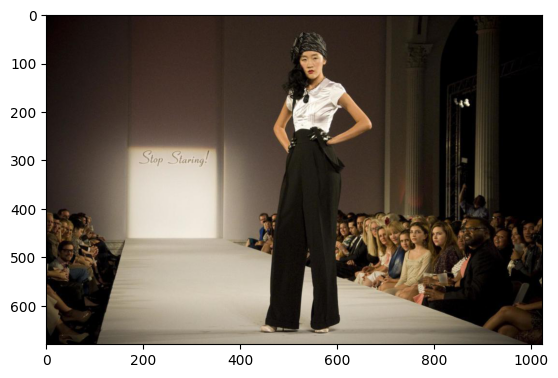

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
plt.imshow(Image.open("/content/images_20.jpg"))

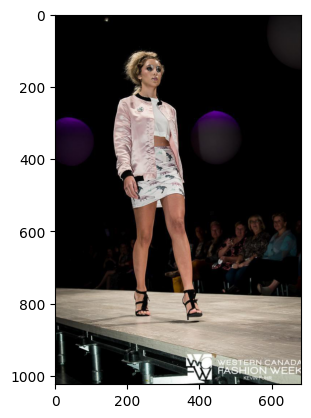

In [ ]:
plt.imshow(Image.open("/content/images_41.jpg"))

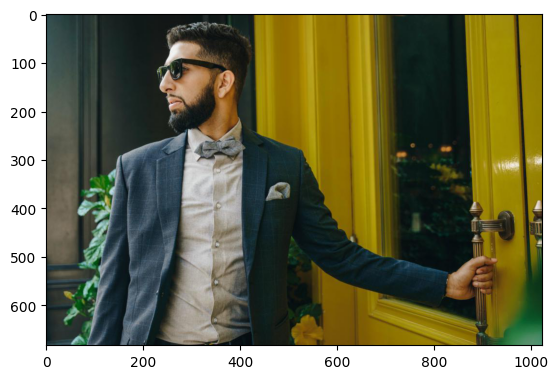

In [11]:
plt.imshow(Image.open("/content/images_1.jpg"))

## Create Embeddings

In [14]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.3 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=0a0d1cb43157b519f402b3055b178ee698929cba326cf897153e7ca3c1677978
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [15]:
from sentence_transformers import SentenceTransformer
import pickle
import joblib
import pandas as pd
#
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
#encoding
embeddings = model.encode(df["desc"].tolist(),show_progress_bar=True)


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

In [16]:
embeddings.shape

(968, 768)

## Save the embeddings generated

In [17]:
print(embeddings.shape)
joblib.dump(embeddings,"embeddings.pkl")

(968, 768)


['embeddings.pkl']

## FAISS Search

In [18]:
! pip install -qU faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 20.9 MB/s eta 0:00:00


In [19]:
! pip install -qU gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 5.9 MB/s eta 0:

In [20]:
import gradio as gr
import joblib
import numpy as np
import faiss
#
embeddings = joblib.load("embeddings.pkl")
embeddings = embeddings.astype("float32")
print(embeddings.shape)
#
embedding_size = embeddings.shape[1]
print(embedding_size)
#
n_clusters = 5
num_results =5
#
quantizer = faiss.IndexFlatIP(embedding_size)
index = faiss.IndexIVFFlat(quantizer,
                           embedding_size,
                           n_clusters,
                           faiss.METRIC_INNER_PRODUCT,
                           )
#
index.train(embeddings)
index.add(embeddings)

(968, 768)
768


## Helper function for search

In [24]:
def _search(query):
  query_embedding = model.encode(query)
  query_embedding = np.array(query_embedding).astype("float32")
  query_embedding = query_embedding.reshape(1,-1)
  distances,indices = index.search(query_embedding,5)
  images = [f"images/{i}.jpg" for i in indices[0]]
  return images

In [25]:
images = _search("A beautiful red-haired woman waling the wramp")

In [26]:
images

['images/670.jpg',
 'images/120.jpg',
 'images/671.jpg',
 'images/628.jpg',
 'images/121.jpg']

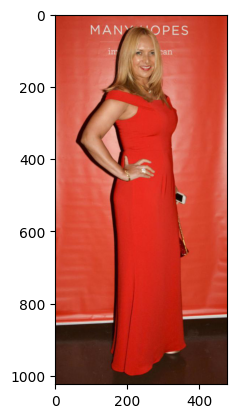

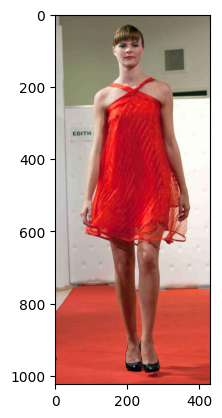

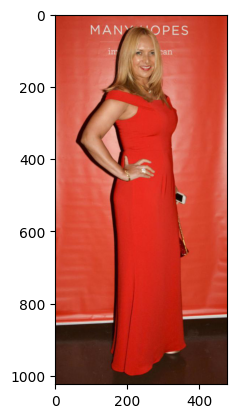

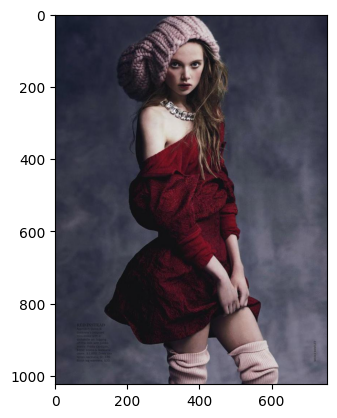

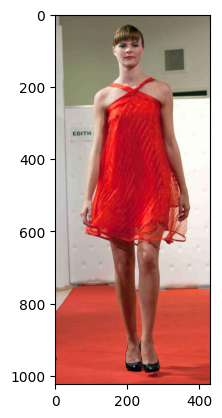

In [27]:
from PIL import Image
import matplotlib.pyplot as plt
for img in images:
  plt.imshow(Image.open(img))
  plt.show()

In [28]:
with gr.Blocks() as demo:
  query = gr.Textbox(lines=1,label="search_query")
  #num_results = gr.Number(label="Number of matches")
  outputs = gr.Gallery(preview=True)
  submit = gr.Button(value="search")
  submit.click(_search,inputs=query,outputs=outputs)
demo.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.
